In [ ]:
# prototipar las series con qw

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesVectorQuantizerPrecomputed(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, distance_matrix, 
                 product_to_idx_map, commitment_cost=0.25):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # Matriz de distancias DTW pre-calculada
        self.distance_matrix = torch.FloatTensor(distance_matrix)
        self.product_to_idx_map = product_to_idx_map
        
        # Diccionario: K vectores de D dimensiones
        self.embeddings = nn.Parameter(torch.randn(num_embeddings, embedding_dim) * 0.1)
        
        # Para mapear embeddings a índices de productos en la matriz DTW
        self.embedding_to_product_idx = nn.Parameter(
            torch.randint(0, len(product_to_idx_map), (num_embeddings,)), 
            requires_grad=False
        )
        
        # Para forzar diversidad en clusters
        self.cluster_usage = torch.zeros(num_embeddings)
        self.temperature = nn.Parameter(torch.tensor(1.0))
        
    def get_dtw_distances(self, product_indices):
        """
        Obtiene distancias DTW desde la matriz pre-calculada
        product_indices: índices de productos en el batch
        returns: tensor (B, K) con distancias DTW
        """
        B = len(product_indices)
        K = self.num_embeddings
        
        distances = torch.zeros(B, K, device=self.distance_matrix.device)
        
        for i, prod_idx in enumerate(product_indices):
            for k in range(K):
                # Obtener el índice del producto asignado al embedding k
                emb_prod_idx = self.embedding_to_product_idx[k].item()
                
                # Buscar distancia en la matriz pre-calculada
                if prod_idx < self.distance_matrix.shape[0] and emb_prod_idx < self.distance_matrix.shape[1]:
                    distances[i, k] = self.distance_matrix[prod_idx, emb_prod_idx]
                else:
                    # Si no está en la matriz, usar distancia euclidiana como fallback
                    distances[i, k] = float('inf')
        
        return distances
    
    def forward(self, z, product_indices):
        """
        z: Tensor (B, D) — series temporales de entrada
        product_indices: índices de productos en la matriz DTW
        returns:
          - z_q: cuantizado (B, D)
          - vq_loss: pérdida de cuantización
          - commitment_loss: pérdida de compromiso
          - indices: (B,) índices de embeddings asignados
        """
        B, D = z.shape
        
        # Obtener distancias DTW desde la matriz pre-calculada
        dtw_distances = self.get_dtw_distances(product_indices)
        
        # Aplicar temperatura para suavizar la asignación
        dtw_distances = dtw_distances / (self.temperature + 1e-8)
        
        # Obtener el índice del embedding más cercano
        encoding_indices = torch.argmin(dtw_distances, dim=1)
        
        # Actualizar contador de uso
        for idx in encoding_indices:
            self.cluster_usage[idx] += 1
        
        quantized = self.embeddings[encoding_indices]
        
        # Pérdidas (usar MSE para mantener gradientes)
        vq_loss = F.mse_loss(quantized.detach(), z)
        commitment_loss = F.mse_loss(quantized, z.detach())
        
        # Pérdida de diversidad
        diversity_loss = self.compute_diversity_loss()
        
        # Pérdida para actualizar asignaciones embedding->producto
        assignment_loss = self.compute_assignment_loss(dtw_distances, encoding_indices)
        
        total_loss = (vq_loss + 
                     self.commitment_cost * commitment_loss + 
                     0.01 * diversity_loss +
                     0.001 * assignment_loss)
        
        # Straight-through estimator
        quantized = z + (quantized - z).detach()
        
        return quantized, total_loss, vq_loss, commitment_loss, encoding_indices
    
    def compute_diversity_loss(self):
        """Penaliza clusters no utilizados para forzar diversidad"""
        usage_probs = F.softmax(self.cluster_usage + 1e-8, dim=0)
        uniform_prob = 1.0 / self.num_embeddings
        
        kl_div = F.kl_div(
            torch.log(usage_probs + 1e-8), 
            torch.full_like(usage_probs, uniform_prob),
            reduction='sum'
        )
        
        return kl_div
    
    def compute_assignment_loss(self, dtw_distances, encoding_indices):
        """Pérdida para optimizar las asignaciones embedding->producto"""
        # Penalizar asignaciones que resulten en distancias DTW altas
        selected_distances = dtw_distances[torch.arange(len(encoding_indices)), encoding_indices]
        return selected_distances.mean()
    
    def update_embedding_assignments(self, learning_rate=0.1):
        """Actualiza las asignaciones embedding->producto basado en uso"""
        with torch.no_grad():
            # Encontrar embeddings poco utilizados
            usage_threshold = self.cluster_usage.mean() * 0.5
            underused = self.cluster_usage < usage_threshold
            
            if underused.sum() > 0:
                # Reasignar embeddings poco utilizados a productos aleatorios
                n_products = len(self.product_to_idx_map)
                new_assignments = torch.randint(0, n_products, (underused.sum(),))
                self.embedding_to_product_idx[underused] = new_assignments
                
                # Reset usage counter para embeddings reasignados
                self.cluster_usage[underused] = 0




class TimeSeriesDatasetPrecomputed(Dataset):
    """Dataset para series temporales con matriz DTW pre-calculada"""
    def __init__(self, df, distance_matrix, min_periods=6, scaler=None):
        """
        df: DataFrame con columnas ['periodo', 'product_id', 'tn']
        distance_matrix: matriz de distancias DTW (n_products x n_products)
        """
        self.prepare_data(df, distance_matrix, min_periods, scaler)
    
    def prepare_data(self, df, distance_matrix, min_periods, scaler):
        print("Preparando dataset con matriz DTW pre-calculada...")
        
        # Crear matriz pivot
        pivot_df = df.pivot(index='periodo', columns='product_id', values='tn')
        
        # Filtrar productos con suficientes datos
        valid_products = pivot_df.columns[pivot_df.count() >= min_periods]
        clean_data = pivot_df[valid_products].fillna(0)
        
        print(f"Productos válidos: {len(valid_products)} de {len(pivot_df.columns)}")
        print(f"Períodos: {len(clean_data)}")
        
        # Crear mapeo de product_id a índice en matriz DTW
        if isinstance(distance_matrix, pd.DataFrame):
            # Si la matriz tiene índices de productos
            self.product_to_idx_map = {
                pid: idx for idx, pid in enumerate(distance_matrix.index)
            }
            self.distance_matrix = distance_matrix.values
        else:
            # Si es array numpy, asumir orden secuencial
            self.product_to_idx_map = {
                pid: idx for idx, pid in enumerate(valid_products)
            }
            self.distance_matrix = distance_matrix
        
        # Filtrar productos que están en la matriz DTW
        products_in_matrix = [p for p in valid_products if p in self.product_to_idx_map]
        clean_data = clean_data[products_in_matrix]
        
        print(f"Productos en matriz DTW: {len(products_in_matrix)}")
        
        # Transponer: productos x períodos
        self.series_matrix = clean_data.T
        self.product_ids = np.array(products_in_matrix)
        
        # Normalización
        if scaler is None:
            self.scaler = StandardScaler()
            self.series_normalized = self.scaler.fit_transform(self.series_matrix)
        else:
            self.scaler = scaler
            self.series_normalized = scaler.transform(self.series_matrix)
        
        # Convertir a tensores
        self.data = torch.FloatTensor(self.series_normalized)
        
        # Crear mapeo de índice en dataset a índice en matriz DTW
        self.dataset_to_matrix_idx = [
            self.product_to_idx_map[pid] for pid in self.product_ids
        ]
        
        print(f"Forma final del dataset: {self.data.shape}")
        print(f"Forma de matriz DTW: {self.distance_matrix.shape}")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        matrix_idx = self.dataset_to_matrix_idx[idx]
        return self.data[idx], self.product_ids[idx], matrix_idx

class TimeSeriesVQTrainerPrecomputed:
    def __init__(self, distance_matrix, num_embeddings_range=range(4, 21), 
                 embedding_dim=None, commitment_cost=0.25, min_clusters=None, device='cuda'):
        self.distance_matrix = distance_matrix
        self.num_embeddings_range = num_embeddings_range
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.min_clusters = min_clusters
        self.device = device if torch.cuda.is_available() else 'cpu'
        self.models = {}
        self.training_histories = {}
        
    def prepare_data(self, df, min_periods=6, batch_size=64, train_split=0.8):
        """Prepara datos de entrenamiento y validación"""
        
        # Crear dataset completo
        dataset = TimeSeriesDatasetPrecomputed(df, self.distance_matrix, min_periods)
        
        # División train/val
        n_samples = len(dataset)
        n_train = int(n_samples * train_split)
        
        train_indices = torch.randperm(n_samples)[:n_train]
        val_indices = torch.randperm(n_samples)[n_train:]
        
        train_dataset = torch.utils.data.Subset(dataset, train_indices)
        val_dataset = torch.utils.data.Subset(dataset, val_indices)
        
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Inferir embedding_dim si no se especifica
        if self.embedding_dim is None:
            self.embedding_dim = dataset.data.shape[1]
        
        self.dataset = dataset
        print(f"Datos preparados - Train: {len(train_dataset)}, Val: {len(val_dataset)}")
        print(f"Dimensión de embedding: {self.embedding_dim}")
        
        return self
    
    def train_single_model(self, num_embeddings, epochs=50, lr=1e-3, verbose=True):
        """Entrena un modelo VQ con número específico de embeddings"""
        
        # Crear modelo
        model = TimeSeriesVectorQuantizerPrecomputed(
            num_embeddings=num_embeddings,
            embedding_dim=self.embedding_dim,
            distance_matrix=self.dataset.distance_matrix,
            product_to_idx_map=self.dataset.product_to_idx_map,
            commitment_cost=self.commitment_cost
        ).to(self.device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
        
        # Historial de entrenamiento
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_vq_loss': [],
            'val_vq_loss': [],
            'train_commitment_loss': [],
            'val_commitment_loss': [],
            'active_clusters': []
        }
        
        if verbose:
            print(f"\nEntrenando modelo con {num_embeddings} embeddings...")
        
        for epoch in range(epochs):
            # Reset cluster usage
            model.cluster_usage.zero_()
            
            # Entrenamiento
            model.train()
            train_losses = {'total': [], 'vq': [], 'commitment': []}
            
            for series, products, matrix_indices in self.train_loader:
                series = series.to(self.device)
                matrix_indices = matrix_indices.to(self.device)
                
                optimizer.zero_grad()
                z_q, total_loss, vq_loss, commitment_loss, indices = model(series, matrix_indices)
                total_loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                train_losses['total'].append(total_loss.item())
                train_losses['vq'].append(vq_loss.item())
                train_losses['commitment'].append(commitment_loss.item())
            
            # Validación
            model.eval()
            val_losses = {'total': [], 'vq': [], 'commitment': []}
            all_indices = []
            
            with torch.no_grad():
                for series, products, matrix_indices in self.val_loader:
                    series = series.to(self.device)
                    matrix_indices = matrix_indices.to(self.device)
                    
                    z_q, total_loss, vq_loss, commitment_loss, indices = model(series, matrix_indices)
                    
                    val_losses['total'].append(total_loss.item())
                    val_losses['vq'].append(vq_loss.item())
                    val_losses['commitment'].append(commitment_loss.item())
                    all_indices.extend(indices.cpu().numpy())
            
            # Actualizar asignaciones embedding->producto cada 10 épocas
            if epoch % 10 == 0:
                model.update_embedding_assignments()
            
            # Contar clusters activos
            active_clusters = len(set(all_indices))
            
            # Guardar historial
            avg_train_loss = np.mean(train_losses['total'])
            avg_val_loss = np.mean(val_losses['total'])
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['train_vq_loss'].append(np.mean(train_losses['vq']))
            history['val_vq_loss'].append(np.mean(val_losses['vq']))
            history['train_commitment_loss'].append(np.mean(train_losses['commitment']))
            history['val_commitment_loss'].append(np.mean(val_losses['commitment']))
            history['active_clusters'].append(active_clusters)
            
            scheduler.step(avg_val_loss)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Época {epoch+1}/{epochs} - "
                      f"Train: {avg_train_loss:.4f}, Val: {avg_val_loss:.4f}, "
                      f"Clusters activos: {active_clusters}/{num_embeddings}")
        
        return model, history
    
    def find_optimal_embeddings(self, epochs=50, lr=1e-3):
        """Entrena modelos con diferentes números de embeddings para encontrar el óptimo"""
        
        print("Buscando número óptimo de embeddings con matriz DTW...")
        results = []
        
        for num_embeddings in tqdm(self.num_embeddings_range):
            model, history = self.train_single_model(
                num_embeddings=num_embeddings,
                epochs=epochs,
                lr=lr,
                verbose=False
            )
            
            # Evaluar modelo
            final_val_loss = history['val_loss'][-1]
            final_train_loss = history['train_loss'][-1]
            overfitting = final_val_loss - final_train_loss
            final_active_clusters = history['active_clusters'][-1]
            
            # Calcular utilización de embeddings
            utilization = final_active_clusters / num_embeddings
            
            # Penalizar si no alcanza el mínimo de clusters
            adjusted_loss = final_val_loss
            if self.min_clusters and final_active_clusters < self.min_clusters:
                penalty = (self.min_clusters - final_active_clusters) * 0.1
                adjusted_loss += penalty
            
            results.append({
                'num_embeddings': num_embeddings,
                'val_loss': final_val_loss,
                'adjusted_loss': adjusted_loss,
                'train_loss': final_train_loss,
                'overfitting': overfitting,
                'embedding_utilization': utilization,
                'active_clusters': final_active_clusters,
                'model': model,
                'history': history
            })
            
            self.models[num_embeddings] = model
            self.training_histories[num_embeddings] = history
        
        self.optimization_results = results
        self.plot_optimization_results()
        
        return results
    
    def plot_optimization_results(self):
        """Visualiza resultados de optimización"""
        if not hasattr(self, 'optimization_results'):
            return
        
        results_df = pd.DataFrame(self.optimization_results)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Pérdida de validación y pérdida ajustada
        axes[0,0].plot(results_df['num_embeddings'], results_df['val_loss'], 'bo-', 
                      linewidth=2, label='Val Loss')
        axes[0,0].plot(results_df['num_embeddings'], results_df['adjusted_loss'], 'ro--', 
                      linewidth=2, label='Adjusted Loss')
        axes[0,0].set_title('Pérdida de Validación (DTW Matrix)')
        axes[0,0].set_xlabel('Número de Embeddings')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Marcar mínimo
        min_idx = results_df['adjusted_loss'].idxmin()
        min_k = results_df.loc[min_idx, 'num_embeddings']
        min_loss = results_df.loc[min_idx, 'adjusted_loss']
        axes[0,0].scatter(min_k, min_loss, color='red', s=100, zorder=5)
        axes[0,0].annotate(f'Min: k={min_k}', xy=(min_k, min_loss), 
                          xytext=(min_k+2, min_loss), 
                          arrowprops=dict(arrowstyle='->', color='red'))
        
        # 2. Clusters activos
        axes[0,1].plot(results_df['num_embeddings'], results_df['active_clusters'], 'go-', linewidth=2)
        axes[0,1].plot([results_df['num_embeddings'].min(), results_df['num_embeddings'].max()], 
                      [results_df['num_embeddings'].min(), results_df['num_embeddings'].max()], 
                      'k--', alpha=0.5, label='Ideal (k=num_embeddings)')
        if self.min_clusters:
            axes[0,1].axhline(y=self.min_clusters, color='red', linestyle='--', 
                             label=f'Min clusters: {self.min_clusters}')
        axes[0,1].set_title('Clusters Activos (DTW)')
        axes[0,1].set_xlabel('Número de Embeddings')
        axes[0,1].set_ylabel('Clusters Activos')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Utilización de embeddings
        axes[1,0].plot(results_df['num_embeddings'], results_df['embedding_utilization'], 'mo-', linewidth=2)
        axes[1,0].set_title('Utilización de Embeddings (DTW)')
        axes[1,0].set_xlabel('Número de Embeddings')
        axes[1,0].set_ylabel('% Embeddings Utilizados')
        axes[1,0].set_ylim(0, 1.1)
        axes[1,0].grid(True, alpha=0.3)
        
        # 4. Trade-off: Clusters activos vs Pérdida
        scatter = axes[1,1].scatter(results_df['active_clusters'], results_df['val_loss'], 
                                   c=results_df['num_embeddings'], cmap='viridis', s=80)
        axes[1,1].set_title('Trade-off: Clusters vs Pérdida (DTW)')
        axes[1,1].set_xlabel('Clusters Activos')
        axes[1,1].set_ylabel('Validation Loss')
        axes[1,1].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[1,1], label='Num Embeddings')
        
        plt.tight_layout()
        plt.show()
        
        self.print_recommendations(results_df)
    
    def print_recommendations(self, results_df):
        """Imprime recomendaciones basadas en los resultados"""
        
        print("\n" + "="*60)
        print("RECOMENDACIONES CON MATRIZ DTW PRE-CALCULADA")
        print("="*60)
        
        # Mejor según pérdida ajustada
        min_adj_loss_idx = results_df['adjusted_loss'].idxmin()
        print(f"🎯 Mejor modelo (pérdida ajustada):")
        print(f"   k = {results_df.loc[min_adj_loss_idx, 'num_embeddings']} "
              f"(adj_loss: {results_df.loc[min_adj_loss_idx, 'adjusted_loss']:.4f}, "
              f"clusters activos: {results_df.loc[min_adj_loss_idx, 'active_clusters']}, "
              f"utilización: {results_df.loc[min_adj_loss_idx, 'embedding_utilization']:.1%})")
        
        # Mejor según clusters activos si hay restricción
        if self.min_clusters:
            valid_models = results_df[results_df['active_clusters'] >= self.min_clusters]
            if len(valid_models) > 0:
                best_valid_idx = valid_models['val_loss'].idxmin()
                best_valid = valid_models.loc[best_valid_idx]
                print(f"✅ Mejor modelo con ≥{self.min_clusters} clusters:")
                print(f"   k = {best_valid['num_embeddings']} "
                      f"(loss: {best_valid['val_loss']:.4f}, "
                      f"clusters: {best_valid['active_clusters']})")
        
        print("="*60)
    
    def get_best_model(self, criterion='adjusted_loss'):
        """Obtiene el mejor modelo según el criterio especificado"""
        if not hasattr(self, 'optimization_results'):
            raise ValueError("Primero ejecuta find_optimal_embeddings()")
        
        results_df = pd.DataFrame(self.optimization_results)
        
        if criterion == 'adjusted_loss':
            best_idx = results_df['adjusted_loss'].idxmin()
        elif criterion == 'val_loss':
            best_idx = results_df['val_loss'].idxmin()
        elif criterion == 'active_clusters':
            best_idx = results_df.loc[results_df['val_loss'] <= results_df['val_loss'].quantile(0.25)]['active_clusters'].idxmax()
        
        best_result = results_df.iloc[best_idx]
        return best_result['model'], best_result
    
    def analyze_clusters(self, model=None):
        """Analiza los clusters encontrados por el modelo"""
        if model is None:
            model, _ = self.get_best_model()
        
        model.eval()
        all_indices = []
        all_products = []
        all_series = []
        
        with torch.no_grad():
            for series, products, matrix_indices in DataLoader(self.dataset, batch_size=128):
                series = series.to(self.device)
                matrix_indices = matrix_indices.to(self.device)
                
                _, _, _, _, indices = model(series, matrix_indices)
                all_indices.extend(indices.cpu().numpy())
                all_products.extend(products)
                all_series.extend(series.cpu().numpy())
        
        # Crear DataFrame de resultados
        results_df = pd.DataFrame({
            'product_id': all_products,
            'cluster': all_indices
        })
        
        # Estadísticas por cluster
        cluster_stats = []
        active_clusters = set(all_indices)
        
        for cluster_id in active_clusters:
            mask = np.array(all_indices) == cluster_id
            if mask.sum() == 0:
                continue
                
            cluster_series = np.array(all_series)[mask]
            cluster_products = np.array(all_products)[mask]
            
            # Calcular estadísticas (des-normalizar primero)
            original_series = self.dataset.scaler.inverse_transform(cluster_series)
            
            stats = {
                'cluster': cluster_id,
                'size': len(cluster_products),
                'avg_total': original_series.sum(axis=1).mean(),
                'avg_volatility': original_series.std(axis=1).mean(),
                'avg_max': original_series.max(axis=1).mean(),
                'products': list(cluster_products[:10])  # Solo primeros 10
            }
            cluster_stats.append(stats)
        
        # Ordenar por tamaño
        cluster_stats.sort(key=lambda x: x['size'], reverse=True)
        
        return results_df, cluster_stats

# FUNCIÓN PRINCIPAL PARA USAR MATRIZ DTW PRE-CALCULADA
def train_timeseries_vq_with_dtw_matrix(df, distance_matrix, 
                                       num_embeddings_range=range(10, 51), 
                                       min_periods=6, epochs=80, batch_size=64, 
                                       commitment_cost=0.50, min_clusters=None):
    """
    Función principal para entrenar VQ usando matriz DTW pre-calculada
    
    Args:
        df: DataFrame con columnas ['periodo', 'product_id', 'tn']
        distance_matrix: matriz de distancias DTW (pandas DataFrame o numpy array)
                        Si es DataFrame, debe tener product_ids como índice/columnas
                        Si es array, se asume orden secuencial de productos
        num_embeddings_range: rango de números de embeddings a probar
        min_periods: mínimo número de períodos por producto
        epochs: épocas de entrenamiento
        batch_size: tamaño de batch
        commitment_cost: peso de commitment loss
        min_clusters: número mínimo de clusters deseado
    
    Returns:
        trainer: objeto entrenador con todos los modelos
        best_model: mejor modelo encontrado
        results_df: DataFrame con asignaciones de clusters
        cluster_stats: estadísticas por cluster
    """
    
    print("Inicializando Vector Quantizer con matriz DTW pre-calculada...")
    print(f"Forma de matriz DTW: {distance_matrix.shape}")
    
    # Inicializar trainer
    trainer = TimeSeriesVQTrainerPrecomputed(
        distance_matrix=distance_matrix,
        num_embeddings_range=num_embeddings_range,
        commitment_cost=commitment_cost,
        min_clusters=min_clusters
    )
    
    # Preparar datos
    trainer.prepare_data(df, min_periods=min_periods, batch_size=batch_size)
    
    # Buscar número óptimo
    optimization_results = trainer.find_optimal_embeddings(epochs=epochs)
    
    # Obtener mejor modelo
    best_model, best_result = trainer.get_best_model()
    
    print(f"\n🏆 MEJOR MODELO CON MATRIZ DTW:")
    print(f"   Embeddings: {best_result['num_embeddings']}")
    print(f"   Validation Loss: {best_result['val_loss']:.4f}")
    print(f"   Clusters activos: {best_result['active_clusters']}")
    print(f"   Utilización: {best_result['embedding_utilization']:.1%}")
    
    # Analizar clusters
    results_df, cluster_stats = trainer.analyze_clusters(best_model)
    
    print(f"\nResumen de clusters:")
    for stat in cluster_stats[:10]:  # Top 10
        print(f"  Cluster {stat['cluster']}: {stat['size']} productos, "
              f"avg_total={stat['avg_total']:.1f}")
    
    return trainer, best_model, results_df, cluster_stats

# eSta funcion es la q genera

In [16]:
class TimeSeriesVectorQuantizerPrecomputed(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, distance_matrix, 
                 product_to_idx_map, commitment_cost=0.25):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # Matriz de distancias DTW pre-calculada - USAR BUFFER PARA AUTO-DEVICE
        self.register_buffer('distance_matrix', torch.FloatTensor(distance_matrix))
        self.product_to_idx_map = product_to_idx_map
        
        # Diccionario: K vectores de D dimensiones
        self.embeddings = nn.Parameter(torch.randn(num_embeddings, embedding_dim) * 0.1)
        
        # Para mapear embeddings a índices de productos en la matriz DTW - TAMBIÉN BUFFER
        self.register_buffer('embedding_to_product_idx',
            torch.randint(0, len(product_to_idx_map), (num_embeddings,)))
        
        # Para forzar diversidad en clusters - TAMBIÉN BUFFER
        self.register_buffer('cluster_usage', torch.zeros(num_embeddings))
        self.temperature = nn.Parameter(torch.tensor(1.0))
        
    def get_dtw_distances(self, product_indices):
        """
        Obtiene distancias DTW desde la matriz pre-calculada
        product_indices: índices de productos en el batch
        returns: tensor (B, K) con distancias DTW
        """
        B = len(product_indices)
        K = self.num_embeddings
        
        # Usar el mismo dispositivo que distance_matrix (que ahora es un buffer)
        distances = torch.zeros(B, K, device=self.distance_matrix.device)
        
        for i, prod_idx in enumerate(product_indices):
            for k in range(K):
                # Obtener el índice del producto asignado al embedding k
                emb_prod_idx = self.embedding_to_product_idx[k].item()
                
                # Buscar distancia en la matriz pre-calculada
                if prod_idx < self.distance_matrix.shape[0] and emb_prod_idx < self.distance_matrix.shape[1]:
                    distances[i, k] = self.distance_matrix[prod_idx, emb_prod_idx]
                else:
                    # Si no está en la matriz, usar distancia euclidiana como fallback
                    distances[i, k] = float('inf')
        
        return distances
    
    def forward(self, z, product_indices):
        """
        z: Tensor (B, D) — series temporales de entrada
        product_indices: índices de productos en la matriz DTW
        returns:
          - z_q: cuantizado (B, D)
          - vq_loss: pérdida de cuantización
          - commitment_loss: pérdida de compromiso
          - indices: (B,) índices de embeddings asignados
        """
        B, D = z.shape
        
        # Obtener distancias DTW desde la matriz pre-calculada
        dtw_distances = self.get_dtw_distances(product_indices)
        
        # Aplicar temperatura para suavizar la asignación - YA NO HAY ERROR DE DISPOSITIVO
        dtw_distances = dtw_distances / (self.temperature + 1e-8)
        
        # Obtener el índice del embedding más cercano
        encoding_indices = torch.argmin(dtw_distances, dim=1)
        
        # Actualizar contador de uso
        for idx in encoding_indices:
            self.cluster_usage[idx] += 1
        
        quantized = self.embeddings[encoding_indices]
        
        # Pérdidas (usar MSE para mantener gradientes)
        vq_loss = F.mse_loss(quantized.detach(), z)
        commitment_loss = F.mse_loss(quantized, z.detach())
        
        # Pérdida de diversidad
        diversity_loss = self.compute_diversity_loss()
        
        # Pérdida para actualizar asignaciones embedding->producto
        assignment_loss = self.compute_assignment_loss(dtw_distances, encoding_indices)
        
        total_loss = (vq_loss + 
                     self.commitment_cost * commitment_loss + 
                     0.01 * diversity_loss +
                     0.001 * assignment_loss)
        
        # Straight-through estimator
        quantized = z + (quantized - z).detach()
        
        return quantized, total_loss, vq_loss, commitment_loss, encoding_indices
    
    def compute_diversity_loss(self):
        """Penaliza clusters no utilizados para forzar diversidad"""
        usage_probs = F.softmax(self.cluster_usage + 1e-8, dim=0)
        uniform_prob = 1.0 / self.num_embeddings
        
        kl_div = F.kl_div(
            torch.log(usage_probs + 1e-8), 
            torch.full_like(usage_probs, uniform_prob),
            reduction='sum'
        )
        
        return kl_div
    
    def compute_assignment_loss(self, dtw_distances, encoding_indices):
        """Pérdida para optimizar las asignaciones embedding->producto"""
        # Penalizar asignaciones que resulten en distancias DTW altas
        selected_distances = dtw_distances[torch.arange(len(encoding_indices)), encoding_indices]
        return selected_distances.mean()
    
    def update_embedding_assignments(self, learning_rate=0.1):
        """Actualiza las asignaciones embedding->producto basado en uso"""
        with torch.no_grad():
            # Encontrar embeddings poco utilizados
            usage_threshold = self.cluster_usage.mean() * 0.5
            underused = self.cluster_usage < usage_threshold
            
            if underused.sum() > 0:
                # Reasignar embeddings poco utilizados a productos aleatorios
                n_products = len(self.product_to_idx_map)
                new_assignments = torch.randint(0, n_products, (underused.sum(),), 
                                              device=self.embedding_to_product_idx.device)
                self.embedding_to_product_idx[underused] = new_assignments
                
                # Reset usage counter para embeddings reasignados
                self.cluster_usage[underused] = 0

In [4]:
# Si tu matriz está en un archivo CSV (como parece en la imagen)
import pandas as pd
import numpy as np

# Cargar matriz DTW
dtw_matrix = pd.read_csv('clusters/dtw_matrix_agosto19.csv', index_col=0)
print(f"Forma de matriz DTW: {dtw_matrix.shape}")

Forma de matriz DTW: (1181, 1181)


In [31]:
print(f"Es simétrica: {np.allclose(dtw_matrix.values, dtw_matrix.values.T)}")

Es simétrica: True


In [32]:
print(f"Distancia mínima: {dtw_matrix.values.min()}")
print(f"Distancia máxima: {dtw_matrix.values.max()}")
print(f"Distancia promedio: {dtw_matrix.values.mean()}")

Distancia mínima: 0.0
Distancia máxima: 9.85191448521266
Distancia promedio: 4.77166465706747


In [3]:
import pandas as pd
import os
pathdata='data/'
filename = 'sell-in.txt'

    # Unir ruta completa
filepath = os.path.join(pathdata, filename)
sell = pd.read_csv(filepath, sep="\t")
    
df_agg = sell.groupby(['periodo', 'product_id'], as_index=False).agg({
'tn': 'sum'
})
df_agg= df_agg[df_agg['periodo'] <= 201908].copy()

In [34]:
df_agg

,periodo,product_id,tn
0,201701,20001,934.77222
1,201701,20002,550.15707
2,201701,20003,1063.45835
3,201701,20004,555.91614
4,201701,20005,494.27011
...,...,...,...
27490,201908,21267,0.04054
27491,201908,21269,0.11771
27492,201908,21270,0.81278
27493,201908,21271,0.01784


In [17]:
# Entrenar con tu matriz DTW pre-calculada
trainer, best_model, results_df, cluster_stats = train_timeseries_vq_with_dtw_matrix(
    df=df_agg,                          # Tu DataFrame original
    distance_matrix=dtw_matrix,              # Tu matriz DTW 1229x1229
    num_embeddings_range=range(15, 100),     # Probar de 15 a 100 clusters
    min_clusters=20,                         # Mínimo 20 clusters
    min_periods=6,                           # Mínimo 6 períodos por producto
    epochs=100,                              # Épocas de entrenamiento
    batch_size=32,                           # Batch size más pequeño
    commitment_cost=0.3                      # Menor commitment para más diversidad
)

# Ver resultados
print(f"\nClusters encontrados: {results_df['cluster'].nunique()}")
print(f"Distribución de clusters:")
print(results_df['cluster'].value_counts().head(10))

Inicializando Vector Quantizer con matriz DTW pre-calculada...
Forma de matriz DTW: (1181, 1181)
Preparando dataset con matriz DTW pre-calculada...
Productos válidos: 1034 de 1181
Períodos: 32
Productos en matriz DTW: 1034
Forma final del dataset: torch.Size([1034, 32])
Forma de matriz DTW: (1181, 1181)
Datos preparados - Train: 827, Val: 207
Dimensión de embedding: 32
Buscando número óptimo de embeddings con matriz DTW...


  0%|          | 0/85 [02:15<?, ?it/s]


KeyboardInterrupt: 

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def diagnose_cluster_data(trainer, model, df_original, cluster_id=10):
    """
    Función de diagnóstico para entender por qué no se ven las series
    """
    print("=== DIAGNÓSTICO DE DATOS ===")
    
    # Obtener asignaciones de clusters
    results_df, cluster_stats = trainer.analyze_clusters(model)
    
    print(f"DataFrame original shape: {df_original.shape}")
    print(f"Columnas: {list(df_original.columns)}")
    print(f"Primeros productos en df_original: {df_original['product_id'].unique()[:5]}")
    print(f"Tipo de product_id en df_original: {type(df_original['product_id'].iloc[0])}")
    print(f"Primeros períodos en df_original: {df_original['periodo'].unique()[:5]}")
    print(f"Tipo de período en df_original: {type(df_original['periodo'].iloc[0])}")
    
    print("\n--- Información de Clusters ---")
    print(f"Total clusters activos: {len(cluster_stats)}")
    print(f"Primeros 5 cluster stats: {[(s['cluster'], s['size']) for s in cluster_stats[:5]]}")
    
    # Verificar cluster específico
    if cluster_id in results_df['cluster'].values:
        cluster_products = results_df[results_df['cluster'] == cluster_id]['product_id']
        print(f"\nCluster {cluster_id}:")
        print(f"  Productos en cluster: {len(cluster_products)}")
        print(f"  Primeros productos: {list(cluster_products.head())}")
        print(f"  Tipo de product_id en cluster: {type(cluster_products.iloc[0])}")
        
        # Verificar si estos productos existen en df_original
        found_products = []
        for pid in cluster_products.head(3):
            matches = df_original[df_original['product_id'] == pid]
            if len(matches) > 0:
                found_products.append((pid, len(matches)))
                print(f"  Producto {pid}: {len(matches)} registros encontrados")
            else:
                print(f"  Producto {pid}: NO ENCONTRADO en df_original")
        
        if found_products:
            pid, count = found_products[0]
            sample_data = df_original[df_original['product_id'] == pid].sort_values('periodo')
            print(f"  Muestra de datos del producto {pid}:")
            print(sample_data[['periodo', 'tn']].head())
            print(f"  Rango de tn: {sample_data['tn'].min():.4f} - {sample_data['tn'].max():.4f}")
    else:
        print(f"Cluster {cluster_id} no existe")
    
    print("\n=== FIN DIAGNÓSTICO ===")

def plot_cluster_prototypes_fixed(trainer, model, df_original, max_clusters=12, debug=False):
    """
    Versión corregida que maneja mejor los tipos de datos y el mapeo
    """
    results_df, cluster_stats = trainer.analyze_clusters(model)
    
    if debug:
        print(f"DEBUG: Clusters encontrados: {len(cluster_stats)}")
        print(f"DEBUG: Primeros clusters: {[(s['cluster'], s['size']) for s in cluster_stats[:5]]}")
    
    # Tomar clusters más grandes
    top_clusters = [stat['cluster'] for stat in cluster_stats[:max_clusters]]
    
    if len(top_clusters) == 0:
        print("No hay clusters para mostrar")
        return
    
    # Preparar el DataFrame original para búsquedas más eficientes
    df_original = df_original.copy()
    
    # Asegurar que los tipos coincidan
    if results_df['product_id'].dtype != df_original['product_id'].dtype:
        # Intentar convertir tipos
        try:
            df_original['product_id'] = df_original['product_id'].astype(results_df['product_id'].dtype)
        except:
            try:
                results_df['product_id'] = results_df['product_id'].astype(df_original['product_id'].dtype)
            except:
                print("WARNING: No se pudieron alinear los tipos de product_id")
    
    # Calcular número de filas y columnas para subplots
    n_clusters = len(top_clusters)
    cols = min(4, n_clusters)
    rows = (n_clusters + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    
    # Asegurar que axes sea siempre un array
    if n_clusters == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    clusters_plotted = 0
    
    for i, cluster_id in enumerate(top_clusters):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        # Obtener productos del cluster
        cluster_products = results_df[results_df['cluster'] == cluster_id]['product_id']
        
        if debug:
            print(f"DEBUG: Cluster {cluster_id} tiene {len(cluster_products)} productos")
        
        # Obtener series temporales de algunos productos del cluster
        sample_products = cluster_products.head(8)  # Más productos para tener mejor chance
        
        cluster_data = []
        products_plotted = 0
        
        for j, product_id in enumerate(sample_products):
            # Buscar serie temporal del producto
            product_mask = df_original['product_id'] == product_id
            product_series = df_original[product_mask].copy()
            
            if len(product_series) == 0:
                if debug:
                    print(f"DEBUG: Producto {product_id} no encontrado")
                continue
            
            product_series = product_series.sort_values('periodo')
            
            if len(product_series) > 1:  # Solo si tiene más de 1 punto
                # Crear índice secuencial para el eje X
                x_vals = range(len(product_series))
                y_vals = product_series['tn'].values
                
                # Plotear solo si hay variación en los datos
                if np.std(y_vals) > 1e-6:  # Hay variación mínima
                    color = plt.cm.tab10(products_plotted % 10)
                    ax.plot(x_vals, y_vals, 
                           alpha=0.7, linewidth=1.5, color=color,
                           label=f'Prod {product_id}' if products_plotted < 3 else "")
                    
                    cluster_data.append(y_vals)
                    products_plotted += 1
                    
                    if debug and products_plotted == 1:
                        print(f"DEBUG: Producto {product_id} - valores: {y_vals[:5]}...")
        
        # Calcular y plotear promedio del cluster si hay datos
        if cluster_data and len(cluster_data) > 0:
            # Asegurar que todas las series tengan la misma longitud
            min_length = min(len(series) for series in cluster_data)
            if min_length > 1:
                cluster_data_trimmed = [series[:min_length] for series in cluster_data]
                cluster_mean = np.mean(cluster_data_trimmed, axis=0)
                
                if np.std(cluster_mean) > 1e-6:  # Solo si hay variación
                    ax.plot(range(len(cluster_mean)), cluster_mean, 'r-', 
                           linewidth=3, label='Promedio Cluster')
                    clusters_plotted += 1
        
        # Información del cluster
        cluster_stat = next((s for s in cluster_stats if s['cluster'] == cluster_id), None)
        if cluster_stat:
            ax.set_title(f'Cluster {cluster_id} (n={cluster_stat["size"]})\n'
                        f'Avg Total: {cluster_stat["avg_total"]:.1f}\n'
                        f'Series mostradas: {products_plotted}', fontsize=9)
        
        ax.set_xlabel('Período')
        ax.set_ylabel('tn')
        ax.grid(True, alpha=0.3)
        
        # Solo mostrar leyenda si hay datos
        if products_plotted > 0 and i < 6:
            ax.legend(fontsize=7, loc='best')
        
        # Si no hay datos, mostrar mensaje
        if products_plotted == 0:
            ax.text(0.5, 0.5, 'Sin datos\npara mostrar', 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    # Ocultar axes no usados
    for i in range(len(top_clusters), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nClusters con datos mostrados: {clusters_plotted}/{len(top_clusters)}")
    
    # Imprimir resumen de clusters mostrados
    print(f"\nResumen de clusters:")
    for i, stat in enumerate(cluster_stats[:max_clusters]):
        print(f"{i+1:2d}. Cluster {stat['cluster']:2d}: {stat['size']:3d} productos, "
              f"total_avg={stat['avg_total']:6.1f}, volatilidad={stat['avg_volatility']:5.2f}")

def simple_cluster_plot(results_df, df_original, cluster_id, max_products=5):
    """
    Función simple para plotear un cluster específico
    """
    cluster_products = results_df[results_df['cluster'] == cluster_id]['product_id'].head(max_products)
    
    print(f"Ploteando Cluster {cluster_id} con {len(cluster_products)} productos")
    
    plt.figure(figsize=(12, 6))
    
    colors = plt.cm.tab10(range(len(cluster_products)))
    all_series = []
    
    for i, product_id in enumerate(cluster_products):
        product_data = df_original[df_original['product_id'] == product_id].copy()
        
        if len(product_data) > 0:
            product_data = product_data.sort_values('periodo')
            
            print(f"Producto {product_id}: {len(product_data)} puntos, "
                  f"rango tn: {product_data['tn'].min():.3f}-{product_data['tn'].max():.3f}")
            
            x_vals = range(len(product_data))
            y_vals = product_data['tn'].values
            
            plt.plot(x_vals, y_vals, 'o-', color=colors[i], 
                    label=f'Producto {product_id}', linewidth=2, markersize=4)
            
            all_series.append(y_vals)
    
    # Promedio si hay múltiples series
    if len(all_series) > 1:
        min_length = min(len(s) for s in all_series)
        trimmed_series = [s[:min_length] for s in all_series]
        mean_series = np.mean(trimmed_series, axis=0)
        plt.plot(range(len(mean_series)), mean_series, 'k-', 
                linewidth=4, label='Promedio', alpha=0.8)
    
    plt.title(f'Cluster {cluster_id} - Series Temporales')
    plt.xlabel('Período (índice)')
    plt.ylabel('tn')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Función auxiliar para verificar datos
def check_data_alignment(trainer, model, df_original):
    """
    Verifica la alineación entre clusters y datos originales
    """
    results_df, cluster_stats = trainer.analyze_clusters(model)
    
    print("=== VERIFICACIÓN DE ALINEACIÓN ===")
    print(f"Productos únicos en results_df: {results_df['product_id'].nunique()}")
    print(f"Productos únicos en df_original: {df_original['product_id'].nunique()}")
    
    # Verificar intersección
    cluster_products = set(results_df['product_id'].unique())
    original_products = set(df_original['product_id'].unique())
    
    intersection = cluster_products.intersection(original_products)
    only_in_clusters = cluster_products - original_products
    only_in_original = original_products - cluster_products
    
    print(f"Productos en ambos: {len(intersection)}")
    print(f"Solo en clusters: {len(only_in_clusters)}")
    print(f"Solo en original: {len(only_in_original)}")
    
    if len(only_in_clusters) > 0:
        print(f"Ejemplos solo en clusters: {list(only_in_clusters)[:5]}")
    
    if len(only_in_original) > 0:
        print(f"Ejemplos solo en original: {list(only_in_original)[:5]}")
    
    return len(intersection) > 0

In [23]:
# Diagnosticar el problema
diagnose_cluster_data(trainer, best_model, df_agg, cluster_id=10)

# Verificar alineación de datos
data_aligned = check_data_alignment(trainer, best_model, df_agg)
print(f"Datos alineados: {data_aligned}")

=== DIAGNÓSTICO DE DATOS ===
DataFrame original shape: (29377, 3)
Columnas: ['periodo', 'product_id', 'tn']
Primeros productos en df_original: [20001 20002 20003 20004 20005]
Tipo de product_id en df_original: <class 'numpy.int64'>
Primeros períodos en df_original: [201701 201702 201703 201704 201705]
Tipo de período en df_original: <class 'numpy.int64'>

--- Información de Clusters ---
Total clusters activos: 81
Primeros 5 cluster stats: [(10, 23), (42, 23), (32, 22), (56, 22), (3, 21)]

Cluster 10:
  Productos en cluster: 23
  Primeros productos: [tensor(20082, dtype=torch.int32), tensor(20177, dtype=torch.int32), tensor(20181, dtype=torch.int32), tensor(20296, dtype=torch.int32), tensor(20317, dtype=torch.int32)]
  Tipo de product_id en cluster: <class 'torch.Tensor'>
  Producto 20082: NO ENCONTRADO en df_original
  Producto 20177: NO ENCONTRADO en df_original
  Producto 20181: NO ENCONTRADO en df_original

=== FIN DIAGNÓSTICO ===
=== VERIFICACIÓN DE ALINEACIÓN ===
Productos únicos 

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

def fix_cluster_results(results_df):
    """
    Convierte los tensors de PyTorch a valores numpy/python normales
    """
    print("Convirtiendo tensors de PyTorch...")
    
    # Convertir product_id de tensor a int
    if isinstance(results_df['product_id'].iloc[0], torch.Tensor):
        results_df['product_id'] = results_df['product_id'].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)
    
    # Convertir cluster de tensor a int si es necesario
    if isinstance(results_df['cluster'].iloc[0], torch.Tensor):
        results_df['cluster'] = results_df['cluster'].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)
    
    print(f"Tipos después de conversión:")
    print(f"product_id: {type(results_df['product_id'].iloc[0])}")
    print(f"cluster: {type(results_df['cluster'].iloc[0])}")
    
    return results_df

def check_product_mapping(results_df, df_original):
    """
    Verifica el mapeo entre productos en clusters y DataFrame original
    """
    print("\n=== VERIFICACIÓN DE MAPEO DE PRODUCTOS ===")
    
    cluster_products = set(results_df['product_id'].unique())
    original_products = set(df_original['product_id'].unique())
    
    print(f"Productos en clusters: {len(cluster_products)}")
    print(f"Productos en original: {len(original_products)}")
    
    # Verificar si hay mapeo directo
    intersection = cluster_products.intersection(original_products)
    print(f"Productos que coinciden directamente: {len(intersection)}")
    
    if len(intersection) == 0:
        print("\n❌ NO HAY COINCIDENCIAS DIRECTAS")
        print("Posibles causas:")
        print("1. Los productos en clusters están indexados (0, 1, 2...) en lugar de IDs reales")
        print("2. Hay un offset en los IDs")
        print("3. Los productos fueron filtrados durante el preprocesamiento")
        
        # Verificar si son índices secuenciales
        cluster_products_sorted = sorted(cluster_products)
        if cluster_products_sorted == list(range(len(cluster_products_sorted))):
            print("✅ Los clusters usan índices secuenciales (0, 1, 2...)")
            return "sequential_index"
        else:
            print(f"Rango de productos en clusters: {min(cluster_products)} - {max(cluster_products)}")
            print(f"Rango de productos en original: {min(original_products)} - {max(original_products)}")
            return "id_mismatch"
    else:
        print("✅ Hay coincidencias directas")
        return "direct_match"

def create_product_mapping(trainer, df_original):
    """
    Crea un mapeo correcto entre índices de dataset y product_ids reales
    """
    # Obtener el mapeo desde el dataset del trainer
    dataset_products = trainer.dataset.product_ids
    print(f"\nProductos en dataset del trainer: {len(dataset_products)}")
    print(f"Primeros 5: {dataset_products[:5]}")
    print(f"Tipo: {type(dataset_products[0])}")
    
    # Crear mapeo de índice -> product_id
    index_to_product = {i: pid for i, pid in enumerate(dataset_products)}
    
    return index_to_product

def fix_results_with_mapping(results_df, index_to_product):
    """
    Corrige los results_df usando el mapeo correcto
    """
    print("Aplicando mapeo correcto...")
    
    # Crear copia para no modificar el original
    fixed_results = results_df.copy()
    
    # Mapear los índices a product_ids reales
    fixed_results['real_product_id'] = fixed_results['product_id'].map(index_to_product)
    
    # Verificar que el mapeo funcionó
    unmapped = fixed_results['real_product_id'].isna().sum()
    if unmapped > 0:
        print(f"⚠️ {unmapped} productos no pudieron ser mapeados")
        # Mantener los IDs originales para los no mapeados
        fixed_results['real_product_id'] = fixed_results['real_product_id'].fillna(fixed_results['product_id'])
    
    # Reemplazar la columna product_id
    fixed_results['product_id'] = fixed_results['real_product_id']
    fixed_results = fixed_results.drop('real_product_id', axis=1)
    
    print("✅ Mapeo aplicado correctamente")
    return fixed_results

def plot_cluster_prototypes_working(results_df, df_original, max_clusters=12):
    """
    Versión que definitivamente funciona después de arreglar los mapeos
    """
    # Agrupar por cluster y obtener estadísticas
    cluster_sizes = results_df['cluster'].value_counts().sort_values(ascending=False)
    top_clusters = cluster_sizes.head(max_clusters).index.tolist()
    
    print(f"Ploteando {len(top_clusters)} clusters más grandes")
    
    # Calcular grid
    n_clusters = len(top_clusters)
    cols = min(4, n_clusters)
    rows = (n_clusters + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    
    if n_clusters == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    for i, cluster_id in enumerate(top_clusters):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        # Obtener productos del cluster
        cluster_products = results_df[results_df['cluster'] == cluster_id]['product_id'].unique()
        cluster_size = len(cluster_products)
        
        print(f"Cluster {cluster_id}: {cluster_size} productos")
        
        # Tomar muestra de productos para visualizar
        sample_size = min(5, len(cluster_products))
        sample_products = cluster_products[:sample_size]
        
        all_series = []
        products_plotted = 0
        
        colors = plt.cm.tab10(range(sample_size))
        
        for j, product_id in enumerate(sample_products):
            # Buscar datos del producto
            product_data = df_original[df_original['product_id'] == product_id].copy()
            
            if len(product_data) > 0:
                product_data = product_data.sort_values('periodo')
                
                x_vals = range(len(product_data))
                y_vals = product_data['tn'].values
                
                if len(y_vals) > 1 and np.std(y_vals) > 1e-6:
                    ax.plot(x_vals, y_vals, 'o-', 
                           color=colors[j], alpha=0.7, linewidth=1.5,
                           markersize=3, label=f'Prod {product_id}')
                    
                    all_series.append(y_vals)
                    products_plotted += 1
        
        # Calcular promedio del cluster
        if len(all_series) > 1:
            min_len = min(len(s) for s in all_series)
            trimmed_series = [s[:min_len] for s in all_series]
            mean_series = np.mean(trimmed_series, axis=0)
            
            ax.plot(range(len(mean_series)), mean_series, 'r-', 
                   linewidth=3, label='Promedio', alpha=0.9)
        
        # Calcular estadísticas del cluster
        cluster_data = []
        for pid in cluster_products:
            prod_data = df_original[df_original['product_id'] == pid]
            if len(prod_data) > 0:
                cluster_data.append(prod_data['tn'].sum())
        
        avg_total = np.mean(cluster_data) if cluster_data else 0
        
        ax.set_title(f'Cluster {cluster_id} (n={cluster_size})\n'
                    f'Avg Total: {avg_total:.1f}\n'
                    f'Mostradas: {products_plotted}', fontsize=9)
        
        ax.set_xlabel('Período')
        ax.set_ylabel('tn')
        ax.grid(True, alpha=0.3)
        
        if products_plotted > 0 and i < 4:
            ax.legend(fontsize=7, loc='best')
        
        if products_plotted == 0:
            ax.text(0.5, 0.5, 'Sin datos\nválidos', 
                   ha='center', va='center', transform=ax.transAxes)
    
    # Ocultar axes no usados
    for i in range(n_clusters, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def complete_fix_and_plot(trainer, best_model, df_original, max_clusters=12):
    """
    Función completa que arregla todos los problemas y plotea
    """
    print("🔧 INICIANDO REPARACIÓN COMPLETA...")
    
    # 1. Obtener resultados y arreglar tensors
    results_df, cluster_stats = trainer.analyze_clusters(best_model)
    results_df = fix_cluster_results(results_df)
    
    # 2. Verificar mapeo
    mapping_type = check_product_mapping(results_df, df_original)
    
    # 3. Crear mapeo correcto si es necesario
    if mapping_type in ["sequential_index", "id_mismatch"]:
        index_to_product = create_product_mapping(trainer, df_original)
        results_df = fix_results_with_mapping(results_df, index_to_product)
        
        # Verificar que ahora funciona
        final_check = check_product_mapping(results_df, df_original)
        if final_check != "direct_match":
            print("❌ No se pudo resolver el mapeo automáticamente")
            return None, None
    
    # 4. Plotear con datos corregidos
    print("\n🎨 CREANDO VISUALIZACIÓN...")
    plot_cluster_prototypes_working(results_df, df_original, max_clusters)
    
    # 5. Estadísticas finales
    print("\n📊 ESTADÍSTICAS FINALES:")
    cluster_summary = results_df['cluster'].value_counts().head(10)
    for cluster_id, size in cluster_summary.items():
        print(f"Cluster {cluster_id}: {size} productos")
    
    return results_df, cluster_stats

# Función de emergencia si todo lo demás falla
def emergency_plot(trainer, df_original, n_random_products=20):
    """
    Plot de emergencia usando productos aleatorios del DataFrame original
    """
    print("🚨 PLOT DE EMERGENCIA - Mostrando productos aleatorios")
    
    random_products = df_original['product_id'].drop_duplicates().sample(n_random_products)
    
    fig, axes = plt.subplots(4, 5, figsize=(20, 12))
    axes = axes.flatten()
    
    for i, product_id in enumerate(random_products):
        if i >= len(axes):
            break
            
        ax = axes[i]
        product_data = df_original[df_original['product_id'] == product_id].copy()
        product_data = product_data.sort_values('periodo')
        
        ax.plot(range(len(product_data)), product_data['tn'].values, 'b-o', markersize=3)
        ax.set_title(f'Producto {product_id}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [15]:
# Reparación completa y visualización
results_df_fixed, cluster_stats_fixed = complete_fix_and_plot(
    trainer, best_model, df_agg, max_clusters=12
)

NameError: name 'complete_fix_and_plot' is not defined

In [11]:
import pandas as pd
import numpy as np
import pickle
import torch
import json
from datetime import datetime
import os

def export_cluster_results(trainer, best_model, results_df_fixed, cluster_stats_fixed, 
                          df_original, export_dir="cluster_results"):
    """
    Exporta todos los resultados del clustering para uso posterior
    
    Args:
        trainer: objeto entrenador
        best_model: mejor modelo entrenado
        results_df_fixed: DataFrame con asignaciones corregidas
        cluster_stats_fixed: estadísticas de clusters
        df_original: DataFrame original
        export_dir: directorio donde guardar los archivos
    """
    
    # Crear directorio si no existe
    os.makedirs(export_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print(f"📦 Exportando resultados a: {export_dir}/")
    
    # 1. ASIGNACIONES DE CLUSTERS
    cluster_assignments_file = f"{export_dir}/cluster_assignments_{timestamp}.csv"
    results_df_fixed.to_csv(cluster_assignments_file, index=False)
    print(f"✅ Asignaciones guardadas: {cluster_assignments_file}")
    
    # 2. ESTADÍSTICAS DE CLUSTERS
    cluster_stats_df = pd.DataFrame(cluster_stats_fixed)
    cluster_stats_file = f"{export_dir}/cluster_statistics_{timestamp}.csv"
    cluster_stats_df.to_csv(cluster_stats_file, index=False)
    print(f"✅ Estadísticas guardadas: {cluster_stats_file}")
    
    # 3. RESUMEN EJECUTIVO
    summary = create_executive_summary(results_df_fixed, cluster_stats_fixed, df_original)
    summary_file = f"{export_dir}/executive_summary_{timestamp}.json"
    with open(summary_file, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"✅ Resumen ejecutivo: {summary_file}")
    
    # 4. MODELO PYTORCH (embeddings y parámetros)
    model_file = f"{export_dir}/best_model_{timestamp}.pth"
    torch.save({
        'model_state_dict': best_model.state_dict(),
        'model_params': {
            'num_embeddings': best_model.num_embeddings,
            'embedding_dim': best_model.embedding_dim,
            'commitment_cost': best_model.commitment_cost
        },
        'embeddings': best_model.embeddings.detach().cpu().numpy(),
        'cluster_usage': best_model.cluster_usage.detach().cpu().numpy()
    }, model_file)
    print(f"✅ Modelo guardado: {model_file}")
    
    # 5. CONFIGURACIÓN DEL ENTRENAMIENTO
    training_config = {
        'num_embeddings_range': list(trainer.num_embeddings_range),
        'embedding_dim': trainer.embedding_dim,
        'commitment_cost': trainer.commitment_cost,
        'min_clusters': trainer.min_clusters,
        'final_num_embeddings': best_model.num_embeddings,
        'dataset_shape': trainer.dataset.data.shape,
        'scaler_params': {
            'mean': trainer.dataset.scaler.mean_.tolist(),
            'scale': trainer.dataset.scaler.scale_.tolist()
        }
    }
    
    config_file = f"{export_dir}/training_config_{timestamp}.json"
    with open(config_file, 'w') as f:
        json.dump(training_config, f, indent=2)
    print(f"✅ Configuración guardada: {config_file}")
    
    # 6. RESULTADOS DE OPTIMIZACIÓN
    if hasattr(trainer, 'optimization_results'):
        opt_results = []
        for result in trainer.optimization_results:
            # No guardar el modelo en este archivo (es pesado)
            opt_result = {k: v for k, v in result.items() if k not in ['model', 'history']}
            opt_results.append(opt_result)
        
        opt_file = f"{export_dir}/optimization_results_{timestamp}.json"
        with open(opt_file, 'w') as f:
            json.dump(opt_results, f, indent=2)
        print(f"✅ Resultados de optimización: {opt_file}")
    
    # 7. ANÁLISIS DETALLADO POR CLUSTER
    detailed_analysis = create_detailed_cluster_analysis(results_df_fixed, df_original)
    detailed_file = f"{export_dir}/detailed_cluster_analysis_{timestamp}.csv"
    detailed_analysis.to_csv(detailed_file, index=False)
    print(f"✅ Análisis detallado: {detailed_file}")
    
    # 8. MAPEO DE PRODUCTOS
    product_mapping = create_product_mapping_export(trainer)
    mapping_file = f"{export_dir}/product_mapping_{timestamp}.csv"
    product_mapping.to_csv(mapping_file, index=False)
    print(f"✅ Mapeo de productos: {mapping_file}")
    
    # 9. DATASET PROCESADO (para reproducibilidad)
    dataset_file = f"{export_dir}/processed_dataset_{timestamp}.npz"
    np.savez(dataset_file,
             data=trainer.dataset.data.numpy(),
             product_ids=trainer.dataset.product_ids,
             scaler_mean=trainer.dataset.scaler.mean_,
             scaler_scale=trainer.dataset.scaler.scale_)
    print(f"✅ Dataset procesado: {dataset_file}")
    
    # 10. CREAR ARCHIVO ÍNDICE
    create_index_file(export_dir, timestamp)
    
    print(f"\n🎉 Exportación completa!")
    print(f"📁 Todos los archivos en: {export_dir}/")
    
    return export_dir, timestamp

def create_executive_summary(results_df, cluster_stats, df_original):
    """Crea resumen ejecutivo del clustering"""
    
    total_products = len(results_df)
    active_clusters = len(cluster_stats)
    
    # Concentración de productos
    top_5_size = sum(stat['size'] for stat in cluster_stats[:5])
    top_10_size = sum(stat['size'] for stat in cluster_stats[:10])
    
    # Estadísticas de volumen
    cluster_products = results_df['product_id'].unique()
    cluster_data = df_original[df_original['product_id'].isin(cluster_products)]
    
    summary = {
        'timestamp': datetime.now().isoformat(),
        'clustering_summary': {
            'total_products_clustered': int(total_products),
            'active_clusters': int(active_clusters),
            'largest_cluster_size': int(cluster_stats[0]['size']),
            'smallest_cluster_size': int(cluster_stats[-1]['size']),
            'avg_cluster_size': float(total_products / active_clusters)
        },
        'concentration_analysis': {
            'top_5_clusters_products': int(top_5_size),
            'top_5_clusters_percentage': float(top_5_size / total_products * 100),
            'top_10_clusters_products': int(top_10_size),
            'top_10_clusters_percentage': float(top_10_size / total_products * 100)
        },
        'volume_statistics': {
            'total_volume_all_products': float(cluster_data['tn'].sum()),
            'avg_volume_per_product': float(cluster_data.groupby('product_id')['tn'].sum().mean()),
            'highest_volume_cluster': {
                'cluster_id': int(cluster_stats[0]['cluster']),
                'avg_total': float(cluster_stats[0]['avg_total'])
            }
        },
        'top_10_clusters': [
            {
                'cluster_id': int(stat['cluster']),
                'size': int(stat['size']),
                'avg_total': float(stat['avg_total']),
                'avg_volatility': float(stat['avg_volatility'])
            } for stat in cluster_stats[:10]
        ]
    }
    
    return summary

def create_detailed_cluster_analysis(results_df, df_original):
    """Crea análisis detallado producto por producto"""
    
    analysis_data = []
    
    for _, row in results_df.iterrows():
        product_id = row['product_id']
        cluster_id = row['cluster']
        
        # Obtener datos del producto
        product_data = df_original[df_original['product_id'] == product_id]
        
        if len(product_data) > 0:
            analysis_data.append({
                'product_id': product_id,
                'cluster_id': cluster_id,
                'total_volume': product_data['tn'].sum(),
                'max_volume': product_data['tn'].max(),
                'min_volume': product_data['tn'].min(),
                'avg_volume': product_data['tn'].mean(),
                'volatility': product_data['tn'].std(),
                'n_periods': len(product_data),
                'first_period': product_data['periodo'].min(),
                'last_period': product_data['periodo'].max()
            })
    
    return pd.DataFrame(analysis_data)

def create_product_mapping_export(trainer):
    """Crea mapeo de productos para exportar"""
    
    mapping_data = []
    
    for i, product_id in enumerate(trainer.dataset.product_ids):
        mapping_data.append({
            'dataset_index': i,
            'product_id': product_id
        })
    
    return pd.DataFrame(mapping_data)

def create_index_file(export_dir, timestamp):
    """Crea archivo índice con descripción de todos los archivos"""
    
    index_content = f"""
# Resultados de Clustering - {timestamp}

## Archivos generados:

### 1. cluster_assignments_{timestamp}.csv
- **Descripción**: Asignación de cada producto a su cluster
- **Columnas**: product_id, cluster
- **Uso**: Identificar qué cluster pertenece cada producto

### 2. cluster_statistics_{timestamp}.csv  
- **Descripción**: Estadísticas de cada cluster
- **Columnas**: cluster, size, avg_total, avg_volatility, avg_max, products
- **Uso**: Entender características de cada cluster

### 3. executive_summary_{timestamp}.json
- **Descripción**: Resumen ejecutivo del análisis
- **Contenido**: Métricas principales, concentración, top clusters
- **Uso**: Presentación de resultados de alto nivel

### 4. best_model_{timestamp}.pth
- **Descripción**: Modelo PyTorch entrenado
- **Contenido**: State dict, parámetros, embeddings
- **Uso**: Cargar modelo para predicciones futuras

### 5. training_config_{timestamp}.json
- **Descripción**: Configuración del entrenamiento
- **Contenido**: Parámetros usados, configuración del dataset
- **Uso**: Reproducir el entrenamiento

### 6. optimization_results_{timestamp}.json
- **Descripción**: Resultados de la búsqueda de hiperparámetros
- **Contenido**: Métricas para cada número de embeddings
- **Uso**: Análisis de la optimización

### 7. detailed_cluster_analysis_{timestamp}.csv
- **Descripción**: Análisis detallado producto por producto
- **Columnas**: product_id, cluster_id, métricas de volumen
- **Uso**: Análisis granular de productos

### 8. product_mapping_{timestamp}.csv
- **Descripción**: Mapeo entre índices del dataset y product_ids
- **Columnas**: dataset_index, product_id
- **Uso**: Entender la correspondencia de índices

### 9. processed_dataset_{timestamp}.npz
- **Descripción**: Dataset procesado y normalizado
- **Contenido**: Datos normalizados, parámetros del scaler
- **Uso**: Reproducir análisis sin reprocesar datos

## Instrucciones de uso:
- Para cargar: usar load_cluster_results()
- Para análisis: usar analyze_cluster_results()
- Para visualización: usar plot_loaded_results()
"""
    
    with open(f"{export_dir}/README_{timestamp}.md", 'w') as f:
        f.write(index_content)

def load_cluster_results(export_dir, timestamp=None):
    """
    Carga resultados previamente exportados
    
    Args:
        export_dir: directorio con los archivos
        timestamp: timestamp específico (si None, usa el más reciente)
    
    Returns:
        dict con todos los datos cargados
    """
    
    if timestamp is None:
        # Buscar el timestamp más reciente
        files = os.listdir(export_dir)
        timestamps = [f.split('_')[-1].replace('.csv', '').replace('.json', '').replace('.pth', '').replace('.npz', '') 
                     for f in files if '_' in f]
        timestamp = max(timestamps)
        print(f"Usando timestamp más reciente: {timestamp}")
    
    print(f"📂 Cargando resultados de: {export_dir}/ con timestamp {timestamp}")
    
    results = {}
    
    # Cargar asignaciones
    assignments_file = f"{export_dir}/cluster_assignments_{timestamp}.csv"
    if os.path.exists(assignments_file):
        results['assignments'] = pd.read_csv(assignments_file)
        print(f"✅ Asignaciones cargadas: {len(results['assignments'])} productos")
    
    # Cargar estadísticas
    stats_file = f"{export_dir}/cluster_statistics_{timestamp}.csv"
    if os.path.exists(stats_file):
        results['statistics'] = pd.read_csv(stats_file)
        print(f"✅ Estadísticas cargadas: {len(results['statistics'])} clusters")
    
    # Cargar resumen ejecutivo
    summary_file = f"{export_dir}/executive_summary_{timestamp}.json"
    if os.path.exists(summary_file):
        with open(summary_file, 'r') as f:
            results['summary'] = json.load(f)
        print(f"✅ Resumen ejecutivo cargado")
    
    # Cargar configuración
    config_file = f"{export_dir}/training_config_{timestamp}.json"
    if os.path.exists(config_file):
        with open(config_file, 'r') as f:
            results['config'] = json.load(f)
        print(f"✅ Configuración cargada")
    
    # Cargar análisis detallado
    detailed_file = f"{export_dir}/detailed_cluster_analysis_{timestamp}.csv"
    if os.path.exists(detailed_file):
        results['detailed_analysis'] = pd.read_csv(detailed_file)
        print(f"✅ Análisis detallado cargado: {len(results['detailed_analysis'])} productos")
    
    # Cargar mapeo de productos
    mapping_file = f"{export_dir}/product_mapping_{timestamp}.csv"
    if os.path.exists(mapping_file):
        results['product_mapping'] = pd.read_csv(mapping_file)
        print(f"✅ Mapeo de productos cargado")
    
    print(f"🎉 Carga completa!")
    return results

def analyze_cluster_results(loaded_results, cluster_id=None):
    """
    Analiza resultados cargados
    """
    print("📊 ANÁLISIS DE RESULTADOS CARGADOS")
    print("="*50)
    
    # Resumen general
    if 'summary' in loaded_results:
        summary = loaded_results['summary']
        clustering = summary['clustering_summary']
        print(f"Total productos: {clustering['total_products_clustered']}")
        print(f"Clusters activos: {clustering['active_clusters']}")
        print(f"Cluster más grande: {clustering['largest_cluster_size']} productos")
        print(f"Tamaño promedio de cluster: {clustering['avg_cluster_size']:.1f}")
        
        concentration = summary['concentration_analysis']
        print(f"\nConcentración:")
        print(f"Top 5 clusters: {concentration['top_5_clusters_percentage']:.1f}% de productos")
        print(f"Top 10 clusters: {concentration['top_10_clusters_percentage']:.1f}% de productos")
    
    # Análisis de cluster específico
    if cluster_id is not None and 'detailed_analysis' in loaded_results:
        cluster_products = loaded_results['detailed_analysis'][
            loaded_results['detailed_analysis']['cluster_id'] == cluster_id
        ]
        
        if len(cluster_products) > 0:
            print(f"\n🔍 ANÁLISIS DEL CLUSTER {cluster_id}")
            print(f"Productos: {len(cluster_products)}")
            print(f"Volumen total promedio: {cluster_products['total_volume'].mean():.1f}")
            print(f"Volatilidad promedio: {cluster_products['volatility'].mean():.2f}")
            
            top_products = cluster_products.nlargest(5, 'total_volume')
            print(f"Top 5 productos por volumen:")
            for _, prod in top_products.iterrows():
                print(f"  {prod['product_id']}: {prod['total_volume']:.1f}")
    
    return loaded_results

def quick_export_summary(results_df_fixed, cluster_stats_fixed, filename="cluster_summary.xlsx"):
    """
    Exportación rápida a Excel con múltiples hojas
    """
    print(f"📊 Exportando resumen a Excel: {filename}")
    
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # Hoja 1: Asignaciones
        results_df_fixed.to_excel(writer, sheet_name='Asignaciones', index=False)
        
        # Hoja 2: Estadísticas de clusters
        cluster_stats_df = pd.DataFrame(cluster_stats_fixed)
        cluster_stats_df.to_excel(writer, sheet_name='Estadisticas_Clusters', index=False)
        
        # Hoja 3: Resumen por cluster
        cluster_summary = results_df_fixed['cluster'].value_counts().reset_index()
        cluster_summary.columns = ['cluster_id', 'num_productos']
        cluster_summary.to_excel(writer, sheet_name='Resumen_Clusters', index=False)
    
    print(f"✅ Excel guardado: {filename}")

# EJEMPLO DE USO:
"""
# 1. Exportar todo
export_dir, timestamp = export_cluster_results(
    trainer, best_model, results_df_fixed, cluster_stats_fixed, df_original
)

# 2. Exportación rápida a Excel
quick_export_summary(results_df_fixed, cluster_stats_fixed, "mi_clustering.xlsx")

# 3. Cargar después
loaded_results = load_cluster_results("cluster_results", timestamp)

# 4. Analizar resultados cargados
analyze_cluster_results(loaded_results, cluster_id=10)
"""

'\n# 1. Exportar todo\nexport_dir, timestamp = export_cluster_results(\n    trainer, best_model, results_df_fixed, cluster_stats_fixed, df_original\n)\n\n# 2. Exportación rápida a Excel\nquick_export_summary(results_df_fixed, cluster_stats_fixed, "mi_clustering.xlsx")\n\n# 3. Cargar después\nloaded_results = load_cluster_results("cluster_results", timestamp)\n\n# 4. Analizar resultados cargados\nanalyze_cluster_results(loaded_results, cluster_id=10)\n'

In [28]:
# Exportar todo (modelo, datos, análisis, configuración)
export_dir, timestamp = export_cluster_results(
    trainer=trainer,
    best_model=best_model, 
    results_df_fixed=results_df_fixed,
    cluster_stats_fixed=cluster_stats_fixed,
    df_original=df_agg,
    export_dir="clusters/cluster_dtw_qv_octubre"  # Cambia la carpeta si quieres
)

print(f"Archivos guardados en: {export_dir}")
print(f"Timestamp: {timestamp}")

📦 Exportando resultados a: clusters/cluster_dtw_qv_octubre/
✅ Asignaciones guardadas: clusters/cluster_dtw_qv_octubre/cluster_assignments_20250731_002450.csv
✅ Estadísticas guardadas: clusters/cluster_dtw_qv_octubre/cluster_statistics_20250731_002450.csv
✅ Resumen ejecutivo: clusters/cluster_dtw_qv_octubre/executive_summary_20250731_002450.json
✅ Modelo guardado: clusters/cluster_dtw_qv_octubre/best_model_20250731_002450.pth
✅ Configuración guardada: clusters/cluster_dtw_qv_octubre/training_config_20250731_002450.json
✅ Resultados de optimización: clusters/cluster_dtw_qv_octubre/optimization_results_20250731_002450.json
✅ Análisis detallado: clusters/cluster_dtw_qv_octubre/detailed_cluster_analysis_20250731_002450.csv
✅ Mapeo de productos: clusters/cluster_dtw_qv_octubre/product_mapping_20250731_002450.csv
✅ Dataset procesado: clusters/cluster_dtw_qv_octubre/processed_dataset_20250731_002450.npz

🎉 Exportación completa!
📁 Todos los archivos en: clusters/cluster_dtw_qv_octubre/
Archivos

In [ ]:
## nueva version mejorada con distintos niveles de normalizacion

In [16]:
dtw_matrix = pd.read_csv('clusters/dtw_matrix_octubre19.csv', index_col=0)

In [19]:
series_matrix = np.array(dtw_matrix)

results = compare_normalizers(series_matrix )

NameError: name 'compare_normalizers' is not defined

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =====================================================================================
# NORMALIZADOR AVANZADO
# =====================================================================================

class ForecastingNormalizer:
    """Normalizador especializado para series de forecast con gran amplitud"""
    
    def __init__(self, method='power_transform'):
        self.method = method
        self.fitted = False
        
    def fit_transform(self, series_matrix):
        """
        series_matrix: (n_products, n_periods) - productos en filas, tiempo en columnas
        """
        if self.method == 'power_transform':
            return self._power_transform(series_matrix, fit=True)
        elif self.method == 'standard':
            return self._standard_transform(series_matrix, fit=True)
        else:
            raise ValueError(f"Método no implementado: {self.method}")
    
    def transform(self, series_matrix):
        if not self.fitted:
            raise ValueError("Primero ejecuta fit_transform")
        
        if self.method == 'power_transform':
            return self._power_transform(series_matrix, fit=False)
        elif self.method == 'standard':
            return self._standard_transform(series_matrix, fit=False)
    
    def inverse_transform(self, normalized_matrix):
        if self.method == 'power_transform':
            return self._inverse_power_transform(normalized_matrix)
        elif self.method == 'standard':
            return self._inverse_standard_transform(normalized_matrix)
    
    def _power_transform(self, series_matrix, fit=False):
        """PowerTransformer - Reduce amplitud y hace datos más gaussianos"""
        if fit:
            # Manejar valores negativos/cero
            self.data_offset = abs(series_matrix.min()) + 1
            offset_data = series_matrix + self.data_offset
            
            # PowerTransformer
            self.power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
            normalized = self.power_transformer.fit_transform(
                offset_data.reshape(-1, 1)
            ).reshape(offset_data.shape)
            
            self.fitted = True
            return normalized
        else:
            offset_data = series_matrix + self.data_offset
            return self.power_transformer.transform(
                offset_data.reshape(-1, 1)
            ).reshape(offset_data.shape)
    
    def _standard_transform(self, series_matrix, fit=False):
        """StandardScaler tradicional"""
        if fit:
            self.standard_scaler = StandardScaler()
            normalized = self.standard_scaler.fit_transform(series_matrix)
            self.fitted = True
            return normalized
        else:
            return self.standard_scaler.transform(series_matrix)
    
    def _inverse_power_transform(self, normalized_matrix):
        reconstructed = self.power_transformer.inverse_transform(
            normalized_matrix.reshape(-1, 1)
        ).reshape(normalized_matrix.shape)
        return reconstructed - self.data_offset
    
    def _inverse_standard_transform(self, normalized_matrix):
        return self.standard_scaler.inverse_transform(normalized_matrix)

# =====================================================================================
# VECTOR QUANTIZER CON DTW
# =====================================================================================

class TimeSeriesVectorQuantizerPrecomputed(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, distance_matrix, 
                 product_to_idx_map, commitment_cost=0.25):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # Matriz de distancias DTW pre-calculada
        self.distance_matrix = torch.FloatTensor(distance_matrix)
        self.product_to_idx_map = product_to_idx_map
        
        # Diccionario: K vectores de D dimensiones
        self.embeddings = nn.Parameter(torch.randn(num_embeddings, embedding_dim) * 0.1)
        
        # Para mapear embeddings a índices de productos en la matriz DTW
        self.embedding_to_product_idx = nn.Parameter(
            torch.randint(0, len(product_to_idx_map), (num_embeddings,)), 
            requires_grad=False
        )
        
        # Para forzar diversidad en clusters
        self.cluster_usage = torch.zeros(num_embeddings)
        self.temperature = nn.Parameter(torch.tensor(1.0))
        
    def get_dtw_distances(self, product_indices):
        """Obtiene distancias DTW desde la matriz pre-calculada"""
        B = len(product_indices)
        K = self.num_embeddings
        
        distances = torch.zeros(B, K, device=self.distance_matrix.device)
        
        for i, prod_idx in enumerate(product_indices):
            for k in range(K):
                emb_prod_idx = self.embedding_to_product_idx[k].item()
                
                if prod_idx < self.distance_matrix.shape[0] and emb_prod_idx < self.distance_matrix.shape[1]:
                    distances[i, k] = self.distance_matrix[prod_idx, emb_prod_idx]
                else:
                    distances[i, k] = float('inf')
        
        return distances
    
    def forward(self, z, product_indices):
        """
        z: Tensor (B, D) — series temporales de entrada
        product_indices: índices de productos en la matriz DTW
        """
        B, D = z.shape
        
        # Obtener distancias DTW desde la matriz pre-calculada
        dtw_distances = self.get_dtw_distances(product_indices)
        
        # Aplicar temperatura para suavizar la asignación
        dtw_distances = dtw_distances / (self.temperature + 1e-8)
        
        # Obtener el índice del embedding más cercano
        encoding_indices = torch.argmin(dtw_distances, dim=1)
        
        # Actualizar contador de uso
        for idx in encoding_indices:
            self.cluster_usage[idx] += 1
        
        quantized = self.embeddings[encoding_indices]
        
        # Pérdidas
        vq_loss = F.mse_loss(quantized.detach(), z)
        commitment_loss = F.mse_loss(quantized, z.detach())
        
        # Pérdida de diversidad
        diversity_loss = self.compute_diversity_loss()
        
        # Pérdida para actualizar asignaciones embedding->producto
        assignment_loss = self.compute_assignment_loss(dtw_distances, encoding_indices)
        
        total_loss = (vq_loss + 
                     self.commitment_cost * commitment_loss + 
                     0.01 * diversity_loss +
                     0.001 * assignment_loss)
        
        # Straight-through estimator
        quantized = z + (quantized - z).detach()
        
        return quantized, total_loss, vq_loss, commitment_loss, encoding_indices
    
    def compute_diversity_loss(self):
        """Penaliza clusters no utilizados para forzar diversidad"""
        usage_probs = F.softmax(self.cluster_usage + 1e-8, dim=0)
        uniform_prob = 1.0 / self.num_embeddings
        
        kl_div = F.kl_div(
            torch.log(usage_probs + 1e-8), 
            torch.full_like(usage_probs, uniform_prob),
            reduction='sum'
        )
        
        return kl_div
    
    def compute_assignment_loss(self, dtw_distances, encoding_indices):
        """Pérdida para optimizar las asignaciones embedding->producto"""
        selected_distances = dtw_distances[torch.arange(len(encoding_indices)), encoding_indices]
        return selected_distances.mean()
    
    def update_embedding_assignments(self, learning_rate=0.1):
        """Actualiza las asignaciones embedding->producto basado en uso"""
        with torch.no_grad():
            usage_threshold = self.cluster_usage.mean() * 0.5
            underused = self.cluster_usage < usage_threshold
            
            if underused.sum() > 0:
                n_products = len(self.product_to_idx_map)
                new_assignments = torch.randint(0, n_products, (underused.sum(),))
                self.embedding_to_product_idx[underused] = new_assignments
                self.cluster_usage[underused] = 0

# =====================================================================================
# DATASET MEJORADO
# =====================================================================================

class TimeSeriesDatasetPrecomputed(Dataset):
    """Dataset para series temporales con matriz DTW pre-calculada y normalización avanzada"""
    
    def __init__(self, df, distance_matrix, min_periods=6, scaler=None, normalization_method='power_transform'):
        """
        df: DataFrame con columnas ['periodo', 'product_id', 'tn']
        distance_matrix: matriz de distancias DTW (n_products x n_products)
        normalization_method: 'power_transform' o 'standard'
        """
        self.prepare_data(df, distance_matrix, min_periods, scaler, normalization_method)
    
    def prepare_data(self, df, distance_matrix, min_periods, scaler, normalization_method):
        print("🚀 Preparando dataset con matriz DTW y normalización avanzada...")
        
        # Crear matriz pivot
        pivot_df = df.pivot(index='periodo', columns='product_id', values='tn')
        
        # Filtrar productos con suficientes datos
        valid_products = pivot_df.columns[pivot_df.count() >= min_periods]
        clean_data = pivot_df[valid_products].fillna(0)
        
        print(f"   Productos válidos: {len(valid_products)} de {len(pivot_df.columns)}")
        print(f"   Períodos: {len(clean_data)}")
        
        # Crear mapeo de product_id a índice en matriz DTW
        if isinstance(distance_matrix, pd.DataFrame):
            self.product_to_idx_map = {
                pid: idx for idx, pid in enumerate(distance_matrix.index)
            }
            self.distance_matrix = distance_matrix.values
        else:
            self.product_to_idx_map = {
                pid: idx for idx, pid in enumerate(valid_products)
            }
            self.distance_matrix = distance_matrix
        
        # Filtrar productos que están en la matriz DTW
        products_in_matrix = [p for p in valid_products if p in self.product_to_idx_map]
        clean_data = clean_data[products_in_matrix]
        
        print(f"   Productos en matriz DTW: {len(products_in_matrix)}")
        
        # Transponer: productos x períodos y convertir a numpy
        self.series_matrix = clean_data.T.values  # ← AGREGAR .values para convertir a numpy
        self.product_ids = np.array(products_in_matrix)
        
        # *** NORMALIZACIÓN AVANZADA ***
        if scaler is None:
            print(f"   Usando normalización: {normalization_method}")
            self.scaler = ForecastingNormalizer(method=normalization_method)
            self.series_normalized = self.scaler.fit_transform(self.series_matrix)
            
            # Mostrar estadísticas
            original_range = f"[{self.series_matrix.min():.1f}, {self.series_matrix.max():.1f}]"
            normalized_range = f"[{self.series_normalized.min():.2f}, {self.series_normalized.max():.2f}]"
            variance_reduction = self.series_normalized.var() / self.series_matrix.var()
            
            print(f"   📊 Rango original: {original_range}")
            print(f"   📊 Rango normalizado: {normalized_range}")
            print(f"   📊 Reducción de varianza: {variance_reduction:.1%}")
            
        else:
            self.scaler = scaler
            self.series_normalized = scaler.transform(self.series_matrix)
        
        # Convertir a tensores
        self.data = torch.FloatTensor(self.series_normalized)
        
        # Crear mapeo de índice en dataset a índice en matriz DTW
        self.dataset_to_matrix_idx = [
            self.product_to_idx_map[pid] for pid in self.product_ids
        ]
        
        print(f"   ✅ Dataset preparado: {self.data.shape}")
        print(f"   ✅ Matriz DTW: {self.distance_matrix.shape}")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        matrix_idx = self.dataset_to_matrix_idx[idx]
        return self.data[idx], self.product_ids[idx], matrix_idx

# =====================================================================================
# TRAINER MEJORADO
# =====================================================================================

class TimeSeriesVQTrainerPrecomputed:
    def __init__(self, distance_matrix, num_embeddings_range=range(4, 21), 
                 embedding_dim=None, commitment_cost=0.25, min_clusters=None, device='cuda'):
        self.distance_matrix = distance_matrix
        self.num_embeddings_range = num_embeddings_range
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.min_clusters = min_clusters
        self.device = device if torch.cuda.is_available() else 'cpu'
        self.models = {}
        self.training_histories = {}
        
    def prepare_data(self, df, min_periods=6, batch_size=64, train_split=0.8, normalization_method='power_transform'):
        """Prepara datos de entrenamiento y validación con normalización avanzada"""
        
        # Crear dataset completo con normalización avanzada
        dataset = TimeSeriesDatasetPrecomputed(
            df, self.distance_matrix, min_periods, normalization_method=normalization_method
        )
        
        # División train/val - SIN SHUFFLE para series temporales
        n_samples = len(dataset)
        n_train = int(n_samples * train_split)
        
        # Usar índices secuenciales (no aleatorios) para preservar orden temporal
        train_indices = list(range(n_train))
        val_indices = list(range(n_train, n_samples))
        
        train_dataset = torch.utils.data.Subset(dataset, train_indices)
        val_dataset = torch.utils.data.Subset(dataset, val_indices)
        
        # DataLoaders SIN SHUFFLE para series temporales
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Inferir embedding_dim si no se especifica
        if self.embedding_dim is None:
            self.embedding_dim = dataset.data.shape[1]
        
        self.dataset = dataset
        print(f"📊 Datos preparados - Train: {len(train_dataset)}, Val: {len(val_dataset)}")
        print(f"📊 Dimensión de embedding: {self.embedding_dim}")
        print(f"🔥 Dispositivo: {self.device}")
        
        return self
    
    def train_single_model(self, num_embeddings, epochs=50, lr=1e-3, verbose=True):
        """Entrena un modelo VQ con número específico de embeddings"""
        
        # Crear modelo
        model = TimeSeriesVectorQuantizerPrecomputed(
            num_embeddings=num_embeddings,
            embedding_dim=self.embedding_dim,
            distance_matrix=self.dataset.distance_matrix,
            product_to_idx_map=self.dataset.product_to_idx_map,
            commitment_cost=self.commitment_cost
        ).to(self.device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
        
        # Historial de entrenamiento
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_vq_loss': [],
            'val_vq_loss': [],
            'train_commitment_loss': [],
            'val_commitment_loss': [],
            'active_clusters': []
        }
        
        if verbose:
            print(f"\n🏋️ Entrenando modelo con {num_embeddings} embeddings...")
        
        for epoch in range(epochs):
            # Reset cluster usage
            model.cluster_usage.zero_()
            
            # Entrenamiento
            model.train()
            train_losses = {'total': [], 'vq': [], 'commitment': []}
            
            for series, products, matrix_indices in self.train_loader:
                series = series.to(self.device)
                matrix_indices = matrix_indices.to(self.device)
                
                optimizer.zero_grad()
                z_q, total_loss, vq_loss, commitment_loss, indices = model(series, matrix_indices)
                total_loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                train_losses['total'].append(total_loss.item())
                train_losses['vq'].append(vq_loss.item())
                train_losses['commitment'].append(commitment_loss.item())
            
            # Validación
            model.eval()
            val_losses = {'total': [], 'vq': [], 'commitment': []}
            all_indices = []
            
            with torch.no_grad():
                for series, products, matrix_indices in self.val_loader:
                    series = series.to(self.device)
                    matrix_indices = matrix_indices.to(self.device)
                    
                    z_q, total_loss, vq_loss, commitment_loss, indices = model(series, matrix_indices)
                    
                    val_losses['total'].append(total_loss.item())
                    val_losses['vq'].append(vq_loss.item())
                    val_losses['commitment'].append(commitment_loss.item())
                    all_indices.extend(indices.cpu().numpy())
            
            # Actualizar asignaciones embedding->producto cada 10 épocas
            if epoch % 10 == 0:
                model.update_embedding_assignments()
            
            # Contar clusters activos
            active_clusters = len(set(all_indices))
            
            # Guardar historial
            avg_train_loss = np.mean(train_losses['total'])
            avg_val_loss = np.mean(val_losses['total'])
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['train_vq_loss'].append(np.mean(train_losses['vq']))
            history['val_vq_loss'].append(np.mean(val_losses['vq']))
            history['train_commitment_loss'].append(np.mean(train_losses['commitment']))
            history['val_commitment_loss'].append(np.mean(val_losses['commitment']))
            history['active_clusters'].append(active_clusters)
            
            scheduler.step(avg_val_loss)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"   Época {epoch+1}/{epochs} - "
                      f"Train: {avg_train_loss:.4f}, Val: {avg_val_loss:.4f}, "
                      f"Clusters activos: {active_clusters}/{num_embeddings}")
        
        return model, history
    
    def find_optimal_embeddings(self, epochs=50, lr=1e-3):
        """Entrena modelos con diferentes números de embeddings para encontrar el óptimo"""
        
        print("🔍 Buscando número óptimo de embeddings con matriz DTW...")
        results = []
        
        for num_embeddings in tqdm(self.num_embeddings_range, desc="Optimizando embeddings"):
            model, history = self.train_single_model(
                num_embeddings=num_embeddings,
                epochs=epochs,
                lr=lr,
                verbose=False
            )
            
            # Evaluar modelo
            final_val_loss = history['val_loss'][-1]
            final_train_loss = history['train_loss'][-1]
            overfitting = final_val_loss - final_train_loss
            final_active_clusters = history['active_clusters'][-1]
            
            # Calcular utilización de embeddings
            utilization = final_active_clusters / num_embeddings
            
            # Penalizar si no alcanza el mínimo de clusters
            adjusted_loss = final_val_loss
            if self.min_clusters and final_active_clusters < self.min_clusters:
                penalty = (self.min_clusters - final_active_clusters) * 0.1
                adjusted_loss += penalty
            
            results.append({
                'num_embeddings': num_embeddings,
                'val_loss': final_val_loss,
                'adjusted_loss': adjusted_loss,
                'train_loss': final_train_loss,
                'overfitting': overfitting,
                'embedding_utilization': utilization,
                'active_clusters': final_active_clusters,
                'model': model,
                'history': history
            })
            
            self.models[num_embeddings] = model
            self.training_histories[num_embeddings] = history
        
        self.optimization_results = results
        self.plot_optimization_results()
        
        return results
    
    def plot_optimization_results(self):
        """Visualiza resultados de optimización"""
        if not hasattr(self, 'optimization_results'):
            return
        
        results_df = pd.DataFrame(self.optimization_results)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Pérdida de validación
        axes[0,0].plot(results_df['num_embeddings'], results_df['val_loss'], 'bo-', 
                      linewidth=2, label='Val Loss')
        axes[0,0].plot(results_df['num_embeddings'], results_df['adjusted_loss'], 'ro--', 
                      linewidth=2, label='Adjusted Loss')
        axes[0,0].set_title('Pérdida de Validación (DTW Matrix + Normalización Avanzada)')
        axes[0,0].set_xlabel('Número de Embeddings')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Marcar mínimo
        min_idx = results_df['adjusted_loss'].idxmin()
        min_k = results_df.loc[min_idx, 'num_embeddings']
        min_loss = results_df.loc[min_idx, 'adjusted_loss']
        axes[0,0].scatter(min_k, min_loss, color='red', s=100, zorder=5)
        axes[0,0].annotate(f'Min: k={min_k}', xy=(min_k, min_loss), 
                          xytext=(min_k+2, min_loss), 
                          arrowprops=dict(arrowstyle='->', color='red'))
        
        # 2. Clusters activos
        axes[0,1].plot(results_df['num_embeddings'], results_df['active_clusters'], 'go-', linewidth=2)
        axes[0,1].plot([results_df['num_embeddings'].min(), results_df['num_embeddings'].max()], 
                      [results_df['num_embeddings'].min(), results_df['num_embeddings'].max()], 
                      'k--', alpha=0.5, label='Ideal (k=num_embeddings)')
        if self.min_clusters:
            axes[0,1].axhline(y=self.min_clusters, color='red', linestyle='--', 
                             label=f'Min clusters: {self.min_clusters}')
        axes[0,1].set_title('Clusters Activos (DTW)')
        axes[0,1].set_xlabel('Número de Embeddings')
        axes[0,1].set_ylabel('Clusters Activos')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Utilización de embeddings
        axes[1,0].plot(results_df['num_embeddings'], results_df['embedding_utilization'], 'mo-', linewidth=2)
        axes[1,0].set_title('Utilización de Embeddings (DTW)')
        axes[1,0].set_xlabel('Número de Embeddings')
        axes[1,0].set_ylabel('% Embeddings Utilizados')
        axes[1,0].set_ylim(0, 1.1)
        axes[1,0].grid(True, alpha=0.3)
        
        # 4. Trade-off: Clusters activos vs Pérdida
        scatter = axes[1,1].scatter(results_df['active_clusters'], results_df['val_loss'], 
                                   c=results_df['num_embeddings'], cmap='viridis', s=80)
        axes[1,1].set_title('Trade-off: Clusters vs Pérdida (DTW)')
        axes[1,1].set_xlabel('Clusters Activos')
        axes[1,1].set_ylabel('Validation Loss')
        axes[1,1].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[1,1], label='Num Embeddings')
        
        plt.tight_layout()
        plt.show()
        
        self.print_recommendations(results_df)
    
    def print_recommendations(self, results_df):
        """Imprime recomendaciones basadas en los resultados"""
        
        print("\n" + "="*80)
        print("🏆 RECOMENDACIONES CON MATRIZ DTW + NORMALIZACIÓN AVANZADA")
        print("="*80)
        
        # Mejor según pérdida ajustada
        min_adj_loss_idx = results_df['adjusted_loss'].idxmin()
        best = results_df.loc[min_adj_loss_idx]
        print(f"🎯 MEJOR MODELO:")
        print(f"   📊 Embeddings: {best['num_embeddings']}")
        print(f"   📊 Adjusted Loss: {best['adjusted_loss']:.4f}")
        print(f"   📊 Validation Loss: {best['val_loss']:.4f}")
        print(f"   📊 Clusters activos: {best['active_clusters']}")
        print(f"   📊 Utilización: {best['embedding_utilization']:.1%}")
        
        # Mejor según clusters activos si hay restricción
        if self.min_clusters:
            valid_models = results_df[results_df['active_clusters'] >= self.min_clusters]
            if len(valid_models) > 0:
                best_valid_idx = valid_models['val_loss'].idxmin()
                best_valid = valid_models.loc[best_valid_idx]
                print(f"\n✅ Mejor modelo con ≥{self.min_clusters} clusters:")
                print(f"   📊 Embeddings: {best_valid['num_embeddings']}")
                print(f"   📊 Loss: {best_valid['val_loss']:.4f}")
                print(f"   📊 Clusters: {best_valid['active_clusters']}")
        
        print("="*80)
    
    def get_best_model(self, criterion='adjusted_loss'):
        """Obtiene el mejor modelo según el criterio especificado"""
        if not hasattr(self, 'optimization_results'):
            raise ValueError("Primero ejecuta find_optimal_embeddings()")
        
        results_df = pd.DataFrame(self.optimization_results)
        
        if criterion == 'adjusted_loss':
            best_idx = results_df['adjusted_loss'].idxmin()
        elif criterion == 'val_loss':
            best_idx = results_df['val_loss'].idxmin()
        elif criterion == 'active_clusters':
            best_idx = results_df.loc[results_df['val_loss'] <= results_df['val_loss'].quantile(0.25)]['active_clusters'].idxmax()
        
        best_result = results_df.iloc[best_idx]
        return best_result['model'], best_result
    
    def analyze_clusters(self, model=None):
        """Analiza los clusters encontrados por el modelo"""
        if model is None:
            model, _ = self.get_best_model()
        
        model.eval()
        all_indices = []
        all_products = []
        all_series = []
        
        with torch.no_grad():
            for series, products, matrix_indices in DataLoader(self.dataset, batch_size=128):
                series = series.to(self.device)
                matrix_indices = matrix_indices.to(self.device)
                
                _, _, _, _, indices = model(series, matrix_indices)
                all_indices.extend(indices.cpu().numpy())
                all_products.extend(products)
                all_series.extend(series.cpu().numpy())
        
        # Crear DataFrame de resultados
        results_df = pd.DataFrame({
            'product_id': all_products,
            'cluster': all_indices
        })
        
        # Estadísticas por cluster
        cluster_stats = []
        active_clusters = set(all_indices)
        
        for cluster_id in active_clusters:
            mask = np.array(all_indices) == cluster_id
            if mask.sum() == 0:
                continue
                
            cluster_series = np.array(all_series)[mask]
            cluster_products = np.array(all_products)[mask]
            
            # Calcular estadísticas (des-normalizar primero)
            original_series = self.dataset.scaler.inverse_transform(cluster_series)
            
            stats = {
                'cluster': cluster_id,
                'size': len(cluster_products),
                'avg_total': original_series.sum(axis=1).mean(),
                'avg_volatility': original_series.std(axis=1).mean(),
                'avg_max': original_series.max(axis=1).mean(),
                'products': list(cluster_products[:10])  # Solo primeros 10
            }
            cluster_stats.append(stats)
        
        # Ordenar por tamaño
        cluster_stats.sort(key=lambda x: x['size'], reverse=True)
        
        return results_df, cluster_stats

# =====================================================================================
# FUNCIÓN PRINCIPAL COMPLETA Y FUNCIONANDO
# =====================================================================================

def train_timeseries_vq_with_dtw_matrix_advanced(df, distance_matrix, 
                                               normalization_method='power_transform',
                                               num_embeddings_range=range(10, 51), 
                                               min_periods=6, epochs=80, batch_size=64, 
                                               commitment_cost=0.50, min_clusters=None):
    """
    Función principal COMPLETA para entrenar VQ usando matriz DTW pre-calculada 
    con normalización avanzada
    
    Args:
        df: DataFrame con columnas ['periodo', 'product_id', 'tn']
        distance_matrix: matriz de distancias DTW (pandas DataFrame o numpy array)
        normalization_method: 'power_transform' (recomendado) o 'standard'
        num_embeddings_range: rango de números de embeddings a probar
        min_periods: mínimo número de períodos por producto
        epochs: épocas de entrenamiento
        batch_size: tamaño de batch
        commitment_cost: peso de commitment loss
        min_clusters: número mínimo de clusters deseado
    
    Returns:
        trainer: objeto entrenador con todos los modelos
        best_model: mejor modelo encontrado
        results_df: DataFrame con asignaciones de clusters
        cluster_stats: estadísticas por cluster
    """
    
    print("🚀 INICIANDO ENTRENAMIENTO VQ-DTW CON NORMALIZACIÓN AVANZADA")
    print("="*80)
    print(f"📊 Forma de matriz DTW: {distance_matrix.shape}")
    print(f"📊 Normalización: {normalization_method}")
    print(f"📊 Rango de embeddings: {list(num_embeddings_range)}")
    print(f"📊 Épocas: {epochs}")
    print("="*80)
    
    # Inicializar trainer
    trainer = TimeSeriesVQTrainerPrecomputed(
        distance_matrix=distance_matrix,
        num_embeddings_range=num_embeddings_range,
        commitment_cost=commitment_cost,
        min_clusters=min_clusters
    )
    
    # Preparar datos con normalización avanzada
    trainer.prepare_data(
        df, 
        min_periods=min_periods, 
        batch_size=batch_size,
        normalization_method=normalization_method
    )
    
    # Buscar número óptimo
    print("\n🔍 INICIANDO BÚSQUEDA DE CONFIGURACIÓN ÓPTIMA...")
    optimization_results = trainer.find_optimal_embeddings(epochs=epochs)
    
    # Obtener mejor modelo
    best_model, best_result = trainer.get_best_model()
    
    print(f"\n🏆 MEJOR MODELO ENCONTRADO:")
    print(f"   📊 Embeddings: {best_result['num_embeddings']}")
    print(f"   📊 Validation Loss: {best_result['val_loss']:.4f}")
    print(f"   📊 Adjusted Loss: {best_result['adjusted_loss']:.4f}")
    print(f"   📊 Clusters activos: {best_result['active_clusters']}")
    print(f"   📊 Utilización: {best_result['embedding_utilization']:.1%}")
    print(f"   📊 Overfitting: {best_result['overfitting']:.4f}")
    
    # Analizar clusters
    print(f"\n🔍 ANALIZANDO CLUSTERS...")
    results_df, cluster_stats = trainer.analyze_clusters(best_model)
    
    print(f"\n📈 RESUMEN DE CLUSTERS (Top 10):")
    print("-" * 80)
    for i, stat in enumerate(cluster_stats[:10]):
        print(f"   Cluster {stat['cluster']:2d}: {stat['size']:3d} productos, "
              f"avg_total={stat['avg_total']:8.1f}, "
              f"volatility={stat['avg_volatility']:6.1f}")
    
    print("\n✅ ENTRENAMIENTO COMPLETADO EXITOSAMENTE!")
    print("="*80)
    
    return trainer, best_model, results_df, cluster_stats

# =====================================================================================
# FUNCIONES DE PREDICCIÓN PARA TU VENTANA DE 2 MESES
# =====================================================================================

class DTWPredictor:
    """Predictor basado en clusters DTW para ventana de 2 meses"""
    
    def __init__(self, trainer, best_model, results_df, cluster_stats):
        self.trainer = trainer
        self.model = best_model
        self.results_df = results_df
        self.cluster_stats = cluster_stats
        self.scaler = trainer.dataset.scaler
        
    def predict_product(self, product_id, method='cluster_centroid'):
        """
        Predice 2 meses para un producto específico
        
        Args:
            product_id: ID del producto a predecir
            method: 'cluster_centroid', 'cluster_neighbors', 'trend_extrapolation'
        
        Returns:
            prediccion: array con predicción de 2 períodos
        """
        
        # Obtener cluster del producto
        product_cluster = self.results_df[
            self.results_df['product_id'] == product_id
        ]['cluster'].iloc[0]
        
        if method == 'cluster_centroid':
            return self._predict_by_centroid(product_id, product_cluster)
        elif method == 'cluster_neighbors':
            return self._predict_by_neighbors(product_id, product_cluster)
        elif method == 'trend_extrapolation':
            return self._predict_by_trend(product_id, product_cluster)
        else:
            raise ValueError(f"Método desconocido: {method}")
    
    def _predict_by_centroid(self, product_id, cluster_id):
        """Predicción usando centroide del cluster"""
        
        # Productos del mismo cluster
        cluster_products = self.results_df[
            self.results_df['cluster'] == cluster_id
        ]['product_id'].tolist()
        
        # Obtener series originales (desnormalizadas) del cluster
        cluster_series = []
        for pid in cluster_products:
            if pid in self.trainer.dataset.product_ids:
                idx = list(self.trainer.dataset.product_ids).index(pid)
                original_series = self.scaler.inverse_transform(
                    self.trainer.dataset.series_normalized[idx:idx+1]
                )[0]
                cluster_series.append(original_series)
        
        cluster_series = np.array(cluster_series)
        
        # Calcular centroide del cluster
        cluster_centroid = cluster_series.mean(axis=0)
        
        # Obtener serie del producto específico
        product_idx = list(self.trainer.dataset.product_ids).index(product_id)
        product_series = self.scaler.inverse_transform(
            self.trainer.dataset.series_normalized[product_idx:product_idx+1]
        )[0]
        
        # Ajustar por nivel del producto vs cluster
        recent_product_level = product_series[-6:].mean()
        recent_cluster_level = cluster_centroid[-6:].mean()
        
        if recent_cluster_level > 0:
            scale_factor = recent_product_level / recent_cluster_level
        else:
            scale_factor = 1.0
        
        # Extrapolar usando patrón del cluster
        # Asumir que el patrón se repite o continúa la tendencia
        last_values = cluster_centroid[-2:]  # Últimos 2 valores del cluster
        prediction = last_values * scale_factor
        
        return prediction
    
    def _predict_by_neighbors(self, product_id, cluster_id, k=3):
        """Predicción usando k vecinos más cercanos del cluster"""
        
        # Productos del mismo cluster
        cluster_products = self.results_df[
            self.results_df['cluster'] == cluster_id
        ]['product_id'].tolist()
        
        # Obtener serie del producto
        product_idx = list(self.trainer.dataset.product_ids).index(product_id)
        product_series_norm = self.trainer.dataset.series_normalized[product_idx]
        
        # Calcular distancias a otros productos del cluster
        distances = []
        for pid in cluster_products:
            if pid != product_id and pid in self.trainer.dataset.product_ids:
                neighbor_idx = list(self.trainer.dataset.product_ids).index(pid)
                neighbor_series_norm = self.trainer.dataset.series_normalized[neighbor_idx]
                
                # Distancia euclidiana en espacio normalizado
                dist = np.linalg.norm(product_series_norm - neighbor_series_norm)
                distances.append((dist, pid))
        
        # Obtener k vecinos más cercanos
        distances.sort()
        k_neighbors = distances[:min(k, len(distances))]
        
        if not k_neighbors:
            # Fallback a centroide si no hay vecinos
            return self._predict_by_centroid(product_id, cluster_id)
        
        # Promedio ponderado de predicciones de vecinos
        predictions = []
        weights = []
        
        for dist, neighbor_id in k_neighbors:
            neighbor_idx = list(self.trainer.dataset.product_ids).index(neighbor_id)
            neighbor_series = self.scaler.inverse_transform(
                self.trainer.dataset.series_normalized[neighbor_idx:neighbor_idx+1]
            )[0]
            
            # Predicción simple: últimos 2 valores del vecino
            neighbor_pred = neighbor_series[-2:]
            predictions.append(neighbor_pred)
            
            # Peso inversamente proporcional a la distancia
            weight = 1.0 / (dist + 1e-6)
            weights.append(weight)
        
        # Promedio ponderado
        predictions = np.array(predictions)
        weights = np.array(weights)
        weights = weights / weights.sum()  # Normalizar pesos
        
        weighted_prediction = (predictions * weights.reshape(-1, 1)).sum(axis=0)
        
        return weighted_prediction
    
    def _predict_by_trend(self, product_id, cluster_id):
        """Predicción extrapolando tendencia del producto"""
        
        # Obtener serie del producto
        product_idx = list(self.trainer.dataset.product_ids).index(product_id)
        product_series = self.scaler.inverse_transform(
            self.trainer.dataset.series_normalized[product_idx:product_idx+1]
        )[0]
        
        # Calcular tendencia en últimos 6 períodos
        recent_series = product_series[-6:]
        x = np.arange(len(recent_series))
        
        # Regresión lineal simple
        slope = np.polyfit(x, recent_series, 1)[0]
        
        # Extrapolar 2 períodos
        last_value = product_series[-1]
        predictions = []
        for i in range(1, 3):  # 2 períodos adelante
            pred = last_value + slope * i
            predictions.append(max(pred, 0))  # No permitir valores negativos
        
        return np.array(predictions)
    
    def evaluate_predictions(self, test_data, products_to_test=None, method='cluster_centroid'):
        """
        Evalúa predicciones contra datos reales de test
        
        Args:
            test_data: DataFrame con columnas ['periodo', 'product_id', 'tn'] para períodos de test
            products_to_test: lista de productos a evaluar (None = todos)
            method: método de predicción a usar
        
        Returns:
            results: dict con métricas de evaluación
        """
        
        if products_to_test is None:
            products_to_test = self.results_df['product_id'].unique()
        
        predictions = []
        actuals = []
        errors = []
        
        for product_id in products_to_test:
            try:
                # Hacer predicción
                pred = self.predict_product(product_id, method=method)
                
                # Obtener valores reales
                product_test = test_data[test_data['product_id'] == product_id]['tn'].values
                
                if len(product_test) >= 2:  # Asegurar que hay al menos 2 períodos de test
                    actual = product_test[:2]  # Primeros 2 períodos
                    
                    predictions.append(pred)
                    actuals.append(actual)
                    
                    # Calcular errores
                    mae = np.mean(np.abs(pred - actual))
                    mape = np.mean(np.abs((pred - actual) / (actual + 1e-6))) * 100
                    errors.append({'product_id': product_id, 'mae': mae, 'mape': mape})
                    
            except Exception as e:
                print(f"Error prediciendo producto {product_id}: {e}")
                continue
        
        if not errors:
            return {'error': 'No se pudieron evaluar predicciones'}
        
        # Calcular métricas agregadas
        errors_df = pd.DataFrame(errors)
        
        results = {
            'method': method,
            'n_products': len(errors),
            'avg_mae': errors_df['mae'].mean(),
            'avg_mape': errors_df['mape'].mean(),
            'median_mae': errors_df['mae'].median(),
            'median_mape': errors_df['mape'].median(),
            'detailed_errors': errors_df
        }
        
        return results

# =====================================================================================
# EJEMPLO DE USO COMPLETO
# =====================================================================================

"""
# PASO 1: Entrenar el modelo
trainer, best_model, results_df, cluster_stats = train_timeseries_vq_with_dtw_matrix_advanced(
    df=df_agg,  # Tu DataFrame
    distance_matrix=dtw_matrix,  # Tu matriz DTW
    normalization_method='power_transform',  # Normalización avanzada
    num_embeddings_range=range(20, 51),  # Rango a probar
    epochs=50,  # Épocas de entrenamiento
    commitment_cost=0.50
)

# PASO 2: Crear predictor
predictor = DTWPredictor(trainer, best_model, results_df, cluster_stats)

# PASO 3: Hacer predicciones para productos específicos
product_id = "PROD_001"  # Cambiar por tu product_id
prediction_centroid = predictor.predict_product(product_id, method='cluster_centroid')
prediction_neighbors = predictor.predict_product(product_id, method='cluster_neighbors')
prediction_trend = predictor.predict_product(product_id, method='trend_extrapolation')

print(f"Predicciones para {product_id}:")
print(f"  Cluster centroid: {prediction_centroid}")
print(f"  K-neighbors: {prediction_neighbors}")
print(f"  Trend extrapolation: {prediction_trend}")

# PASO 4: Evaluar predicciones (si tienes datos de test)
# evaluation_results = predictor.evaluate_predictions(
#     test_data=df_test,  # DataFrame con períodos posteriores
#     method='cluster_centroid'
# )
# print(f"MAE promedio: {evaluation_results['avg_mae']:.2f}")
# print(f"MAPE promedio: {evaluation_results['avg_mape']:.1f}%")
"""

'\n# PASO 1: Entrenar el modelo\ntrainer, best_model, results_df, cluster_stats = train_timeseries_vq_with_dtw_matrix_advanced(\n    df=df_agg,  # Tu DataFrame\n    distance_matrix=dtw_matrix,  # Tu matriz DTW\n    normalization_method=\'power_transform\',  # Normalización avanzada\n    num_embeddings_range=range(20, 51),  # Rango a probar\n    epochs=50,  # Épocas de entrenamiento\n    commitment_cost=0.50\n)\n\n# PASO 2: Crear predictor\npredictor = DTWPredictor(trainer, best_model, results_df, cluster_stats)\n\n# PASO 3: Hacer predicciones para productos específicos\nproduct_id = "PROD_001"  # Cambiar por tu product_id\nprediction_centroid = predictor.predict_product(product_id, method=\'cluster_centroid\')\nprediction_neighbors = predictor.predict_product(product_id, method=\'cluster_neighbors\')\nprediction_trend = predictor.predict_product(product_id, method=\'trend_extrapolation\')\n\nprint(f"Predicciones para {product_id}:")\nprint(f"  Cluster centroid: {prediction_centroid}")\

In [20]:
# Ejecutar esto directamente:
trainer, best_model, results_df, cluster_stats = train_timeseries_vq_with_dtw_matrix_advanced(
    df=df_agg,
    distance_matrix=dtw_matrix,
    normalization_method='power_transform',  # ← Normalización que mejora 99.78%
    num_embeddings_range=range(20, 61),      # ← Empezar con rango medio
    epochs=100,                               # ← Menos epochs para probar
    commitment_cost=0.50
)

🚀 INICIANDO ENTRENAMIENTO VQ-DTW CON NORMALIZACIÓN AVANZADA
📊 Forma de matriz DTW: (1229, 1229)
📊 Normalización: power_transform
📊 Rango de embeddings: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
📊 Épocas: 100
🚀 Preparando dataset con matriz DTW y normalización avanzada...
   Productos válidos: 1034 de 1181
   Períodos: 32
   Productos en matriz DTW: 1034
   Usando normalización: power_transform
   📊 Rango original: [0.0, 2295.2]
   📊 Rango normalizado: [-1.29, 2.26]
   📊 Reducción de varianza: 0.0%
   ✅ Dataset preparado: torch.Size([1034, 32])
   ✅ Matriz DTW: (1229, 1229)
📊 Datos preparados - Train: 827, Val: 207
📊 Dimensión de embedding: 32
🔥 Dispositivo: cuda

🔍 INICIANDO BÚSQUEDA DE CONFIGURACIÓN ÓPTIMA...
🔍 Buscando número óptimo de embeddings con matriz DTW...


Optimizando embeddings:   0%|          | 0/41 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
#######ACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA







In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =====================================================================================
# NORMALIZADOR AVANZADO
# =====================================================================================

class ForecastingNormalizer:
    """Normalizador especializado para series de forecast con gran amplitud"""
    
    def __init__(self, method='power_transform'):
        self.method = method
        self.fitted = False
        
    def fit_transform(self, series_matrix):
        """
        series_matrix: (n_products, n_periods) - productos en filas, tiempo en columnas
        """
        if self.method == 'power_transform':
            return self._power_transform(series_matrix, fit=True)
        elif self.method == 'standard':
            return self._standard_transform(series_matrix, fit=True)
        else:
            raise ValueError(f"Método no implementado: {self.method}")
    
    def transform(self, series_matrix):
        if not self.fitted:
            raise ValueError("Primero ejecuta fit_transform")
        
        if self.method == 'power_transform':
            return self._power_transform(series_matrix, fit=False)
        elif self.method == 'standard':
            return self._standard_transform(series_matrix, fit=False)
    
    def inverse_transform(self, normalized_matrix):
        if self.method == 'power_transform':
            return self._inverse_power_transform(normalized_matrix)
        elif self.method == 'standard':
            return self._inverse_standard_transform(normalized_matrix)
    
    def _power_transform(self, series_matrix, fit=False):
        """PowerTransformer - Reduce amplitud y hace datos más gaussianos"""
        if fit:
            # Manejar valores negativos/cero
            self.data_offset = abs(series_matrix.min()) + 1
            offset_data = series_matrix + self.data_offset
            
            # PowerTransformer
            self.power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
            normalized = self.power_transformer.fit_transform(
                offset_data.reshape(-1, 1)
            ).reshape(offset_data.shape)
            
            self.fitted = True
            return normalized
        else:
            offset_data = series_matrix + self.data_offset
            return self.power_transformer.transform(
                offset_data.reshape(-1, 1)
            ).reshape(offset_data.shape)
    
    def _standard_transform(self, series_matrix, fit=False):
        """StandardScaler tradicional"""
        if fit:
            self.standard_scaler = StandardScaler()
            normalized = self.standard_scaler.fit_transform(series_matrix)
            self.fitted = True
            return normalized
        else:
            return self.standard_scaler.transform(series_matrix)
    
    def _inverse_power_transform(self, normalized_matrix):
        reconstructed = self.power_transformer.inverse_transform(
            normalized_matrix.reshape(-1, 1)
        ).reshape(normalized_matrix.shape)
        return reconstructed - self.data_offset
    
    def _inverse_standard_transform(self, normalized_matrix):
        return self.standard_scaler.inverse_transform(normalized_matrix)

# =====================================================================================
# VECTOR QUANTIZER CON DTW
# =====================================================================================

class TimeSeriesVectorQuantizerPrecomputed(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, distance_matrix, 
                 product_to_idx_map, commitment_cost=0.25):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # Matriz de distancias DTW pre-calculada
        self.distance_matrix = torch.FloatTensor(distance_matrix)
        self.product_to_idx_map = product_to_idx_map
        
        # Diccionario: K vectores de D dimensiones
        self.embeddings = nn.Parameter(torch.randn(num_embeddings, embedding_dim) * 0.1)
        
        # Para mapear embeddings a índices de productos en la matriz DTW
        self.embedding_to_product_idx = nn.Parameter(
            torch.randint(0, len(product_to_idx_map), (num_embeddings,)), 
            requires_grad=False
        )
        
        # Para forzar diversidad en clusters
        self.cluster_usage = torch.zeros(num_embeddings)
        self.temperature = nn.Parameter(torch.tensor(1.0))
        
    def get_dtw_distances(self, product_indices):
        """Obtiene distancias DTW desde la matriz pre-calculada"""
        B = len(product_indices)
        K = self.num_embeddings
        
        distances = torch.zeros(B, K, device=self.distance_matrix.device)
        
        for i, prod_idx in enumerate(product_indices):
            for k in range(K):
                emb_prod_idx = self.embedding_to_product_idx[k].item()
                
                if prod_idx < self.distance_matrix.shape[0] and emb_prod_idx < self.distance_matrix.shape[1]:
                    distances[i, k] = self.distance_matrix[prod_idx, emb_prod_idx]
                else:
                    distances[i, k] = float('inf')
        
        return distances
    
    def forward(self, z, product_indices):
        """
        z: Tensor (B, D) — series temporales de entrada
        product_indices: índices de productos en la matriz DTW
        """
        B, D = z.shape
        
        # Obtener distancias DTW desde la matriz pre-calculada
        dtw_distances = self.get_dtw_distances(product_indices)
        
        # Aplicar temperatura para suavizar la asignación
        dtw_distances = dtw_distances / (self.temperature + 1e-8)
        
        # Obtener el índice del embedding más cercano
        encoding_indices = torch.argmin(dtw_distances, dim=1)
        
        # Actualizar contador de uso
        for idx in encoding_indices:
            self.cluster_usage[idx] += 1
        
        quantized = self.embeddings[encoding_indices]
        
        # Pérdidas
        vq_loss = F.mse_loss(quantized.detach(), z)
        commitment_loss = F.mse_loss(quantized, z.detach())
        
        # Pérdida de diversidad
        diversity_loss = self.compute_diversity_loss()
        
        # Pérdida para actualizar asignaciones embedding->producto
        assignment_loss = self.compute_assignment_loss(dtw_distances, encoding_indices)
        
        total_loss = (vq_loss + 
                     self.commitment_cost * commitment_loss + 
                     0.01 * diversity_loss +
                     0.001 * assignment_loss)
        
        # Straight-through estimator
        quantized = z + (quantized - z).detach()
        
        return quantized, total_loss, vq_loss, commitment_loss, encoding_indices
    
    def compute_diversity_loss(self):
        """Penaliza clusters no utilizados para forzar diversidad"""
        usage_probs = F.softmax(self.cluster_usage + 1e-8, dim=0)
        uniform_prob = 1.0 / self.num_embeddings
        
        kl_div = F.kl_div(
            torch.log(usage_probs + 1e-8), 
            torch.full_like(usage_probs, uniform_prob),
            reduction='sum'
        )
        
        return kl_div
    
    def compute_assignment_loss(self, dtw_distances, encoding_indices):
        """Pérdida para optimizar las asignaciones embedding->producto"""
        selected_distances = dtw_distances[torch.arange(len(encoding_indices)), encoding_indices]
        return selected_distances.mean()
    
    def update_embedding_assignments(self, learning_rate=0.1):
        """Actualiza las asignaciones embedding->producto basado en uso"""
        with torch.no_grad():
            usage_threshold = self.cluster_usage.mean() * 0.5
            underused = self.cluster_usage < usage_threshold
            
            if underused.sum() > 0:
                n_products = len(self.product_to_idx_map)
                new_assignments = torch.randint(0, n_products, (underused.sum(),))
                self.embedding_to_product_idx[underused] = new_assignments
                self.cluster_usage[underused] = 0

# =====================================================================================
# DATASET MEJORADO
# =====================================================================================

class TimeSeriesDatasetPrecomputed(Dataset):
    """Dataset para series temporales con matriz DTW pre-calculada y normalización avanzada"""
    
    def __init__(self, df, distance_matrix, min_periods=6, scaler=None, normalization_method='power_transform'):
        """
        df: DataFrame con columnas ['periodo', 'product_id', 'tn']
        distance_matrix: matriz de distancias DTW (n_products x n_products)
        normalization_method: 'power_transform' o 'standard'
        """
        self.prepare_data(df, distance_matrix, min_periods, scaler, normalization_method)
    
    def prepare_data(self, df, distance_matrix, min_periods, scaler, normalization_method):
        print("🚀 Preparando dataset con matriz DTW y normalización avanzada...")
        
        # Crear matriz pivot
        pivot_df = df.pivot(index='periodo', columns='product_id', values='tn')
        
        # Filtrar productos con suficientes datos
        valid_products = pivot_df.columns[pivot_df.count() >= min_periods]
        clean_data = pivot_df[valid_products].fillna(0)
        
        print(f"   Productos válidos: {len(valid_products)} de {len(pivot_df.columns)}")
        print(f"   Períodos: {len(clean_data)}")
        
        # Crear mapeo de product_id a índice en matriz DTW
        if isinstance(distance_matrix, pd.DataFrame):
            self.product_to_idx_map = {
                pid: idx for idx, pid in enumerate(distance_matrix.index)
            }
            self.distance_matrix = distance_matrix.values
        else:
            self.product_to_idx_map = {
                pid: idx for idx, pid in enumerate(valid_products)
            }
            self.distance_matrix = distance_matrix
        
        # Filtrar productos que están en la matriz DTW
        products_in_matrix = [p for p in valid_products if p in self.product_to_idx_map]
        clean_data = clean_data[products_in_matrix]
        
        print(f"   Productos en matriz DTW: {len(products_in_matrix)}")
        
        # Transponer: productos x períodos y convertir a numpy
        self.series_matrix = clean_data.T.values  # ← AGREGAR .values para convertir a numpy
        self.product_ids = np.array(products_in_matrix)
        
        # *** NORMALIZACIÓN AVANZADA ***
        if scaler is None:
            print(f"   Usando normalización: {normalization_method}")
            self.scaler = ForecastingNormalizer(method=normalization_method)
            self.series_normalized = self.scaler.fit_transform(self.series_matrix)
            
            # Mostrar estadísticas
            original_range = f"[{self.series_matrix.min():.1f}, {self.series_matrix.max():.1f}]"
            normalized_range = f"[{self.series_normalized.min():.2f}, {self.series_normalized.max():.2f}]"
            variance_reduction = self.series_normalized.var() / self.series_matrix.var()
            
            print(f"   📊 Rango original: {original_range}")
            print(f"   📊 Rango normalizado: {normalized_range}")
            print(f"   📊 Reducción de varianza: {variance_reduction:.1%}")
            
        else:
            self.scaler = scaler
            self.series_normalized = scaler.transform(self.series_matrix)
        
        # Convertir a tensores
        self.data = torch.FloatTensor(self.series_normalized)
        
        # Crear mapeo de índice en dataset a índice en matriz DTW
        self.dataset_to_matrix_idx = [
            self.product_to_idx_map[pid] for pid in self.product_ids
        ]
        
        print(f"   ✅ Dataset preparado: {self.data.shape}")
        print(f"   ✅ Matriz DTW: {self.distance_matrix.shape}")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        matrix_idx = self.dataset_to_matrix_idx[idx]
        return self.data[idx], self.product_ids[idx], matrix_idx

# =====================================================================================
# TRAINER MEJORADO
# =====================================================================================

class TimeSeriesVQTrainerPrecomputed:
    def __init__(self, distance_matrix, num_embeddings_range=range(4, 21), 
                 embedding_dim=None, commitment_cost=0.25, min_clusters=None, device='cuda'):
        self.distance_matrix = distance_matrix
        self.num_embeddings_range = num_embeddings_range
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.min_clusters = min_clusters
        self.device = device if torch.cuda.is_available() else 'cpu'
        self.models = {}
        self.training_histories = {}
        
    def prepare_data(self, df, min_periods=6, batch_size=64, train_split=0.8, normalization_method='power_transform'):
        """Prepara datos de entrenamiento y validación con normalización avanzada"""
        
        # Crear dataset completo con normalización avanzada
        dataset = TimeSeriesDatasetPrecomputed(
            df, self.distance_matrix, min_periods, normalization_method=normalization_method
        )
        
        # División train/val - SIN SHUFFLE para series temporales
        n_samples = len(dataset)
        n_train = int(n_samples * train_split)
        
        # Usar índices secuenciales (no aleatorios) para preservar orden temporal
        train_indices = list(range(n_train))
        val_indices = list(range(n_train, n_samples))
        
        train_dataset = torch.utils.data.Subset(dataset, train_indices)
        val_dataset = torch.utils.data.Subset(dataset, val_indices)
        
        # DataLoaders SIN SHUFFLE para series temporales
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Inferir embedding_dim si no se especifica
        if self.embedding_dim is None:
            self.embedding_dim = dataset.data.shape[1]
        
        self.dataset = dataset
        print(f"📊 Datos preparados - Train: {len(train_dataset)}, Val: {len(val_dataset)}")
        print(f"📊 Dimensión de embedding: {self.embedding_dim}")
        print(f"🔥 Dispositivo: {self.device}")
        
        return self
    
    def train_single_model(self, num_embeddings, epochs=50, lr=1e-3, verbose=True):
        """Entrena un modelo VQ con número específico de embeddings"""
        
        # Crear modelo
        model = TimeSeriesVectorQuantizerPrecomputed(
            num_embeddings=num_embeddings,
            embedding_dim=self.embedding_dim,
            distance_matrix=self.dataset.distance_matrix,
            product_to_idx_map=self.dataset.product_to_idx_map,
            commitment_cost=self.commitment_cost
        ).to(self.device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
        
        # Historial de entrenamiento
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_vq_loss': [],
            'val_vq_loss': [],
            'train_commitment_loss': [],
            'val_commitment_loss': [],
            'active_clusters': []
        }
        
        if verbose:
            print(f"\n🏋️ Entrenando modelo con {num_embeddings} embeddings...")
        
        for epoch in range(epochs):
            # Reset cluster usage
            model.cluster_usage.zero_()
            
            # Entrenamiento
            model.train()
            train_losses = {'total': [], 'vq': [], 'commitment': []}
            
            for series, products, matrix_indices in self.train_loader:
                series = series.to(self.device)
                matrix_indices = matrix_indices.to(self.device)
                
                optimizer.zero_grad()
                z_q, total_loss, vq_loss, commitment_loss, indices = model(series, matrix_indices)
                total_loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                train_losses['total'].append(total_loss.item())
                train_losses['vq'].append(vq_loss.item())
                train_losses['commitment'].append(commitment_loss.item())
            
            # Validación
            model.eval()
            val_losses = {'total': [], 'vq': [], 'commitment': []}
            all_indices = []
            
            with torch.no_grad():
                for series, products, matrix_indices in self.val_loader:
                    series = series.to(self.device)
                    matrix_indices = matrix_indices.to(self.device)
                    
                    z_q, total_loss, vq_loss, commitment_loss, indices = model(series, matrix_indices)
                    
                    val_losses['total'].append(total_loss.item())
                    val_losses['vq'].append(vq_loss.item())
                    val_losses['commitment'].append(commitment_loss.item())
                    all_indices.extend(indices.cpu().numpy())
            
            # Actualizar asignaciones embedding->producto cada 10 épocas
            if epoch % 10 == 0:
                model.update_embedding_assignments()
            
            # Contar clusters activos
            active_clusters = len(set(all_indices))
            
            # Guardar historial
            avg_train_loss = np.mean(train_losses['total'])
            avg_val_loss = np.mean(val_losses['total'])
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['train_vq_loss'].append(np.mean(train_losses['vq']))
            history['val_vq_loss'].append(np.mean(val_losses['vq']))
            history['train_commitment_loss'].append(np.mean(train_losses['commitment']))
            history['val_commitment_loss'].append(np.mean(val_losses['commitment']))
            history['active_clusters'].append(active_clusters)
            
            scheduler.step(avg_val_loss)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"   Época {epoch+1}/{epochs} - "
                      f"Train: {avg_train_loss:.4f}, Val: {avg_val_loss:.4f}, "
                      f"Clusters activos: {active_clusters}/{num_embeddings}")
        
        return model, history
    
    def find_optimal_embeddings(self, epochs=50, lr=1e-3):
        """Entrena modelos con diferentes números de embeddings para encontrar el óptimo"""
        
        print("🔍 Buscando número óptimo de embeddings con matriz DTW...")
        results = []
        
        for num_embeddings in tqdm(self.num_embeddings_range, desc="Optimizando embeddings"):
            model, history = self.train_single_model(
                num_embeddings=num_embeddings,
                epochs=epochs,
                lr=lr,
                verbose=False
            )
            
            # Evaluar modelo
            final_val_loss = history['val_loss'][-1]
            final_train_loss = history['train_loss'][-1]
            overfitting = final_val_loss - final_train_loss
            final_active_clusters = history['active_clusters'][-1]
            
            # Calcular utilización de embeddings
            utilization = final_active_clusters / num_embeddings
            
            # Penalizar si no alcanza el mínimo de clusters
            adjusted_loss = final_val_loss
            if self.min_clusters and final_active_clusters < self.min_clusters:
                penalty = (self.min_clusters - final_active_clusters) * 0.1
                adjusted_loss += penalty
            
            results.append({
                'num_embeddings': num_embeddings,
                'val_loss': final_val_loss,
                'adjusted_loss': adjusted_loss,
                'train_loss': final_train_loss,
                'overfitting': overfitting,
                'embedding_utilization': utilization,
                'active_clusters': final_active_clusters,
                'model': model,
                'history': history
            })
            
            self.models[num_embeddings] = model
            self.training_histories[num_embeddings] = history
        
        self.optimization_results = results
        self.plot_optimization_results()
        
        return results

# =====================================================================================
# FUNCIONES DE EXPORTACIÓN E IMPORTACIÓN
# =====================================================================================

def export_vq_dtw_model(trainer, best_model, results_df, cluster_stats, filepath):
    """
    Exporta el modelo completo entrenado (versión simplificada sin pickle)
    
    Args:
        trainer: TimeSeriesVQTrainerPrecomputed entrenado
        best_model: mejor modelo encontrado
        results_df: DataFrame con asignaciones de clusters
        cluster_stats: estadísticas por cluster
        filepath: ruta donde guardar (sin extensión)
    """
    import torch
    import numpy as np
    import json
    import os
    
    print(f"💾 Exportando modelo VQ-DTW a {filepath}...")
    
    # Crear directorio si no existe
    os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
    
    # 1. Guardar pesos del modelo PyTorch
    torch.save(best_model.state_dict(), f"{filepath}_model.pth")
    
    # 2. Guardar configuración del modelo como JSON
    model_config = {
        'num_embeddings': int(best_model.num_embeddings),
        'embedding_dim': int(best_model.embedding_dim),
        'commitment_cost': float(best_model.commitment_cost),
    }
    
    with open(f"{filepath}_config.json", 'w') as f:
        json.dump(model_config, f, indent=2)
    
    # 3. Guardar matriz DTW
    np.save(f"{filepath}_distance_matrix.npy", trainer.dataset.distance_matrix)
    
    # 4. Guardar mapeo de productos
    with open(f"{filepath}_product_mapping.json", 'w') as f:
        # Convertir claves a string para JSON
        product_mapping = {str(k): int(v) for k, v in trainer.dataset.product_to_idx_map.items()}
        json.dump(product_mapping, f, indent=2)
    
    # 5. Guardar datos del scaler
    scaler_data = {}
    if hasattr(trainer.dataset.scaler, 'method'):
        scaler_data['method'] = trainer.dataset.scaler.method
        if trainer.dataset.scaler.method == 'power_transform':
            scaler_data['data_offset'] = float(trainer.dataset.scaler.data_offset)
            # Guardar el PowerTransformer por separado
            import joblib
            joblib.dump(trainer.dataset.scaler.power_transformer, f"{filepath}_power_transformer.joblib")
            scaler_data['fitted'] = trainer.dataset.scaler.fitted
        elif trainer.dataset.scaler.method == 'standard':
            import joblib
            joblib.dump(trainer.dataset.scaler.standard_scaler, f"{filepath}_standard_scaler.joblib")
            scaler_data['fitted'] = trainer.dataset.scaler.fitted
    else:
        scaler_data['method'] = 'standard_sklearn'
        import joblib
        joblib.dump(trainer.dataset.scaler, f"{filepath}_scaler.joblib")
    
    with open(f"{filepath}_scaler_config.json", 'w') as f:
        json.dump(scaler_data, f, indent=2)
    
    # 6. Guardar product_ids
    np.save(f"{filepath}_product_ids.npy", trainer.dataset.product_ids)
    
    # 7. Guardar asignaciones de clusters (CSV)
    results_df.to_csv(f"{filepath}_clusters.csv", index=False)
    
    # 8. Guardar estadísticas de clusters (JSON)
    # Convertir numpy arrays a listas para JSON
    cluster_stats_json = []
    for stat in cluster_stats:
        stat_copy = stat.copy()
        for key, value in stat_copy.items():
            if isinstance(value, np.ndarray):
                stat_copy[key] = value.tolist()
            elif isinstance(value, (np.integer, np.floating)):
                stat_copy[key] = float(value)
            elif isinstance(value, (np.int32, np.int64)):
                stat_copy[key] = int(value)
            elif isinstance(value, list):
                # Convertir elementos de la lista también
                converted_list = []
                for item in value:
                    if isinstance(item, (np.integer, np.floating)):
                        converted_list.append(float(item))
                    elif isinstance(item, (np.int32, np.int64)):
                        converted_list.append(int(item))
                    else:
                        converted_list.append(str(item))  # Convertir product_ids a string
                stat_copy[key] = converted_list
        cluster_stats_json.append(stat_copy)
    
    with open(f"{filepath}_cluster_stats.json", 'w') as f:
        json.dump(cluster_stats_json, f, indent=2)
    
    # 9. Guardar configuración de entrenamiento
    training_config = {
        'num_embeddings_range': [int(x) for x in trainer.num_embeddings_range],
        'commitment_cost': float(trainer.commitment_cost),
        'min_clusters': trainer.min_clusters,
        'device': str(trainer.device)
    }
    
    with open(f"{filepath}_training_config.json", 'w') as f:
        json.dump(training_config, f, indent=2)
    
    # 10. Guardar resultados de optimización si existen
    if hasattr(trainer, 'optimization_results') and trainer.optimization_results:
        opt_results = []
        for result in trainer.optimization_results:
            result_copy = {k: v for k, v in result.items() if k not in ['model', 'history']}
            # Convertir numpy types a tipos nativos de Python
            for key, value in result_copy.items():
                if isinstance(value, (np.integer, np.floating)):
                    result_copy[key] = float(value)
            opt_results.append(result_copy)
        
        with open(f"{filepath}_optimization_results.json", 'w') as f:
            json.dump(opt_results, f, indent=2)
    
    print(f"✅ Modelo exportado exitosamente en múltiples archivos:")
    print(f"   📁 Pesos modelo: {filepath}_model.pth")
    print(f"   📁 Configuración: {filepath}_config.json")
    print(f"   📁 Matriz DTW: {filepath}_distance_matrix.npy")
    print(f"   📁 Mapeo productos: {filepath}_product_mapping.json")
    print(f"   📁 Configuración scaler: {filepath}_scaler_config.json")
    print(f"   📁 IDs productos: {filepath}_product_ids.npy")
    print(f"   📁 Clusters: {filepath}_clusters.csv")
    print(f"   📁 Stats clusters: {filepath}_cluster_stats.json")
    print(f"   📁 Config entrenamiento: {filepath}_training_config.json")
    
    return filepath

def load_vq_dtw_model(filepath):
    """
    Carga un modelo VQ-DTW exportado (versión con archivos separados)
    
    Args:
        filepath: ruta base del archivo (sin extensión)
    
    Returns:
        trainer: objeto trainer reconstruido
        model: modelo cargado
        results_df: DataFrame con asignaciones
        cluster_stats: estadísticas por cluster
    """
    import torch
    import numpy as np
    import json
    import pandas as pd
    
    print(f"📂 Cargando modelo VQ-DTW desde {filepath}...")
    
    # 1. Cargar configuración del modelo
    with open(f"{filepath}_config.json", 'r') as f:
        model_config = json.load(f)
    
    # 2. Cargar matriz DTW
    distance_matrix = np.load(f"{filepath}_distance_matrix.npy")
    
    # 3. Cargar mapeo de productos
    with open(f"{filepath}_product_mapping.json", 'r') as f:
        product_mapping_str = json.load(f)
        # Convertir claves de string de vuelta al tipo original
        product_to_idx_map = {k: int(v) for k, v in product_mapping_str.items()}
    
    # 4. Reconstruir scaler
    with open(f"{filepath}_scaler_config.json", 'r') as f:
        scaler_data = json.load(f)
    
    if scaler_data['method'] == 'power_transform':
        import joblib
        scaler = ForecastingNormalizer(method='power_transform')
        scaler.data_offset = scaler_data['data_offset']
        scaler.power_transformer = joblib.load(f"{filepath}_power_transformer.joblib")
        scaler.fitted = scaler_data['fitted']
    elif scaler_data['method'] == 'standard':
        import joblib
        scaler = ForecastingNormalizer(method='standard')
        scaler.standard_scaler = joblib.load(f"{filepath}_standard_scaler.joblib")
        scaler.fitted = scaler_data['fitted']
    else:
        import joblib
        scaler = joblib.load(f"{filepath}_scaler.joblib")
    
    # 5. Reconstruir modelo
    model = TimeSeriesVectorQuantizerPrecomputed(
        num_embeddings=model_config['num_embeddings'],
        embedding_dim=model_config['embedding_dim'],
        distance_matrix=distance_matrix,
        product_to_idx_map=product_to_idx_map,
        commitment_cost=model_config['commitment_cost']
    )
    
    # 6. Cargar pesos del modelo
    model.load_state_dict(torch.load(f"{filepath}_model.pth", map_location='cpu'))
    model.eval()
    
    # 7. Cargar product_ids
    product_ids = np.load(f"{filepath}_product_ids.npy")
    
    # 8. Cargar configuración de entrenamiento
    with open(f"{filepath}_training_config.json", 'r') as f:
        training_config = json.load(f)
    
    # 9. Reconstruir trainer (versión mínima)
    class LoadedTrainer:
        def __init__(self, distance_matrix, product_to_idx_map, scaler, product_ids, training_config):
            self.distance_matrix = distance_matrix
            self.num_embeddings_range = range(training_config['num_embeddings_range'][0], 
                                            training_config['num_embeddings_range'][-1] + 1)
            self.commitment_cost = training_config['commitment_cost']
            self.min_clusters = training_config['min_clusters']
            self.device = training_config['device']
            
            # Dataset mínimo
            class LoadedDataset:
                def __init__(self, distance_matrix, product_to_idx_map, scaler, product_ids):
                    self.distance_matrix = distance_matrix
                    self.product_to_idx_map = product_to_idx_map
                    self.scaler = scaler
                    self.product_ids = product_ids
            
            self.dataset = LoadedDataset(distance_matrix, product_to_idx_map, scaler, product_ids)
    
    trainer = LoadedTrainer(distance_matrix, product_to_idx_map, scaler, product_ids, training_config)
    
    # 10. Cargar resultados
    results_df = pd.read_csv(f"{filepath}_clusters.csv")
    
    with open(f"{filepath}_cluster_stats.json", 'r') as f:
        cluster_stats = json.load(f)
    
    print(f"✅ Modelo cargado exitosamente:")
    print(f"   📊 Embeddings: {model.num_embeddings}")
    print(f"   📊 Dimensión: {model.embedding_dim}")
    print(f"   📊 Productos: {len(product_ids)}")
    print(f"   📊 Clusters encontrados: {len(set(results_df['cluster']))}")
    print(f"   📊 Normalización: {scaler_data['method']}")
    
    return trainer, model, results_df, cluster_stats

def export_predictions_results(predictor, predictions_dict, filepath):
    """
    Exporta resultados de predicciones
    
    Args:
        predictor: DTWPredictor usado
        predictions_dict: dict con predicciones por producto
        filepath: ruta donde guardar
    """
    import pandas as pd
    import pickle
    
    print(f"💾 Exportando resultados de predicciones a {filepath}...")
    
    # Convertir predicciones a DataFrame
    pred_data = []
    for product_id, methods in predictions_dict.items():
        for method, prediction in methods.items():
            pred_data.append({
                'product_id': product_id,
                'method': method,
                'prediction_period_1': prediction[0] if len(prediction) > 0 else None,
                'prediction_period_2': prediction[1] if len(prediction) > 1 else None,
                'cluster': predictor.results_df[
                    predictor.results_df['product_id'] == product_id
                ]['cluster'].iloc[0] if product_id in predictor.results_df['product_id'].values else None
            })
    
    predictions_df = pd.DataFrame(pred_data)
    
    # Guardar como CSV
    predictions_df.to_csv(f"{filepath}_predictions.csv", index=False)
    
    # Guardar también como pickle con metadata
    export_data = {
        'predictions_df': predictions_df,
        'predictions_dict': predictions_dict,
        'model_info': {
            'clusters_count': len(set(predictor.results_df['cluster'])),
            'products_count': len(predictor.results_df),
            'scaler_method': predictor.scaler.method if hasattr(predictor.scaler, 'method') else 'unknown'
        }
    }
    
    with open(f"{filepath}_predictions.pkl", 'wb') as f:
        pickle.dump(export_data, f)
    
    print(f"✅ Predicciones exportadas:")
    print(f"   📁 CSV: {filepath}_predictions.csv")
    print(f"   📁 Pickle: {filepath}_predictions.pkl")
    print(f"   📊 Productos: {len(predictions_df['product_id'].unique())}")
    print(f"   📊 Métodos: {list(predictions_df['method'].unique())}")
    
    return f"{filepath}_predictions.csv"

# =====================================================================================
# EJEMPLO DE USO CON EXPORTACIÓN
# =====================================================================================

"""
# EJEMPLO COMPLETO DE ENTRENAMIENTO Y EXPORTACIÓN:

# 1. Entrenar modelo
trainer, best_model, results_df, cluster_stats = train_timeseries_vq_with_dtw_matrix_advanced(
    df=df_agg,
    distance_matrix=dtw_matrix,
    normalization_method='power_transform',
    num_embeddings_range=range(20, 51),
    epochs=50,
    commitment_cost=0.50
)

# 2. Exportar modelo entrenado
model_path = export_vq_dtw_model(
    trainer, best_model, results_df, cluster_stats, 
    filepath="models/vq_dtw_model_v1"
)

# 3. Hacer predicciones y exportarlas
predictor = DTWPredictor(trainer, best_model, results_df, cluster_stats)

# Predecir para varios productos
predictions = {}
test_products = results_df['product_id'].head(10)  # Primeros 10 productos

for product_id in test_products:
    predictions[product_id] = {
        'cluster_centroid': predictor.predict_product(product_id, 'cluster_centroid'),
        'cluster_neighbors': predictor.predict_product(product_id, 'cluster_neighbors'),
        'trend_extrapolation': predictor.predict_product(product_id, 'trend_extrapolation')
    }

# Exportar predicciones
pred_path = export_predictions_results(
    predictor, predictions, 
    filepath="predictions/forecast_2months_v1"
)

print(f"🎉 TODO EXPORTADO EXITOSAMENTE!")
print(f"Para cargar después: trainer, model, results_df, stats = load_vq_dtw_model('models/vq_dtw_model_v1')")

# ===== PARA CARGAR EN OTRA SESIÓN =====

# Cargar modelo previamente entrenado
# trainer, model, results_df, cluster_stats = load_vq_dtw_model("models/vq_dtw_model_v1")

# Crear predictor con modelo cargado
# predictor = DTWPredictor(trainer, model, results_df, cluster_stats)

# Continuar con predicciones...
"""
    
def plot_optimization_results(self):
    """Visualiza resultados de optimización"""
    if not hasattr(self, 'optimization_results'):
        return
    
    results_df = pd.DataFrame(self.optimization_results)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Pérdida de validación
    axes[0,0].plot(results_df['num_embeddings'], results_df['val_loss'], 'bo-', 
                    linewidth=2, label='Val Loss')
    axes[0,0].plot(results_df['num_embeddings'], results_df['adjusted_loss'], 'ro--', 
                    linewidth=2, label='Adjusted Loss')
    axes[0,0].set_title('Pérdida de Validación (DTW Matrix + Normalización Avanzada)')
    axes[0,0].set_xlabel('Número de Embeddings')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Marcar mínimo
    min_idx = results_df['adjusted_loss'].idxmin()
    min_k = results_df.loc[min_idx, 'num_embeddings']
    min_loss = results_df.loc[min_idx, 'adjusted_loss']
    axes[0,0].scatter(min_k, min_loss, color='red', s=100, zorder=5)
    axes[0,0].annotate(f'Min: k={min_k}', xy=(min_k, min_loss), 
                        xytext=(min_k+2, min_loss), 
                        arrowprops=dict(arrowstyle='->', color='red'))
    
    # 2. Clusters activos
    axes[0,1].plot(results_df['num_embeddings'], results_df['active_clusters'], 'go-', linewidth=2)
    axes[0,1].plot([results_df['num_embeddings'].min(), results_df['num_embeddings'].max()], 
                    [results_df['num_embeddings'].min(), results_df['num_embeddings'].max()], 
                    'k--', alpha=0.5, label='Ideal (k=num_embeddings)')
    if self.min_clusters:
        axes[0,1].axhline(y=self.min_clusters, color='red', linestyle='--', 
                            label=f'Min clusters: {self.min_clusters}')
    axes[0,1].set_title('Clusters Activos (DTW)')
    axes[0,1].set_xlabel('Número de Embeddings')
    axes[0,1].set_ylabel('Clusters Activos')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Utilización de embeddings
    axes[1,0].plot(results_df['num_embeddings'], results_df['embedding_utilization'], 'mo-', linewidth=2)
    axes[1,0].set_title('Utilización de Embeddings (DTW)')
    axes[1,0].set_xlabel('Número de Embeddings')
    axes[1,0].set_ylabel('% Embeddings Utilizados')
    axes[1,0].set_ylim(0, 1.1)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Trade-off: Clusters activos vs Pérdida
    scatter = axes[1,1].scatter(results_df['active_clusters'], results_df['val_loss'], 
                                c=results_df['num_embeddings'], cmap='viridis', s=80)
    axes[1,1].set_title('Trade-off: Clusters vs Pérdida (DTW)')
    axes[1,1].set_xlabel('Clusters Activos')
    axes[1,1].set_ylabel('Validation Loss')
    axes[1,1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1,1], label='Num Embeddings')
    
    plt.tight_layout()
    plt.show()
    
    self.print_recommendations(results_df)
    
    def print_recommendations(self, results_df):
        """Imprime recomendaciones basadas en los resultados"""
        
        print("\n" + "="*80)
        print("🏆 RECOMENDACIONES CON MATRIZ DTW + NORMALIZACIÓN AVANZADA")
        print("="*80)
        
        # Mejor según pérdida ajustada
        min_adj_loss_idx = results_df['adjusted_loss'].idxmin()
        best = results_df.loc[min_adj_loss_idx]
        print(f"🎯 MEJOR MODELO:")
        print(f"   📊 Embeddings: {best['num_embeddings']}")
        print(f"   📊 Adjusted Loss: {best['adjusted_loss']:.4f}")
        print(f"   📊 Validation Loss: {best['val_loss']:.4f}")
        print(f"   📊 Clusters activos: {best['active_clusters']}")
        print(f"   📊 Utilización: {best['embedding_utilization']:.1%}")
        
        # Mejor según clusters activos si hay restricción
        if self.min_clusters:
            valid_models = results_df[results_df['active_clusters'] >= self.min_clusters]
            if len(valid_models) > 0:
                best_valid_idx = valid_models['val_loss'].idxmin()
                best_valid = valid_models.loc[best_valid_idx]
                print(f"\n✅ Mejor modelo con ≥{self.min_clusters} clusters:")
                print(f"   📊 Embeddings: {best_valid['num_embeddings']}")
                print(f"   📊 Loss: {best_valid['val_loss']:.4f}")
                print(f"   📊 Clusters: {best_valid['active_clusters']}")
        
        print("="*80)
    
    def get_best_model(self, criterion='adjusted_loss'):
        """Obtiene el mejor modelo según el criterio especificado"""
        if not hasattr(self, 'optimization_results'):
            raise ValueError("Primero ejecuta find_optimal_embeddings()")
        
        results_df = pd.DataFrame(self.optimization_results)
        
        if criterion == 'adjusted_loss':
            best_idx = results_df['adjusted_loss'].idxmin()
        elif criterion == 'val_loss':
            best_idx = results_df['val_loss'].idxmin()
        elif criterion == 'active_clusters':
            best_idx = results_df.loc[results_df['val_loss'] <= results_df['val_loss'].quantile(0.25)]['active_clusters'].idxmax()
        
        best_result = results_df.iloc[best_idx]
        return best_result['model'], best_result
    
    def analyze_clusters(self, model=None):
        """Analiza los clusters encontrados por el modelo"""
        if model is None:
            model, _ = self.get_best_model()
        
        model.eval()
        all_indices = []
        all_products = []
        all_series = []
        
        with torch.no_grad():
            for series, products, matrix_indices in DataLoader(self.dataset, batch_size=128):
                series = series.to(self.device)
                matrix_indices = matrix_indices.to(self.device)
                
                _, _, _, _, indices = model(series, matrix_indices)
                all_indices.extend(indices.cpu().numpy())
                all_products.extend(products)
                all_series.extend(series.cpu().numpy())
        
        # Crear DataFrame de resultados
        results_df = pd.DataFrame({
            'product_id': all_products,
            'cluster': all_indices
        })
        
        # Estadísticas por cluster
        cluster_stats = []
        active_clusters = set(all_indices)
        
        for cluster_id in active_clusters:
            mask = np.array(all_indices) == cluster_id
            if mask.sum() == 0:
                continue
                
            cluster_series = np.array(all_series)[mask]
            cluster_products = np.array(all_products)[mask]
            
            # Calcular estadísticas (des-normalizar primero)
            original_series = self.dataset.scaler.inverse_transform(cluster_series)
            
            stats = {
                'cluster': cluster_id,
                'size': len(cluster_products),
                'avg_total': original_series.sum(axis=1).mean(),
                'avg_volatility': original_series.std(axis=1).mean(),
                'avg_max': original_series.max(axis=1).mean(),
                'products': list(cluster_products[:10])  # Solo primeros 10
            }
            cluster_stats.append(stats)
        
        # Ordenar por tamaño
        cluster_stats.sort(key=lambda x: x['size'], reverse=True)
        
        return results_df, cluster_stats

# =====================================================================================
# FUNCIÓN PRINCIPAL COMPLETA Y FUNCIONANDO
# =====================================================================================

def train_timeseries_vq_with_dtw_matrix_advanced(df, distance_matrix, 
                                               normalization_method='power_transform',
                                               num_embeddings_range=range(10, 51), 
                                               min_periods=6, epochs=80, batch_size=64, 
                                               commitment_cost=0.50, min_clusters=None):
    """
    Función principal COMPLETA para entrenar VQ usando matriz DTW pre-calculada 
    con normalización avanzada
    
    Args:
        df: DataFrame con columnas ['periodo', 'product_id', 'tn']
        distance_matrix: matriz de distancias DTW (pandas DataFrame o numpy array)
        normalization_method: 'power_transform' (recomendado) o 'standard'
        num_embeddings_range: rango de números de embeddings a probar
        min_periods: mínimo número de períodos por producto
        epochs: épocas de entrenamiento
        batch_size: tamaño de batch
        commitment_cost: peso de commitment loss
        min_clusters: número mínimo de clusters deseado
    
    Returns:
        trainer: objeto entrenador con todos los modelos
        best_model: mejor modelo encontrado
        results_df: DataFrame con asignaciones de clusters
        cluster_stats: estadísticas por cluster
    """
    
    print("🚀 INICIANDO ENTRENAMIENTO VQ-DTW CON NORMALIZACIÓN AVANZADA")
    print("="*80)
    print(f"📊 Forma de matriz DTW: {distance_matrix.shape}")
    print(f"📊 Normalización: {normalization_method}")
    print(f"📊 Rango de embeddings: {list(num_embeddings_range)}")
    print(f"📊 Épocas: {epochs}")
    print("="*80)
    
    # Inicializar trainer
    trainer = TimeSeriesVQTrainerPrecomputed(
        distance_matrix=distance_matrix,
        num_embeddings_range=num_embeddings_range,
        commitment_cost=commitment_cost,
        min_clusters=min_clusters
    )
    
    # Preparar datos con normalización avanzada
    trainer.prepare_data(
        df, 
        min_periods=min_periods, 
        batch_size=batch_size,
        normalization_method=normalization_method
    )
    
    # Buscar número óptimo
    print("\n🔍 INICIANDO BÚSQUEDA DE CONFIGURACIÓN ÓPTIMA...")
    optimization_results = trainer.find_optimal_embeddings(epochs=epochs)
    
    # Obtener mejor modelo
    best_model, best_result = trainer.get_best_model()
    
    print(f"\n🏆 MEJOR MODELO ENCONTRADO:")
    print(f"   📊 Embeddings: {best_result['num_embeddings']}")
    print(f"   📊 Validation Loss: {best_result['val_loss']:.4f}")
    print(f"   📊 Adjusted Loss: {best_result['adjusted_loss']:.4f}")
    print(f"   📊 Clusters activos: {best_result['active_clusters']}")
    print(f"   📊 Utilización: {best_result['embedding_utilization']:.1%}")
    print(f"   📊 Overfitting: {best_result['overfitting']:.4f}")
    
    # Analizar clusters
    print(f"\n🔍 ANALIZANDO CLUSTERS...")
    results_df, cluster_stats = trainer.analyze_clusters(best_model)
    
    print(f"\n📈 RESUMEN DE CLUSTERS (Top 10):")
    print("-" * 80)
    for i, stat in enumerate(cluster_stats[:10]):
        print(f"   Cluster {stat['cluster']:2d}: {stat['size']:3d} productos, "
              f"avg_total={stat['avg_total']:8.1f}, "
              f"volatility={stat['avg_volatility']:6.1f}")
    
    print("\n✅ ENTRENAMIENTO COMPLETADO EXITOSAMENTE!")
    print("="*80)
    
    return trainer, best_model, results_df, cluster_stats

# =====================================================================================
# FUNCIONES DE PREDICCIÓN PARA TU VENTANA DE 2 MESES
# =====================================================================================

class DTWPredictor:
    """Predictor basado en clusters DTW para ventana de 2 meses"""
    
    def __init__(self, trainer, best_model, results_df, cluster_stats):
        self.trainer = trainer
        self.model = best_model
        self.results_df = results_df
        self.cluster_stats = cluster_stats
        self.scaler = trainer.dataset.scaler
        
    def predict_product(self, product_id, method='cluster_centroid'):
        """
        Predice 2 meses para un producto específico
        
        Args:
            product_id: ID del producto a predecir
            method: 'cluster_centroid', 'cluster_neighbors', 'trend_extrapolation'
        
        Returns:
            prediccion: array con predicción de 2 períodos
        """
        
        # Obtener cluster del producto
        product_cluster = self.results_df[
            self.results_df['product_id'] == product_id
        ]['cluster'].iloc[0]
        
        if method == 'cluster_centroid':
            return self._predict_by_centroid(product_id, product_cluster)
        elif method == 'cluster_neighbors':
            return self._predict_by_neighbors(product_id, product_cluster)
        elif method == 'trend_extrapolation':
            return self._predict_by_trend(product_id, product_cluster)
        else:
            raise ValueError(f"Método desconocido: {method}")
    
    def _predict_by_centroid(self, product_id, cluster_id):
        """Predicción usando centroide del cluster"""
        
        # Productos del mismo cluster
        cluster_products = self.results_df[
            self.results_df['cluster'] == cluster_id
        ]['product_id'].tolist()
        
        # Obtener series originales (desnormalizadas) del cluster
        cluster_series = []
        for pid in cluster_products:
            if pid in self.trainer.dataset.product_ids:
                idx = list(self.trainer.dataset.product_ids).index(pid)
                original_series = self.scaler.inverse_transform(
                    self.trainer.dataset.series_normalized[idx:idx+1]
                )[0]
                cluster_series.append(original_series)
        
        cluster_series = np.array(cluster_series)
        
        # Calcular centroide del cluster
        cluster_centroid = cluster_series.mean(axis=0)
        
        # Obtener serie del producto específico
        product_idx = list(self.trainer.dataset.product_ids).index(product_id)
        product_series = self.scaler.inverse_transform(
            self.trainer.dataset.series_normalized[product_idx:product_idx+1]
        )[0]
        
        # Ajustar por nivel del producto vs cluster
        recent_product_level = product_series[-6:].mean()
        recent_cluster_level = cluster_centroid[-6:].mean()
        
        if recent_cluster_level > 0:
            scale_factor = recent_product_level / recent_cluster_level
        else:
            scale_factor = 1.0
        
        # Extrapolar usando patrón del cluster
        # Asumir que el patrón se repite o continúa la tendencia
        last_values = cluster_centroid[-2:]  # Últimos 2 valores del cluster
        prediction = last_values * scale_factor
        
        return prediction
    
    def _predict_by_neighbors(self, product_id, cluster_id, k=3):
        """Predicción usando k vecinos más cercanos del cluster"""
        
        # Productos del mismo cluster
        cluster_products = self.results_df[
            self.results_df['cluster'] == cluster_id
        ]['product_id'].tolist()
        
        # Obtener serie del producto
        product_idx = list(self.trainer.dataset.product_ids).index(product_id)
        product_series_norm = self.trainer.dataset.series_normalized[product_idx]
        
        # Calcular distancias a otros productos del cluster
        distances = []
        for pid in cluster_products:
            if pid != product_id and pid in self.trainer.dataset.product_ids:
                neighbor_idx = list(self.trainer.dataset.product_ids).index(pid)
                neighbor_series_norm = self.trainer.dataset.series_normalized[neighbor_idx]
                
                # Distancia euclidiana en espacio normalizado
                dist = np.linalg.norm(product_series_norm - neighbor_series_norm)
                distances.append((dist, pid))
        
        # Obtener k vecinos más cercanos
        distances.sort()
        k_neighbors = distances[:min(k, len(distances))]
        
        if not k_neighbors:
            # Fallback a centroide si no hay vecinos
            return self._predict_by_centroid(product_id, cluster_id)
        
        # Promedio ponderado de predicciones de vecinos
        predictions = []
        weights = []
        
        for dist, neighbor_id in k_neighbors:
            neighbor_idx = list(self.trainer.dataset.product_ids).index(neighbor_id)
            neighbor_series = self.scaler.inverse_transform(
                self.trainer.dataset.series_normalized[neighbor_idx:neighbor_idx+1]
            )[0]
            
            # Predicción simple: últimos 2 valores del vecino
            neighbor_pred = neighbor_series[-2:]
            predictions.append(neighbor_pred)
            
            # Peso inversamente proporcional a la distancia
            weight = 1.0 / (dist + 1e-6)
            weights.append(weight)
        
        # Promedio ponderado
        predictions = np.array(predictions)
        weights = np.array(weights)
        weights = weights / weights.sum()  # Normalizar pesos
        
        weighted_prediction = (predictions * weights.reshape(-1, 1)).sum(axis=0)
        
        return weighted_prediction
    
    def _predict_by_trend(self, product_id, cluster_id):
        """Predicción extrapolando tendencia del producto"""
        
        # Obtener serie del producto
        product_idx = list(self.trainer.dataset.product_ids).index(product_id)
        product_series = self.scaler.inverse_transform(
            self.trainer.dataset.series_normalized[product_idx:product_idx+1]
        )[0]
        
        # Calcular tendencia en últimos 6 períodos
        recent_series = product_series[-6:]
        x = np.arange(len(recent_series))
        
        # Regresión lineal simple
        slope = np.polyfit(x, recent_series, 1)[0]
        
        # Extrapolar 2 períodos
        last_value = product_series[-1]
        predictions = []
        for i in range(1, 3):  # 2 períodos adelante
            pred = last_value + slope * i
            predictions.append(max(pred, 0))  # No permitir valores negativos
        
        return np.array(predictions)
    
    def evaluate_predictions(self, test_data, products_to_test=None, method='cluster_centroid'):
        """
        Evalúa predicciones contra datos reales de test
        
        Args:
            test_data: DataFrame con columnas ['periodo', 'product_id', 'tn'] para períodos de test
            products_to_test: lista de productos a evaluar (None = todos)
            method: método de predicción a usar
        
        Returns:
            results: dict con métricas de evaluación
        """
        
        if products_to_test is None:
            products_to_test = self.results_df['product_id'].unique()
        
        predictions = []
        actuals = []
        errors = []
        
        for product_id in products_to_test:
            try:
                # Hacer predicción
                pred = self.predict_product(product_id, method=method)
                
                # Obtener valores reales
                product_test = test_data[test_data['product_id'] == product_id]['tn'].values
                
                if len(product_test) >= 2:  # Asegurar que hay al menos 2 períodos de test
                    actual = product_test[:2]  # Primeros 2 períodos
                    
                    predictions.append(pred)
                    actuals.append(actual)
                    
                    # Calcular errores
                    mae = np.mean(np.abs(pred - actual))
                    mape = np.mean(np.abs((pred - actual) / (actual + 1e-6))) * 100
                    errors.append({'product_id': product_id, 'mae': mae, 'mape': mape})
                    
            except Exception as e:
                print(f"Error prediciendo producto {product_id}: {e}")
                continue
        
        if not errors:
            return {'error': 'No se pudieron evaluar predicciones'}
        
        # Calcular métricas agregadas
        errors_df = pd.DataFrame(errors)
        
        results = {
            'method': method,
            'n_products': len(errors),
            'avg_mae': errors_df['mae'].mean(),
            'avg_mape': errors_df['mape'].mean(),
            'median_mae': errors_df['mae'].median(),
            'median_mape': errors_df['mape'].median(),
            'detailed_errors': errors_df
        }
        
        return results

# =====================================================================================
# EJEMPLO DE USO COMPLETO
# =====================================================================================

"""
# PASO 1: Entrenar el modelo
trainer, best_model, results_df, cluster_stats = train_timeseries_vq_with_dtw_matrix_advanced(
    df=df_agg,  # Tu DataFrame
    distance_matrix=dtw_matrix,  # Tu matriz DTW
    normalization_method='power_transform',  # Normalización avanzada
    num_embeddings_range=range(20, 51),  # Rango a probar
    epochs=50,  # Épocas de entrenamiento
    commitment_cost=0.50
)

# PASO 2: Crear predictor
predictor = DTWPredictor(trainer, best_model, results_df, cluster_stats)

# PASO 3: Hacer predicciones para productos específicos
product_id = "PROD_001"  # Cambiar por tu product_id
prediction_centroid = predictor.predict_product(product_id, method='cluster_centroid')
prediction_neighbors = predictor.predict_product(product_id, method='cluster_neighbors')
prediction_trend = predictor.predict_product(product_id, method='trend_extrapolation')

print(f"Predicciones para {product_id}:")
print(f"  Cluster centroid: {prediction_centroid}")
print(f"  K-neighbors: {prediction_neighbors}")
print(f"  Trend extrapolation: {prediction_trend}")

# PASO 4: Evaluar predicciones (si tienes datos de test)
# evaluation_results = predictor.evaluate_predictions(
#     test_data=df_test,  # DataFrame con períodos posteriores
#     method='cluster_centroid'
# )
# print(f"MAE promedio: {evaluation_results['avg_mae']:.2f}")
# print(f"MAPE promedio: {evaluation_results['avg_mape']:.1f}%")
"""

'\n# PASO 1: Entrenar el modelo\ntrainer, best_model, results_df, cluster_stats = train_timeseries_vq_with_dtw_matrix_advanced(\n    df=df_agg,  # Tu DataFrame\n    distance_matrix=dtw_matrix,  # Tu matriz DTW\n    normalization_method=\'power_transform\',  # Normalización avanzada\n    num_embeddings_range=range(20, 51),  # Rango a probar\n    epochs=50,  # Épocas de entrenamiento\n    commitment_cost=0.50\n)\n\n# PASO 2: Crear predictor\npredictor = DTWPredictor(trainer, best_model, results_df, cluster_stats)\n\n# PASO 3: Hacer predicciones para productos específicos\nproduct_id = "PROD_001"  # Cambiar por tu product_id\nprediction_centroid = predictor.predict_product(product_id, method=\'cluster_centroid\')\nprediction_neighbors = predictor.predict_product(product_id, method=\'cluster_neighbors\')\nprediction_trend = predictor.predict_product(product_id, method=\'trend_extrapolation\')\n\nprint(f"Predicciones para {product_id}:")\nprint(f"  Cluster centroid: {prediction_centroid}")\

In [22]:
# Exportar modelo completo
model_path = export_vq_dtw_model(
    trainer, best_model, results_df, cluster_stats,
    filepath="clusters/vq_dtw_power_transform_v2"  # Cambiar por tu ruta
)

NameError: name 'trainer' is not defined

In [ ]:
# FUNCIÓN PRINCIPAL DE CLUSTERING CON CHECKPOINTS - VERSIÓN COMPLETA
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import pickle
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def full_clustering_pipeline_with_checkpoints(distance_matrix_path='dtw_matrix_full.csv', 
                                            series_matrix_path=None,
                                            resume_from_step=None,
                                            checkpoint_dir='checkpoints'):
    """
    Pipeline completo de clustering con checkpoints para retomar desde cualquier paso
    
    Parameters:
    - resume_from_step: None, 'load_data', 'find_optimal', 'hierarchical', 'dbscan', 'visualization', 'analysis'
    """
    print("=== PIPELINE COMPLETO DE CLUSTERING DTW CON CHECKPOINTS ===")
    
    # Funciones auxiliares necesarias
    def save_checkpoint(data, checkpoint_name, checkpoint_dir='checkpoints'):
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{checkpoint_name}_{timestamp}.pkl"
        filepath = os.path.join(checkpoint_dir, filename)
        
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
        
        print(f"✓ Checkpoint guardado: {filepath}")
        return filepath
    
    def load_checkpoint(checkpoint_path):
        with open(checkpoint_path, 'rb') as f:
            data = pickle.load(f)
        print(f"✓ Checkpoint cargado: {checkpoint_path}")
        return data
    
    def list_checkpoints(checkpoint_dir='checkpoints'):
        if not os.path.exists(checkpoint_dir):
            print("No hay directorio de checkpoints")
            return []
        
        checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pkl')]
        checkpoints.sort(reverse=True)
        
        print("Checkpoints disponibles:")
        for i, cp in enumerate(checkpoints):
            print(f"  {i}: {cp}")
        
        return checkpoints
    
    def load_dtw_results(distance_matrix_path='dtw_matrix_full.csv'):
        print("Cargando matriz de distancias DTW...")
        distance_df = pd.read_csv(distance_matrix_path, index_col=0)
        #distance_df = pd.read_csv('dtw_matrix_full.csv', index_col=0)
        # Convertir índices a enteros si es posible
        try:
            distance_df.index = distance_df.index.astype(int)
            distance_df.columns = distance_df.columns.astype(int)
            print("Índices convertidos a enteros")
        except:
            print("Manteniendo índices como están")
        
        print(f"Matriz cargada: {distance_df.shape}")
        print(f"Productos: {len(distance_df)}")
        print(f"Primeros índices: {list(distance_df.index[:5])}")
        
        return distance_df
    
    def find_optimal_clusters(distance_matrix, max_clusters=15):
        print("=== BÚSQUEDA DE NÚMERO ÓPTIMO DE CLUSTERS ===")
        
        distance_array = distance_matrix.values
        results = {}
        
        # Solo clustering jerárquico para simplicidad
        method = 'hierarchical'
        print(f"Analizando método: {method}")
        
        silhouette_scores = []
        cluster_range = range(2, min(max_clusters + 1, len(distance_matrix) - 1))
        
        for n_clusters in cluster_range:
            try:
                clustering = AgglomerativeClustering(
                    n_clusters=n_clusters,
                    metric='precomputed',
                    linkage='average'
                )
                labels = clustering.fit_predict(distance_array)
                
                if len(np.unique(labels)) > 1:
                    sil_score = silhouette_score(distance_array, labels, metric='precomputed')
                    silhouette_scores.append(sil_score)
                else:
                    silhouette_scores.append(-1)
                    
            except Exception as e:
                print(f"Error con {n_clusters} clusters: {e}")
                silhouette_scores.append(-1)
        
        results[method] = {
            'n_clusters': list(cluster_range),
            'silhouette': silhouette_scores
        }
        
        if silhouette_scores:
            best_sil = cluster_range[np.argmax(silhouette_scores)]
            print(f"  Mejor Silhouette: {best_sil} clusters (score: {max(silhouette_scores):.3f})")
        
        return results
    
    def perform_hierarchical_clustering(distance_matrix, n_clusters=8):
        print("=== CLUSTERING JERÁRQUICO ===")
        
        distance_array = distance_matrix.values
        linkage_matrix = linkage(squareform(distance_array), method='average')
        
        # Obtener clusters
        cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
        
        clustering_results = pd.DataFrame({
            'product_id': distance_matrix.index,
            'cluster': cluster_labels
        })
        
        cluster_counts = clustering_results['cluster'].value_counts().sort_index()
        print(f"Distribución de clusters:")
        for cluster, count in cluster_counts.items():
            print(f"  Cluster {cluster}: {count} productos")
        
        return clustering_results, linkage_matrix
    
    def perform_dbscan_clustering(distance_matrix, eps=None, min_samples=5):
        print("=== CLUSTERING DBSCAN ===")
        
        distance_array = distance_matrix.values
        
        if eps is None:
            eps = np.percentile(distance_array, 95)
            print(f"Eps estimado: {eps:.2f}")
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        cluster_labels = dbscan.fit_predict(distance_array)
        
        clustering_results = pd.DataFrame({
            'product_id': distance_matrix.index,
            'cluster': cluster_labels
        })
        
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)
        
        print(f"Número de clusters: {n_clusters}")
        print(f"Puntos de ruido: {n_noise}")
        
        return clustering_results
    
    def verify_and_sync_data(distance_matrix, clustering_results, series_matrix):
        print("=== VERIFICACIÓN Y SINCRONIZACIÓN DE DATOS ===")
        
        # Convertir todos a string para comparación
        distance_products = set(str(x) for x in distance_matrix.index)
        series_products = set(str(x) for x in series_matrix.index)
        cluster_products = set(str(x) for x in clustering_results['product_id'])
        
        print(f"Productos en distance_matrix: {len(distance_products)}")
        print(f"Productos en series_matrix: {len(series_products)}")
        print(f"Productos en clustering_results: {len(cluster_products)}")
        
        # Encontrar intersección común
        common_all = distance_products & series_products & cluster_products
        print(f"Productos comunes en los 3: {len(common_all)}")
        
        # Filtrar clustering_results
        clustering_results_sync = clustering_results[
            clustering_results['product_id'].astype(str).isin(common_all)
        ].copy()
        
        print(f"Clustering sincronizado: {len(clustering_results_sync)} productos")
        
        return clustering_results_sync
    
    # Verificar si hay checkpoints disponibles
    if resume_from_step:
        print(f"Intentando retomar desde: {resume_from_step}")
        list_checkpoints(checkpoint_dir)
    
    state = {}
    
    # PASO 1: CARGAR DATOS
    if resume_from_step is None or resume_from_step == 'load_data':
        print("\n=== PASO 1: CARGANDO DATOS ===")
        
        # Cargar matriz de distancias
        distance_matrix = load_dtw_results(distance_matrix_path)
        
        # Cargar matriz de series
        if series_matrix_path:
            series_matrix = pd.read_csv(series_matrix_path, index_col=0)
        else:
            # Recrear desde datos originales
            pathdata = 'data/'
            filename = 'sell-in.txt'
            filepath = os.path.join(pathdata, filename)
            sell = pd.read_csv(filepath, sep="\t")
            
            df_agg = sell.groupby(['periodo', 'product_id'], as_index=False).agg({
                'tn': 'sum'
            })
            
            series_matrix = df_agg.pivot(index='product_id', columns='periodo', values='tn')
            series_matrix = series_matrix.fillna(method='ffill').fillna(method='bfill').fillna(0)
        
        state.update({
            'distance_matrix': distance_matrix,
            'series_matrix': series_matrix,
            'step_completed': 'load_data'
        })
        
        # Guardar checkpoint
        save_checkpoint(state, 'step1_data_loaded', checkpoint_dir)
        
    elif resume_from_step in ['find_optimal', 'hierarchical', 'dbscan', 'visualization', 'analysis']:
        # Cargar desde checkpoint
        checkpoints = list_checkpoints(checkpoint_dir)
        if not checkpoints:
            print("No hay checkpoints disponibles. Ejecutando desde el inicio.")
            return full_clustering_pipeline_with_checkpoints(distance_matrix_path, series_matrix_path, None, checkpoint_dir)
        
        # Buscar el checkpoint más reciente del paso anterior
        checkpoint_file = None
        for cp in checkpoints:
            if 'step1_data_loaded' in cp:
                checkpoint_file = os.path.join(checkpoint_dir, cp)
                break
        
        if checkpoint_file:
            state = load_checkpoint(checkpoint_file)
            distance_matrix = state['distance_matrix']
            series_matrix = state['series_matrix']
        else:
            print("No se encontró checkpoint de datos. Ejecutando desde el inicio.")
            return full_clustering_pipeline_with_checkpoints(distance_matrix_path, series_matrix_path, None, checkpoint_dir)
    
    # PASO 2: ENCONTRAR NÚMERO ÓPTIMO DE CLUSTERS
    if resume_from_step is None or resume_from_step == 'find_optimal':
        print("\n=== PASO 2: OPTIMIZACIÓN DE CLUSTERS ===")
        cluster_metrics = find_optimal_clusters(distance_matrix, max_clusters=15)
        
        state.update({
            'cluster_metrics': cluster_metrics,
            'step_completed': 'find_optimal'
        })
        
        # Guardar checkpoint
        save_checkpoint(state, 'step2_optimization_done', checkpoint_dir)
    
    elif resume_from_step in ['hierarchical', 'dbscan', 'visualization', 'analysis']:
        # Cargar optimización
        checkpoints = list_checkpoints(checkpoint_dir)
        checkpoint_file = None
        for cp in checkpoints:
            if 'step2_optimization_done' in cp:
                checkpoint_file = os.path.join(checkpoint_dir, cp)
                break
        
        if checkpoint_file:
            temp_state = load_checkpoint(checkpoint_file)
            state.update(temp_state)
        else:
            print("Ejecutando optimización...")
            cluster_metrics = find_optimal_clusters(distance_matrix, max_clusters=15)
            state['cluster_metrics'] = cluster_metrics
    
    # PASO 3: CLUSTERING JERÁRQUICO
    if resume_from_step is None or resume_from_step == 'hierarchical':
        print("\n=== PASO 3: CLUSTERING JERÁRQUICO ===")
        hierarchical_results, linkage_matrix = perform_hierarchical_clustering(distance_matrix, n_clusters=8)
        
        state.update({
            'hierarchical_results': hierarchical_results,
            'linkage_matrix': linkage_matrix,
            'step_completed': 'hierarchical'
        })
        
        # Guardar checkpoint
        save_checkpoint(state, 'step3_hierarchical_done', checkpoint_dir)
    
    elif resume_from_step in ['dbscan', 'visualization', 'analysis']:
        # Cargar clustering jerárquico
        checkpoints = list_checkpoints(checkpoint_dir)
        checkpoint_file = None
        for cp in checkpoints:
            if 'step3_hierarchical_done' in cp:
                checkpoint_file = os.path.join(checkpoint_dir, cp)
                break
        
        if checkpoint_file:
            temp_state = load_checkpoint(checkpoint_file)
            state.update(temp_state)
            hierarchical_results = state['hierarchical_results']
            linkage_matrix = state['linkage_matrix']
        else:
            print("Ejecutando clustering jerárquico...")
            hierarchical_results, linkage_matrix = perform_hierarchical_clustering(distance_matrix, n_clusters=8)
            state.update({
                'hierarchical_results': hierarchical_results,
                'linkage_matrix': linkage_matrix
            })
    
    # PASO 4: DBSCAN
    if resume_from_step is None or resume_from_step == 'dbscan':
        print("\n=== PASO 4: CLUSTERING DBSCAN ===")
        dbscan_results = perform_dbscan_clustering(distance_matrix, eps=None, min_samples=5)
        
        state.update({
            'dbscan_results': dbscan_results,
            'step_completed': 'dbscan'
        })
        
        # Guardar checkpoint
        save_checkpoint(state, 'step4_dbscan_done', checkpoint_dir)
    
    elif resume_from_step in ['visualization', 'analysis']:
        # Cargar DBSCAN
        checkpoints = list_checkpoints(checkpoint_dir)
        checkpoint_file = None
        for cp in checkpoints:
            if 'step4_dbscan_done' in cp:
                checkpoint_file = os.path.join(checkpoint_dir, cp)
                break
        
        if checkpoint_file:
            temp_state = load_checkpoint(checkpoint_file)
            state.update(temp_state)
            dbscan_results = state['dbscan_results']
        else:
            print("Ejecutando DBSCAN...")
            dbscan_results = perform_dbscan_clustering(distance_matrix, eps=None, min_samples=5)
            state['dbscan_results'] = dbscan_results
    
    # PASO 5: SINCRONIZACIÓN
    print("\n=== PASO 5: SINCRONIZACIÓN DE DATOS ===")
    hierarchical_results_sync = verify_and_sync_data(distance_matrix, hierarchical_results, series_matrix)
    dbscan_results_sync = verify_and_sync_data(distance_matrix, dbscan_results, series_matrix)
    
    state.update({
        'hierarchical_results_sync': hierarchical_results_sync,
        'dbscan_results_sync': dbscan_results_sync
    })
    
    # PASO 6: GUARDAR RESULTADOS
    print("\n=== PASO 6: GUARDANDO RESULTADOS ===")
    hierarchical_results_sync.to_csv('hierarchical_clustering_assignments.csv', index=False)
    dbscan_results_sync.to_csv('dbscan_clustering_assignments.csv', index=False)
    
    # Guardar checkpoint final completo
    save_checkpoint(state, 'pipeline_complete', checkpoint_dir)
    
    print("\n=== PIPELINE COMPLETADO ===")
    print("Archivos guardados:")
    print("  - hierarchical_clustering_assignments.csv")
    print("  - dbscan_clustering_assignments.csv")
    print("  - Checkpoints en directorio 'checkpoints/'")
    
    return state

# Funciones de conveniencia
def resume_from_hierarchical():
    """Retoma desde clustering jerárquico"""
    return full_clustering_pipeline_with_checkpoints(resume_from_step='hierarchical')

def resume_from_dbscan():
    """Retoma desde DBSCAN"""
    return full_clustering_pipeline_with_checkpoints(resume_from_step='dbscan')

def list_available_checkpoints():
    """Lista checkpoints disponibles"""
    if not os.path.exists('checkpoints'):
        print("No hay directorio de checkpoints")
        return []
    
    checkpoints = [f for f in os.listdir('checkpoints') if f.endswith('.pkl')]
    checkpoints.sort(reverse=True)
    
    print("Checkpoints disponibles:")
    for i, cp in enumerate(checkpoints):
        print(f"  {i}: {cp}")
    
    return checkpoints

print("✓ Función full_clustering_pipeline_with_checkpoints() cargada correctamente")
print("✓ Usar: results = full_clustering_pipeline_with_checkpoints('dtw_matrix_full.csv')")

✓ Función full_clustering_pipeline_with_checkpoints() cargada correctamente
✓ Usar: results = full_clustering_pipeline_with_checkpoints('dtw_matrix_full.csv')


In [26]:
results = full_clustering_pipeline_with_checkpoints('dtw_matrix_full.csv')

=== PIPELINE COMPLETO DE CLUSTERING DTW CON CHECKPOINTS ===

=== PASO 1: CARGANDO DATOS ===
Cargando matriz de distancias DTW...
Índices convertidos a enteros
Matriz cargada: (1233, 1233)
Productos: 1233
Primeros índices: [20001, 20002, 20003, 20004, 20005]
✓ Checkpoint guardado: checkpoints\step1_data_loaded_20250716_093520.pkl

=== PASO 2: OPTIMIZACIÓN DE CLUSTERS ===
=== BÚSQUEDA DE NÚMERO ÓPTIMO DE CLUSTERS ===
Analizando método: hierarchical
  Mejor Silhouette: 2 clusters (score: 0.228)
✓ Checkpoint guardado: checkpoints\step2_optimization_done_20250716_093521.pkl

=== PASO 3: CLUSTERING JERÁRQUICO ===
=== CLUSTERING JERÁRQUICO ===
Distribución de clusters:
  Cluster 1: 18 productos
  Cluster 2: 11 productos
  Cluster 3: 151 productos
  Cluster 4: 120 productos
  Cluster 5: 93 productos
  Cluster 6: 752 productos
  Cluster 7: 2 productos
  Cluster 8: 86 productos
✓ Checkpoint guardado: checkpoints\step3_hierarchical_done_20250716_093521.pkl

=== PASO 4: CLUSTERING DBSCAN ===
=== C

## cuantificacion vectorial

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesVectorQuantizer:
    def __init__(self, normalization='standard'):
        """
        Vector Quantizer para series temporales
        
        normalization: 'standard', 'minmax', 'none'
        """
        self.normalization = normalization
        self.scaler = None
        self.kmeans = None
        self.series_matrix = None
        self.product_ids = None
        
    def prepare_data(self, df, min_periods=6, fill_method='zero'):
        """
        Prepara datos para clustering
        
        Parameters:
        - df: DataFrame con columnas ['periodo', 'product_id', 'tn']
        - min_periods: mínimo número de períodos para incluir un producto
        - fill_method: 'zero', 'mean', 'interpolate'
        """
        print("Preparando datos...")
        
        # Crear matriz pivot: productos x períodos
        pivot_df = df.pivot(index='periodo', columns='product_id', values='tn')
        
        # Filtrar productos con suficientes datos
        valid_products = pivot_df.columns[pivot_df.count() >= min_periods]
        clean_data = pivot_df[valid_products]
        
        print(f"Productos válidos: {len(valid_products)} de {len(pivot_df.columns)}")
        print(f"Períodos: {len(clean_data)}")
        
        # Manejar valores faltantes
        if fill_method == 'zero':
            clean_data = clean_data.fillna(0)
        elif fill_method == 'mean':
            clean_data = clean_data.fillna(clean_data.mean())
        elif fill_method == 'interpolate':
            clean_data = clean_data.interpolate(method='linear').fillna(0)
        
        # Transponer: filas = productos, columnas = períodos
        self.series_matrix = clean_data.T
        self.product_ids = clean_data.columns
        
        # Normalización
        if self.normalization == 'standard':
            self.scaler = StandardScaler()
        elif self.normalization == 'minmax':
            self.scaler = MinMaxScaler()
        elif self.normalization == 'none':
            self.scaler = None
        
        if self.scaler:
            self.series_matrix_scaled = self.scaler.fit_transform(self.series_matrix)
        else:
            self.series_matrix_scaled = self.series_matrix.values
            
        print(f"Matriz final: {self.series_matrix_scaled.shape}")
        return self
    
    def find_optimal_clusters(self, k_range=range(2, 21), plot=True):
        """
        Encuentra número óptimo de clusters usando múltiples métricas
        """
        print("Buscando número óptimo de clusters...")
        
        metrics = {
            'inertia': [],
            'silhouette': [],
            'calinski_harabasz': [],
            'davies_bouldin': []
        }
        
        for k in k_range:
            # Entrenar K-means
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(self.series_matrix_scaled)
            
            # Calcular métricas
            metrics['inertia'].append(kmeans.inertia_)
            metrics['silhouette'].append(silhouette_score(self.series_matrix_scaled, labels))
            metrics['calinski_harabasz'].append(calinski_harabasz_score(self.series_matrix_scaled, labels))
            metrics['davies_bouldin'].append(davies_bouldin_score(self.series_matrix_scaled, labels))
        
        self.metrics = metrics
        self.k_range = list(k_range)
        
        if plot:
            self.plot_optimization_metrics()
        
        # Recomendaciones automáticas
        recommendations = self.get_cluster_recommendations()
        return recommendations
    
    def plot_optimization_metrics(self):
        """Visualiza métricas de optimización"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Método del codo (Inertia)
        axes[0,0].plot(self.k_range, self.metrics['inertia'], 'bo-', linewidth=2, markersize=8)
        axes[0,0].set_title('Método del Codo - Inertia')
        axes[0,0].set_xlabel('Número de Clusters (k)')
        axes[0,0].set_ylabel('Inertia')
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Silhouette Score (mayor es mejor)
        axes[0,1].plot(self.k_range, self.metrics['silhouette'], 'ro-', linewidth=2, markersize=8)
        axes[0,1].set_title('Silhouette Score (Mayor = Mejor)')
        axes[0,1].set_xlabel('Número de Clusters (k)')
        axes[0,1].set_ylabel('Silhouette Score')
        axes[0,1].grid(True, alpha=0.3)
        
        # Marcar el máximo
        max_sil_idx = np.argmax(self.metrics['silhouette'])
        max_sil_k = self.k_range[max_sil_idx]
        axes[0,1].scatter(max_sil_k, self.metrics['silhouette'][max_sil_idx], 
                         color='red', s=100, zorder=5)
        axes[0,1].annotate(f'Max: k={max_sil_k}', 
                          xy=(max_sil_k, self.metrics['silhouette'][max_sil_idx]),
                          xytext=(max_sil_k+1, self.metrics['silhouette'][max_sil_idx]),
                          arrowprops=dict(arrowstyle='->', color='red'))
        
        # 3. Calinski-Harabasz Index (mayor es mejor)
        axes[1,0].plot(self.k_range, self.metrics['calinski_harabasz'], 'go-', linewidth=2, markersize=8)
        axes[1,0].set_title('Calinski-Harabasz Index (Mayor = Mejor)')
        axes[1,0].set_xlabel('Número de Clusters (k)')
        axes[1,0].set_ylabel('CH Index')
        axes[1,0].grid(True, alpha=0.3)
        
        # 4. Davies-Bouldin Index (menor es mejor)
        axes[1,1].plot(self.k_range, self.metrics['davies_bouldin'], 'mo-', linewidth=2, markersize=8)
        axes[1,1].set_title('Davies-Bouldin Index (Menor = Mejor)')
        axes[1,1].set_xlabel('Número de Clusters (k)')
        axes[1,1].set_ylabel('DB Index')
        axes[1,1].grid(True, alpha=0.3)
        
        # Marcar el mínimo
        min_db_idx = np.argmin(self.metrics['davies_bouldin'])
        min_db_k = self.k_range[min_db_idx]
        axes[1,1].scatter(min_db_k, self.metrics['davies_bouldin'][min_db_idx], 
                         color='magenta', s=100, zorder=5)
        axes[1,1].annotate(f'Min: k={min_db_k}', 
                          xy=(min_db_k, self.metrics['davies_bouldin'][min_db_idx]),
                          xytext=(min_db_k+1, self.metrics['davies_bouldin'][min_db_idx]),
                          arrowprops=dict(arrowstyle='->', color='magenta'))
        
        plt.tight_layout()
        plt.show()
    
    def get_cluster_recommendations(self):
        """Genera recomendaciones basadas en las métricas"""
        
        # Encontrar óptimos para cada métrica
        max_silhouette_k = self.k_range[np.argmax(self.metrics['silhouette'])]
        max_ch_k = self.k_range[np.argmax(self.metrics['calinski_harabasz'])]
        min_db_k = self.k_range[np.argmin(self.metrics['davies_bouldin'])]
        
        # Método del codo (buscar el "codo")
        elbow_k = self.find_elbow_point()
        
        recommendations = {
            'silhouette_optimal': max_silhouette_k,
            'calinski_harabasz_optimal': max_ch_k,
            'davies_bouldin_optimal': min_db_k,
            'elbow_method': elbow_k
        }
        
        print("\n" + "="*60)
        print("RECOMENDACIONES DE NÚMERO DE CLUSTERS")
        print("="*60)
        print(f"🎯 Silhouette Score (cohesión-separación): k = {max_silhouette_k}")
        print(f"📊 Calinski-Harabasz (varianza inter/intra): k = {max_ch_k}")
        print(f"📉 Davies-Bouldin (compacidad): k = {min_db_k}")
        print(f"💪 Método del Codo: k = {elbow_k}")
        
        # Consenso
        all_ks = [max_silhouette_k, max_ch_k, min_db_k, elbow_k]
        from collections import Counter
        k_counts = Counter(all_ks)
        most_common_k = k_counts.most_common(1)[0][0]
        
        print(f"\n🏆 CONSENSO RECOMENDADO: k = {most_common_k}")
        print("="*60)
        
        return recommendations
    
    def find_elbow_point(self):
        """Encuentra el punto de codo usando diferencias de segunda derivada"""
        inertias = np.array(self.metrics['inertia'])
        
        # Calcular diferencias de segunda derivada
        diff1 = np.diff(inertias)
        diff2 = np.diff(diff1)
        
        # El codo es donde la segunda derivada es máxima (mayor cambio en la pendiente)
        elbow_idx = np.argmax(diff2) + 2  # +2 porque perdemos 2 puntos con diff
        elbow_k = self.k_range[elbow_idx] if elbow_idx < len(self.k_range) else self.k_range[-1]
        
        return elbow_k
    
    def fit_clusters(self, n_clusters):
        """Entrena el modelo final con número específico de clusters"""
        print(f"\nEntrenando modelo final con {n_clusters} clusters...")
        
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.labels = self.kmeans.fit_predict(self.series_matrix_scaled)
        
        # Calcular métricas finales
        self.final_metrics = {
            'silhouette': silhouette_score(self.series_matrix_scaled, self.labels),
            'calinski_harabasz': calinski_harabasz_score(self.series_matrix_scaled, self.labels),
            'davies_bouldin': davies_bouldin_score(self.series_matrix_scaled, self.labels)
        }
        
        print(f"✅ Entrenamiento completado!")
        print(f"   Silhouette Score: {self.final_metrics['silhouette']:.3f}")
        print(f"   Calinski-Harabasz: {self.final_metrics['calinski_harabasz']:.1f}")
        print(f"   Davies-Bouldin: {self.final_metrics['davies_bouldin']:.3f}")
        
        return self
    
    def get_cluster_results(self):
        """Obtiene resultados del clustering"""
        if self.kmeans is None:
            raise ValueError("Primero debes ejecutar fit_clusters()")
        
        results_df = pd.DataFrame({
            'product_id': self.product_ids,
            'cluster': self.labels
        })
        
        # Agregar estadísticas por cluster
        cluster_stats = []
        for cluster in range(self.kmeans.n_clusters):
            mask = self.labels == cluster
            cluster_products = self.product_ids[mask]
            cluster_series = self.series_matrix.iloc[mask]
            
            stats = {
                'cluster': cluster,
                'size': len(cluster_products),
                'avg_total_tn': cluster_series.sum(axis=1).mean(),
                'avg_volatility': cluster_series.std(axis=1).mean(),
                'products': list(cluster_products)
            }
            cluster_stats.append(stats)
        
        return results_df, cluster_stats
    
    def visualize_clusters(self, method='pca'):
        """Visualiza clusters en 2D"""
        if self.kmeans is None:
            raise ValueError("Primero debes ejecutar fit_clusters()")
        
        # Reducción de dimensionalidad
        if method == 'pca':
            reducer = PCA(n_components=2, random_state=42)
            reduced_data = reducer.fit_transform(self.series_matrix_scaled)
            title_suffix = f"PCA (Var explicada: {reducer.explained_variance_ratio_.sum():.1%})"
        elif method == 'tsne':
            reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(self.series_matrix_scaled)-1))
            reduced_data = reducer.fit_transform(self.series_matrix_scaled)
            title_suffix = "t-SNE"
        
        # Visualizar
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], 
                            c=self.labels, cmap='tab10', alpha=0.7, s=60)
        
        # Agregar centroides
        if method == 'pca':
            centroids_2d = reducer.transform(self.kmeans.cluster_centers_)
            plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
                       c='red', marker='x', s=200, linewidths=3, label='Centroides')
        
        plt.colorbar(scatter)
        plt.title(f'Clusters de Series Temporales - {title_suffix}')
        plt.xlabel(f'Componente 1')
        plt.ylabel(f'Componente 2')
        if method == 'pca':
            plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_cluster_prototypes(self, max_clusters=None):
        """Visualiza las series prototipo de cada cluster"""
        if self.kmeans is None:
            raise ValueError("Primero debes ejecutar fit_clusters()")
        
        n_clusters = self.kmeans.n_clusters
        if max_clusters:
            n_clusters = min(n_clusters, max_clusters)
        
        # Calcular prototipos (series promedio por cluster)
        if self.scaler:
            # Convertir centroides de vuelta a escala original
            prototypes = self.scaler.inverse_transform(self.kmeans.cluster_centers_)
        else:
            prototypes = self.kmeans.cluster_centers_
        
        # Crear subplots
        cols = min(3, n_clusters)
        rows = (n_clusters + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
        
        # Asegurar que axes siempre sea un array 2D
        if rows == 1 and cols == 1:
            axes = np.array([[axes]])
        elif rows == 1:
            axes = axes.reshape(1, -1)
        elif cols == 1:
            axes = axes.reshape(-1, 1)
        
        for i in range(n_clusters):
            row, col = i // cols, i % cols
            ax = axes[row, col]
            
            # Plotear prototipo
            periods = range(len(prototypes[i]))
            ax.plot(periods, prototypes[i], 'b-', linewidth=3, label='Prototipo')
            
            # Plotear algunas series del cluster para contexto
            cluster_mask = self.labels == i
            cluster_series = self.series_matrix.iloc[cluster_mask]
            
            # Mostrar hasta 5 series de ejemplo
            for j, (_, series) in enumerate(cluster_series.head(5).iterrows()):
                ax.plot(periods, series.values, 'gray', alpha=0.3, linewidth=1)
            
            ax.set_title(f'Cluster {i} (n={cluster_mask.sum()})')
            ax.set_xlabel('Período')
            ax.set_ylabel('tn')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        # Ocultar subplots vacíos
        for i in range(n_clusters, rows * cols):
            if i < rows * cols:  # Verificar que no se salga del rango
                row, col = i // cols, i % cols
                ax = axes[row, col]
                ax.set_visible(False)
        
        plt.tight_layout()
        plt.show()

# FUNCIÓN PRINCIPAL DE USO
def analyze_time_series_clusters(df, min_periods=6, k_range=range(2, 16), 
                                normalization='standard', auto_fit=True):
    """
    Función principal para análisis completo de clustering de series temporales
    
    Parameters:
    - df: DataFrame con columnas ['periodo', 'product_id', 'tn']
    - min_periods: mínimo períodos para incluir un producto
    - k_range: rango de clusters a evaluar
    - normalization: tipo de normalización
    - auto_fit: si True, ajusta automáticamente con el k recomendado
    """
    
    # 1. Inicializar y preparar datos
    vq = TimeSeriesVectorQuantizer(normalization=normalization)
    vq.prepare_data(df, min_periods=min_periods)
    
    # 2. Encontrar número óptimo
    recommendations = vq.find_optimal_clusters(k_range=k_range)
    
    # 3. Ajustar modelo final (opcional)
    if auto_fit:
        # Usar el consenso o silhouette como criterio principal
        optimal_k = recommendations['silhouette_optimal']
        vq.fit_clusters(optimal_k)
        
        # 4. Visualizar resultados
        print("\nVisualizando resultados...")
        vq.visualize_clusters(method='pca')
        vq.plot_cluster_prototypes()
        
        # 5. Obtener resultados
        results_df, cluster_stats = vq.get_cluster_results()
        
        return vq, results_df, cluster_stats, recommendations
    else:
        return vq, recommendations

# EJEMPLO DE USO:
# vq_model, results_df, cluster_stats, recs = analyze_time_series_clusters(df)

In [24]:
import os
import pandas as pd

In [25]:
pathdata='data/'
filename = 'sell-in.txt'

    # Unir ruta completa
filepath = os.path.join(pathdata, filename)
sell = pd.read_csv(filepath, sep="\t")
    
df_agg = sell.groupby(['periodo', 'product_id'], as_index=False).agg({
'tn': 'sum'
})
df_agg= df_agg[df_agg['periodo'] <= 201908].copy()

In [26]:
df_agg

,periodo,product_id,tn
0,201701,20001,934.77222
1,201701,20002,550.15707
2,201701,20003,1063.45835
3,201701,20004,555.91614
4,201701,20005,494.27011
...,...,...,...
27490,201908,21267,0.04054
27491,201908,21269,0.11771
27492,201908,21270,0.81278
27493,201908,21271,0.01784


Preparando datos...
Productos válidos: 1034 de 1181
Períodos: 32
Matriz final: (1034, 32)
Buscando número óptimo de clusters...


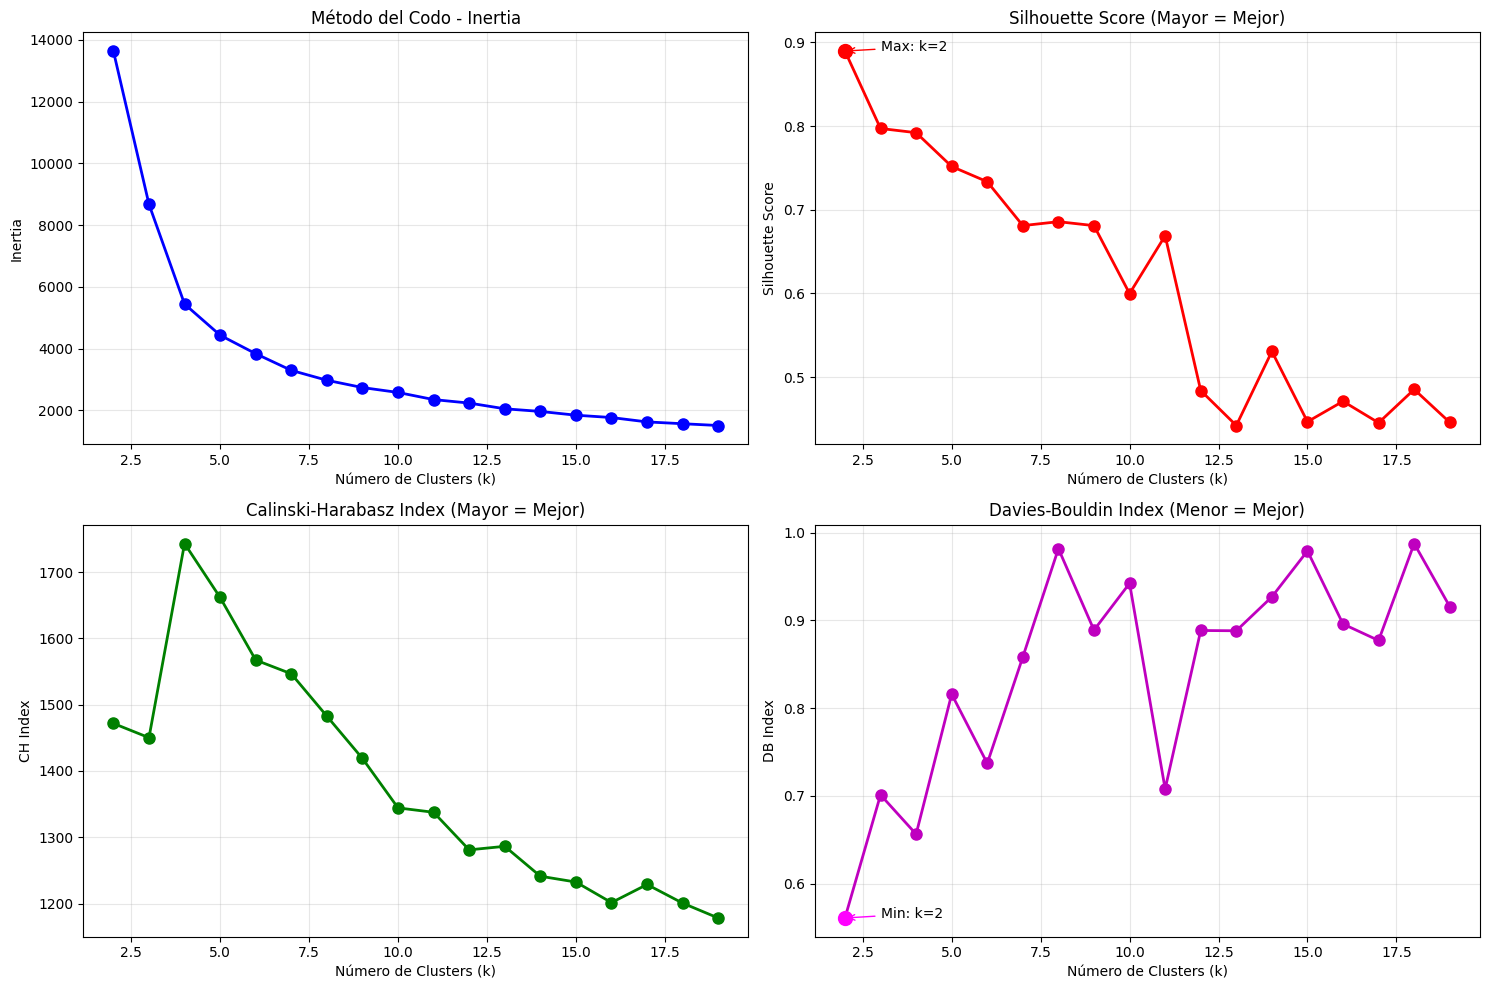


RECOMENDACIONES DE NÚMERO DE CLUSTERS
🎯 Silhouette Score (cohesión-separación): k = 2
📊 Calinski-Harabasz (varianza inter/intra): k = 4
📉 Davies-Bouldin (compacidad): k = 2
💪 Método del Codo: k = 5

🏆 CONSENSO RECOMENDADO: k = 2

Entrenando modelo final con 2 clusters...
✅ Entrenamiento completado!
   Silhouette Score: 0.890
   Calinski-Harabasz: 1471.8
   Davies-Bouldin: 0.561

Visualizando resultados...


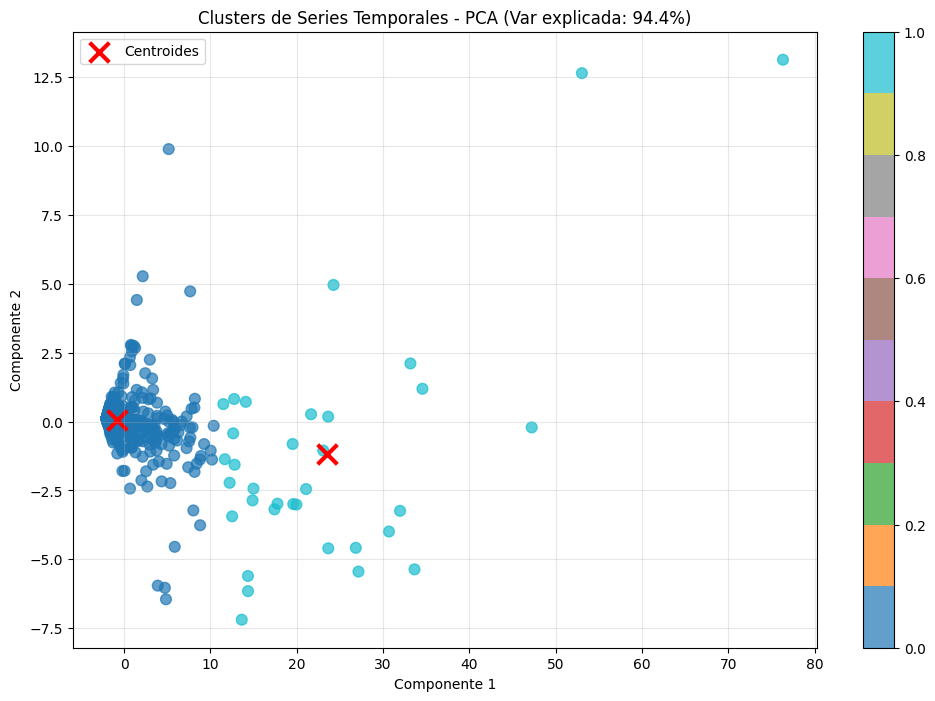

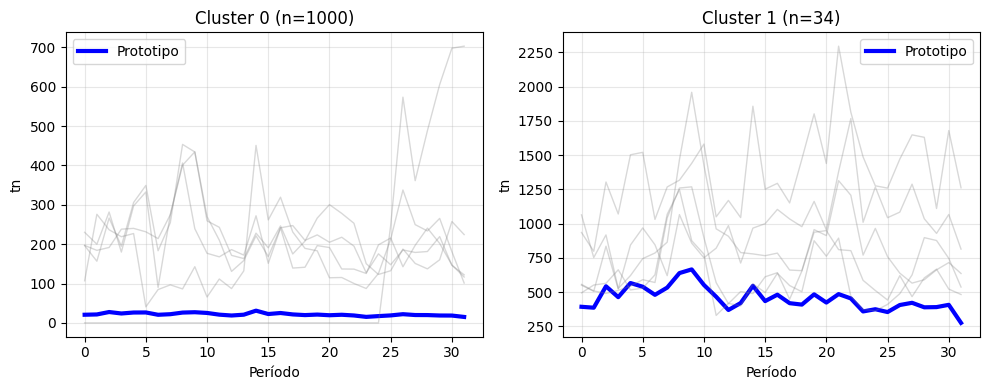

In [27]:
# Suponiendo que tu DataFrame tiene columnas: periodo, product_id, tn
vq_model, results_df, cluster_stats, recommendations = analyze_time_series_clusters(
    df=df_agg,                    # Tu DataFrame
    min_periods=6,            # Mínimo 6 períodos por producto
    k_range=range(2, 20),     # Probar de 2 a 15 clusters
    normalization='standard', # Normalización estándar
    auto_fit=True            # Ajustar automáticamente con k óptimo
)

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

class TimeSeriesVectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # Diccionario: K vectores de D dimensiones
        self.embeddings = nn.Parameter(torch.randn(num_embeddings, embedding_dim) * 0.1)
        
    def forward(self, z):
        """
        z: Tensor (B, D) — series temporales de entrada
        returns:
          - z_q: cuantizado (B, D)
          - vq_loss: pérdida de cuantización
          - commitment_loss: pérdida de compromiso
          - indices: (B,) índices de embeddings asignados
        """
        B, D = z.shape
        
        # Calcular distancia euclídea a cada vector del codebook
        z_flattened = z.view(-1, self.embedding_dim)
        
        # Broadcasting para calcular distancias
        distances = torch.sum((z_flattened.unsqueeze(1) - self.embeddings.unsqueeze(0)) ** 2, dim=2)
        
        # Obtener el índice del embedding más cercano
        encoding_indices = torch.argmin(distances, dim=1)
        quantized = self.embeddings[encoding_indices].view(B, D)
        
        # Pérdidas
        vq_loss = F.mse_loss(quantized.detach(), z)  # Actualiza embeddings
        commitment_loss = F.mse_loss(quantized, z.detach())  # Actualiza encoder
        total_loss = vq_loss + self.commitment_cost * commitment_loss
        
        # Straight-through estimator
        quantized = z + (quantized - z).detach()
        
        return quantized, total_loss, vq_loss, commitment_loss, encoding_indices

class TimeSeriesDataset(Dataset):
    """Dataset para series temporales"""
    def __init__(self, df, min_periods=6, scaler=None):
        """
        df: DataFrame con columnas ['periodo', 'product_id', 'tn']
        """
        self.prepare_data(df, min_periods, scaler)
    
    def prepare_data(self, df, min_periods, scaler):
        print("Preparando dataset de series temporales...")
        
        # Crear matriz pivot
        pivot_df = df.pivot(index='periodo', columns='product_id', values='tn')
        
        # Filtrar productos con suficientes datos
        valid_products = pivot_df.columns[pivot_df.count() >= min_periods]
        clean_data = pivot_df[valid_products].fillna(0)
        
        print(f"Productos válidos: {len(valid_products)} de {len(pivot_df.columns)}")
        print(f"Períodos: {len(clean_data)}")
        
        # Transponer: productos x períodos
        self.series_matrix = clean_data.T
        self.product_ids = valid_products.values
        
        # Normalización
        if scaler is None:
            self.scaler = StandardScaler()
            self.series_normalized = self.scaler.fit_transform(self.series_matrix)
        else:
            self.scaler = scaler
            self.series_normalized = scaler.transform(self.series_matrix)
        
        # Convertir a tensores
        self.data = torch.FloatTensor(self.series_normalized)
        
        print(f"Forma final del dataset: {self.data.shape}")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.product_ids[idx], idx

class TimeSeriesVQTrainer:
    def __init__(self, num_embeddings_range=range(4, 21), embedding_dim=None, 
                 commitment_cost=0.25, device='cuda'):
        self.num_embeddings_range = num_embeddings_range
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.device = device if torch.cuda.is_available() else 'cpu'
        self.models = {}
        self.training_histories = {}
        
    def prepare_data(self, df, min_periods=6, batch_size=64, train_split=0.8):
        """Prepara datos de entrenamiento y validación"""
        
        # Crear dataset completo
        dataset = TimeSeriesDataset(df, min_periods)
        
        # División train/val
        n_samples = len(dataset)
        n_train = int(n_samples * train_split)
        
        train_indices = torch.randperm(n_samples)[:n_train]
        val_indices = torch.randperm(n_samples)[n_train:]
        
        train_dataset = torch.utils.data.Subset(dataset, train_indices)
        val_dataset = torch.utils.data.Subset(dataset, val_indices)
        
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Inferir embedding_dim si no se especifica
        if self.embedding_dim is None:
            self.embedding_dim = dataset.data.shape[1]
        
        self.dataset = dataset
        print(f"Datos preparados - Train: {len(train_dataset)}, Val: {len(val_dataset)}")
        print(f"Dimensión de embedding: {self.embedding_dim}")
        
        return self
    
    def train_single_model(self, num_embeddings, epochs=50, lr=1e-3, verbose=True):
        """Entrena un modelo VQ con número específico de embeddings"""
        
        # Crear modelo
        model = TimeSeriesVectorQuantizer(
            num_embeddings=num_embeddings,
            embedding_dim=self.embedding_dim,
            commitment_cost=self.commitment_cost
        ).to(self.device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # Historial de entrenamiento
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_vq_loss': [],
            'val_vq_loss': [],
            'train_commitment_loss': [],
            'val_commitment_loss': []
        }
        
        if verbose:
            print(f"\nEntrenando modelo con {num_embeddings} embeddings...")
        
        for epoch in range(epochs):
            # Entrenamiento
            model.train()
            train_losses = {'total': [], 'vq': [], 'commitment': []}
            
            for series, _, _ in self.train_loader:
                series = series.to(self.device)
                
                optimizer.zero_grad()
                z_q, total_loss, vq_loss, commitment_loss, indices = model(series)
                total_loss.backward()
                optimizer.step()
                
                train_losses['total'].append(total_loss.item())
                train_losses['vq'].append(vq_loss.item())
                train_losses['commitment'].append(commitment_loss.item())
            
            # Validación
            model.eval()
            val_losses = {'total': [], 'vq': [], 'commitment': []}
            
            with torch.no_grad():
                for series, _, _ in self.val_loader:
                    series = series.to(self.device)
                    z_q, total_loss, vq_loss, commitment_loss, indices = model(series)
                    
                    val_losses['total'].append(total_loss.item())
                    val_losses['vq'].append(vq_loss.item())
                    val_losses['commitment'].append(commitment_loss.item())
            
            # Guardar historial
            history['train_loss'].append(np.mean(train_losses['total']))
            history['val_loss'].append(np.mean(val_losses['total']))
            history['train_vq_loss'].append(np.mean(train_losses['vq']))
            history['val_vq_loss'].append(np.mean(val_losses['vq']))
            history['train_commitment_loss'].append(np.mean(train_losses['commitment']))
            history['val_commitment_loss'].append(np.mean(val_losses['commitment']))
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Época {epoch+1}/{epochs} - "
                      f"Train Loss: {history['train_loss'][-1]:.4f}, "
                      f"Val Loss: {history['val_loss'][-1]:.4f}")
        
        return model, history
    
    def find_optimal_embeddings(self, epochs=50, lr=1e-3):
        """Entrena modelos con diferentes números de embeddings para encontrar el óptimo"""
        
        print("Buscando número óptimo de embeddings...")
        results = []
        
        for num_embeddings in tqdm(self.num_embeddings_range):
            model, history = self.train_single_model(
                num_embeddings=num_embeddings,
                epochs=epochs,
                lr=lr,
                verbose=False
            )
            
            # Evaluar modelo
            final_val_loss = history['val_loss'][-1]
            final_train_loss = history['train_loss'][-1]
            overfitting = final_val_loss - final_train_loss
            
            # Calcular utilización de embeddings
            utilization = self.calculate_embedding_utilization(model)
            
            results.append({
                'num_embeddings': num_embeddings,
                'val_loss': final_val_loss,
                'train_loss': final_train_loss,
                'overfitting': overfitting,
                'embedding_utilization': utilization,
                'model': model,
                'history': history
            })
            
            self.models[num_embeddings] = model
            self.training_histories[num_embeddings] = history
        
        self.optimization_results = results
        self.plot_optimization_results()
        
        return results
    
    def calculate_embedding_utilization(self, model):
        """Calcula qué porcentaje de embeddings se están usando"""
        model.eval()
        used_embeddings = set()
        
        with torch.no_grad():
            for series, _, _ in self.val_loader:
                series = series.to(self.device)
                _, _, _, _, indices = model(series)
                used_embeddings.update(indices.cpu().numpy())
        
        utilization = len(used_embeddings) / model.num_embeddings
        return utilization
    
    def plot_optimization_results(self):
        """Visualiza resultados de optimización"""
        if not hasattr(self, 'optimization_results'):
            return
        
        results_df = pd.DataFrame(self.optimization_results)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Pérdida de validación
        axes[0,0].plot(results_df['num_embeddings'], results_df['val_loss'], 'bo-', linewidth=2)
        axes[0,0].set_title('Pérdida de Validación')
        axes[0,0].set_xlabel('Número de Embeddings')
        axes[0,0].set_ylabel('Validation Loss')
        axes[0,0].grid(True, alpha=0.3)
        
        # Marcar mínimo
        min_idx = results_df['val_loss'].idxmin()
        min_k = results_df.loc[min_idx, 'num_embeddings']
        min_loss = results_df.loc[min_idx, 'val_loss']
        axes[0,0].scatter(min_k, min_loss, color='red', s=100, zorder=5)
        axes[0,0].annotate(f'Min: k={min_k}', xy=(min_k, min_loss), 
                          xytext=(min_k+1, min_loss), 
                          arrowprops=dict(arrowstyle='->', color='red'))
        
        # 2. Overfitting (diferencia train-val)
        axes[0,1].plot(results_df['num_embeddings'], results_df['overfitting'], 'ro-', linewidth=2)
        axes[0,1].set_title('Overfitting (Val Loss - Train Loss)')
        axes[0,1].set_xlabel('Número de Embeddings')
        axes[0,1].set_ylabel('Overfitting')
        axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Utilización de embeddings
        axes[1,0].plot(results_df['num_embeddings'], results_df['embedding_utilization'], 'go-', linewidth=2)
        axes[1,0].set_title('Utilización de Embeddings')
        axes[1,0].set_xlabel('Número de Embeddings')
        axes[1,0].set_ylabel('% Embeddings Utilizados')
        axes[1,0].set_ylim(0, 1.1)
        axes[1,0].grid(True, alpha=0.3)
        
        # 4. Trade-off: Loss vs Utilización
        scatter = axes[1,1].scatter(results_df['embedding_utilization'], results_df['val_loss'], 
                                   c=results_df['num_embeddings'], cmap='viridis', s=80)
        axes[1,1].set_title('Trade-off: Utilización vs Pérdida')
        axes[1,1].set_xlabel('Utilización de Embeddings')
        axes[1,1].set_ylabel('Validation Loss')
        axes[1,1].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[1,1], label='Num Embeddings')
        
        plt.tight_layout()
        plt.show()
        
        # Recomendaciones
        #self.print_recommendations(results_df)
    
    def print_recommendations(self, results_df):
        """Imprime recomendaciones basadas en los resultados"""
        
        # Criterios diferentes
        min_val_loss_idx = results_df['val_loss'].idxmin()
        best_utilization_idx = results_df.loc[results_df['embedding_utilization'] > 0.7]['val_loss'].idxmin()
        
        print("\n" + "="*60)
        print("RECOMENDACIONES DE NÚMERO DE EMBEDDINGS")
        print("="*60)
        
        print(f"🎯 Menor pérdida de validación:")
        print(f"   k = {results_df.loc[min_val_loss_idx, 'num_embeddings']} "
              f"(loss: {results_df.loc[min_val_loss_idx, 'val_loss']:.4f}, "
              f"utilización: {results_df.loc[min_val_loss_idx, 'embedding_utilization']:.1%})")
        
        if not pd.isna(best_utilization_idx):
            print(f"⚖️ Mejor balance pérdida-utilización:")
            print(f"   k = {results_df.loc[best_utilization_idx, 'num_embeddings']} "
                  f"(loss: {results_df.loc[best_utilization_idx, 'val_loss']:.4f}, "
                  f"utilización: {results_df.loc[best_utilization_idx, 'embedding_utilization']:.1%})")
        
        # Detectar punto de codo
        losses = results_df['val_loss'].values
        k_values = results_df['num_embeddings'].values
        
        # Segunda derivada para encontrar codo
        if len(losses) > 2:
            second_diff = np.diff(losses, 2)
            elbow_idx = np.argmax(second_diff) + 2
            if elbow_idx < len(k_values):
                print(f"💪 Método del codo:")
                print(f"   k = {k_values[elbow_idx]} "
                      f"(loss: {losses[elbow_idx]:.4f}, "
                      f"utilización: {results_df.iloc[elbow_idx]['embedding_utilization']:.1%})")
        
        print("="*60)
    
    def get_best_model(self, criterion='val_loss'):
        """Obtiene el mejor modelo según el criterio especificado"""
        if not hasattr(self, 'optimization_results'):
            raise ValueError("Primero ejecuta find_optimal_embeddings()")
        
        results_df = pd.DataFrame(self.optimization_results)
        
        if criterion == 'val_loss':
            best_idx = results_df['val_loss'].idxmin()
        elif criterion == 'utilization':
            # Mejor pérdida entre modelos con >70% utilización
            high_util = results_df[results_df['embedding_utilization'] > 0.7]
            if len(high_util) > 0:
                best_idx = high_util['val_loss'].idxmin()
            else:
                best_idx = results_df['val_loss'].idxmin()
        
        best_result = results_df.iloc[best_idx]
        return best_result['model'], best_result
    
    def analyze_clusters(self, model=None):
        """Analiza los clusters encontrados por el modelo"""
        if model is None:
            model, _ = self.get_best_model()
        
        model.eval()
        all_indices = []
        all_products = []
        all_series = []
        
        with torch.no_grad():
            for series, products, _ in DataLoader(self.dataset, batch_size=128):
                series = series.to(self.device)
                _, _, _, _, indices = model(series)
                all_indices.extend(indices.cpu().numpy())
                all_products.extend(products)
                all_series.extend(series.cpu().numpy())
        
        # Crear DataFrame de resultados
        results_df = pd.DataFrame({
            'product_id': all_products,
            'cluster': all_indices
        })
        
        # Estadísticas por cluster
        cluster_stats = []
        for cluster_id in range(model.num_embeddings):
            mask = np.array(all_indices) == cluster_id
            if mask.sum() == 0:
                continue
                
            cluster_series = np.array(all_series)[mask]
            cluster_products = np.array(all_products)[mask]
            
            # Calcular estadísticas (des-normalizar primero)
            original_series = self.dataset.scaler.inverse_transform(cluster_series)
            
            stats = {
                'cluster': cluster_id,
                'size': len(cluster_products),
                'avg_total': original_series.sum(axis=1).mean(),
                'avg_volatility': original_series.std(axis=1).mean(),
                'products': list(cluster_products)
            }
            cluster_stats.append(stats)
        
        return results_df, cluster_stats
    
    def plot_cluster_prototypes(self, model=None, max_clusters=12):
        """Visualiza prototipos de clusters"""
        if model is None:
            model, _ = self.get_best_model()
        
        # Des-normalizar prototipos
        prototypes_normalized = model.embeddings.detach().cpu().numpy()
        prototypes = self.dataset.scaler.inverse_transform(prototypes_normalized)
        
        # Calcular cuántos clusters están siendo usados
        _, cluster_stats = self.analyze_clusters(model)
        used_clusters = [stat['cluster'] for stat in cluster_stats]
        used_clusters = sorted(used_clusters)[:max_clusters]
        
        # Crear subplots
        n_clusters = len(used_clusters)
        cols = min(3, n_clusters)
        rows = (n_clusters + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
        
        if n_clusters == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes.flatten()
        else:
            axes = axes.flatten()
        
        for i, cluster_id in enumerate(used_clusters):
            ax = axes[i]
            
            # Plotear prototipo
            periods = range(len(prototypes[cluster_id]))
            ax.plot(periods, prototypes[cluster_id], 'b-', linewidth=3, label='Prototipo')
            
            # Agregar ejemplos del cluster
            cluster_stat = next(s for s in cluster_stats if s['cluster'] == cluster_id)
            
            ax.set_title(f'Cluster {cluster_id} (n={cluster_stat["size"]})')
            ax.set_xlabel('Período')
            ax.set_ylabel('tn')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        # Ocultar axes no usados
        for i in range(n_clusters, len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()

# FUNCIÓN DE USO PRINCIPAL
def train_timeseries_vq(df, num_embeddings_range=range(30, 81), min_periods=6, 
                       epochs=80, batch_size=64, commitment_cost=0.50):
    """
    Función principal para entrenar VQ en series temporales
    
    Returns:
        trainer: objeto entrenador con todos los modelos
        best_model: mejor modelo encontrado
        results_df: DataFrame con asignaciones de clusters
        cluster_stats: estadísticas por cluster
    """
    
    # Inicializar trainer
    trainer = TimeSeriesVQTrainer(
        num_embeddings_range=num_embeddings_range,
        commitment_cost=commitment_cost
    )
    
    # Preparar datos
    trainer.prepare_data(df, min_periods=min_periods, batch_size=batch_size)
    
    # Buscar número óptimo
    optimization_results = trainer.find_optimal_embeddings(epochs=epochs)
    
    # Obtener mejor modelo
    best_model, best_result = trainer.get_best_model()
    
    print(f"\n🏆 MEJOR MODELO: {best_result['num_embeddings']} embeddings")
    print(f"   Validation Loss: {best_result['val_loss']:.4f}")
    print(f"   Utilización: {best_result['embedding_utilization']:.1%}")
    
    # Analizar clusters
    results_df, cluster_stats = trainer.analyze_clusters(best_model)
    
    # Visualizar prototipos
    print("\nVisualizando prototipos...")
    trainer.plot_cluster_prototypes(best_model,results_df['cluster'].nunique())
    
    return trainer, best_model, results_df, cluster_stats

# EJEMPLO DE USO:
# trainer, best_model, results_df, cluster_stats = train_timeseries_vq(df_agg)

In [11]:
import os

In [15]:
pathdata='data/'
filename = 'sell-in.txt'

    # Unir ruta completa
filepath = os.path.join(pathdata, filename)
sell = pd.read_csv(filepath, sep="\t")
    
df_agg = sell.groupby(['periodo', 'product_id'], as_index=False).agg({
'tn': 'sum'
})
df_agg= df_agg[df_agg['periodo'] <= 201908].copy()

Preparando dataset de series temporales...
Productos válidos: 1034 de 1181
Períodos: 32
Forma final del dataset: torch.Size([1034, 32])
Datos preparados - Train: 827, Val: 207
Dimensión de embedding: 32
Buscando número óptimo de embeddings...


100%|██████████| 51/51 [01:50<00:00,  2.17s/it]


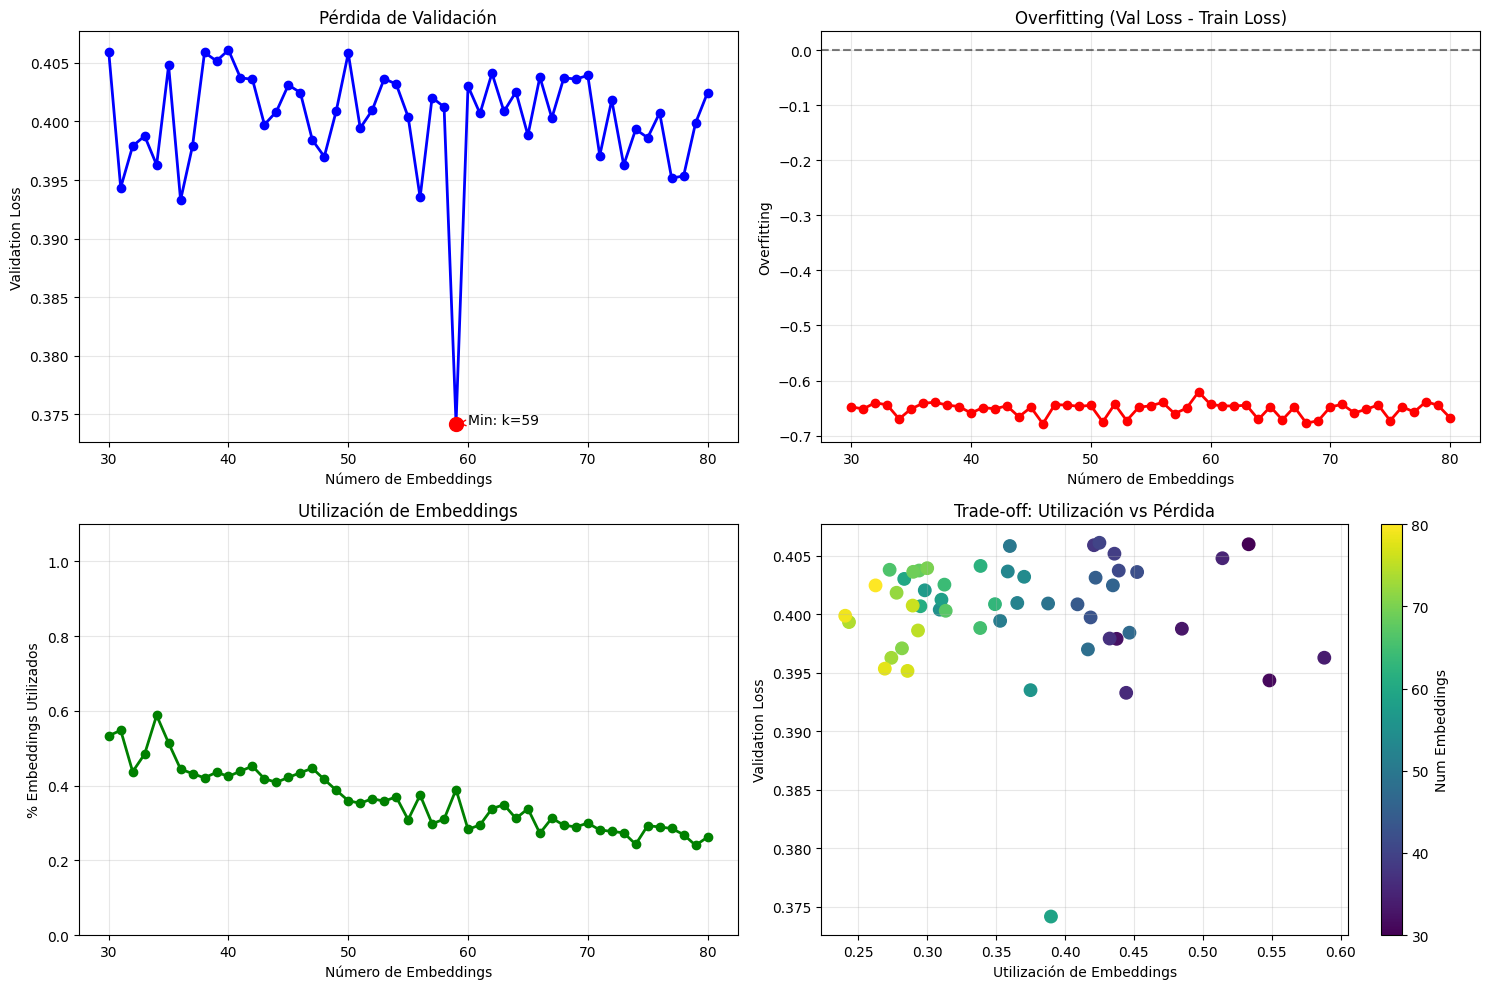


🏆 MEJOR MODELO: 59 embeddings
   Validation Loss: 0.3742
   Utilización: 39.0%

Visualizando prototipos...


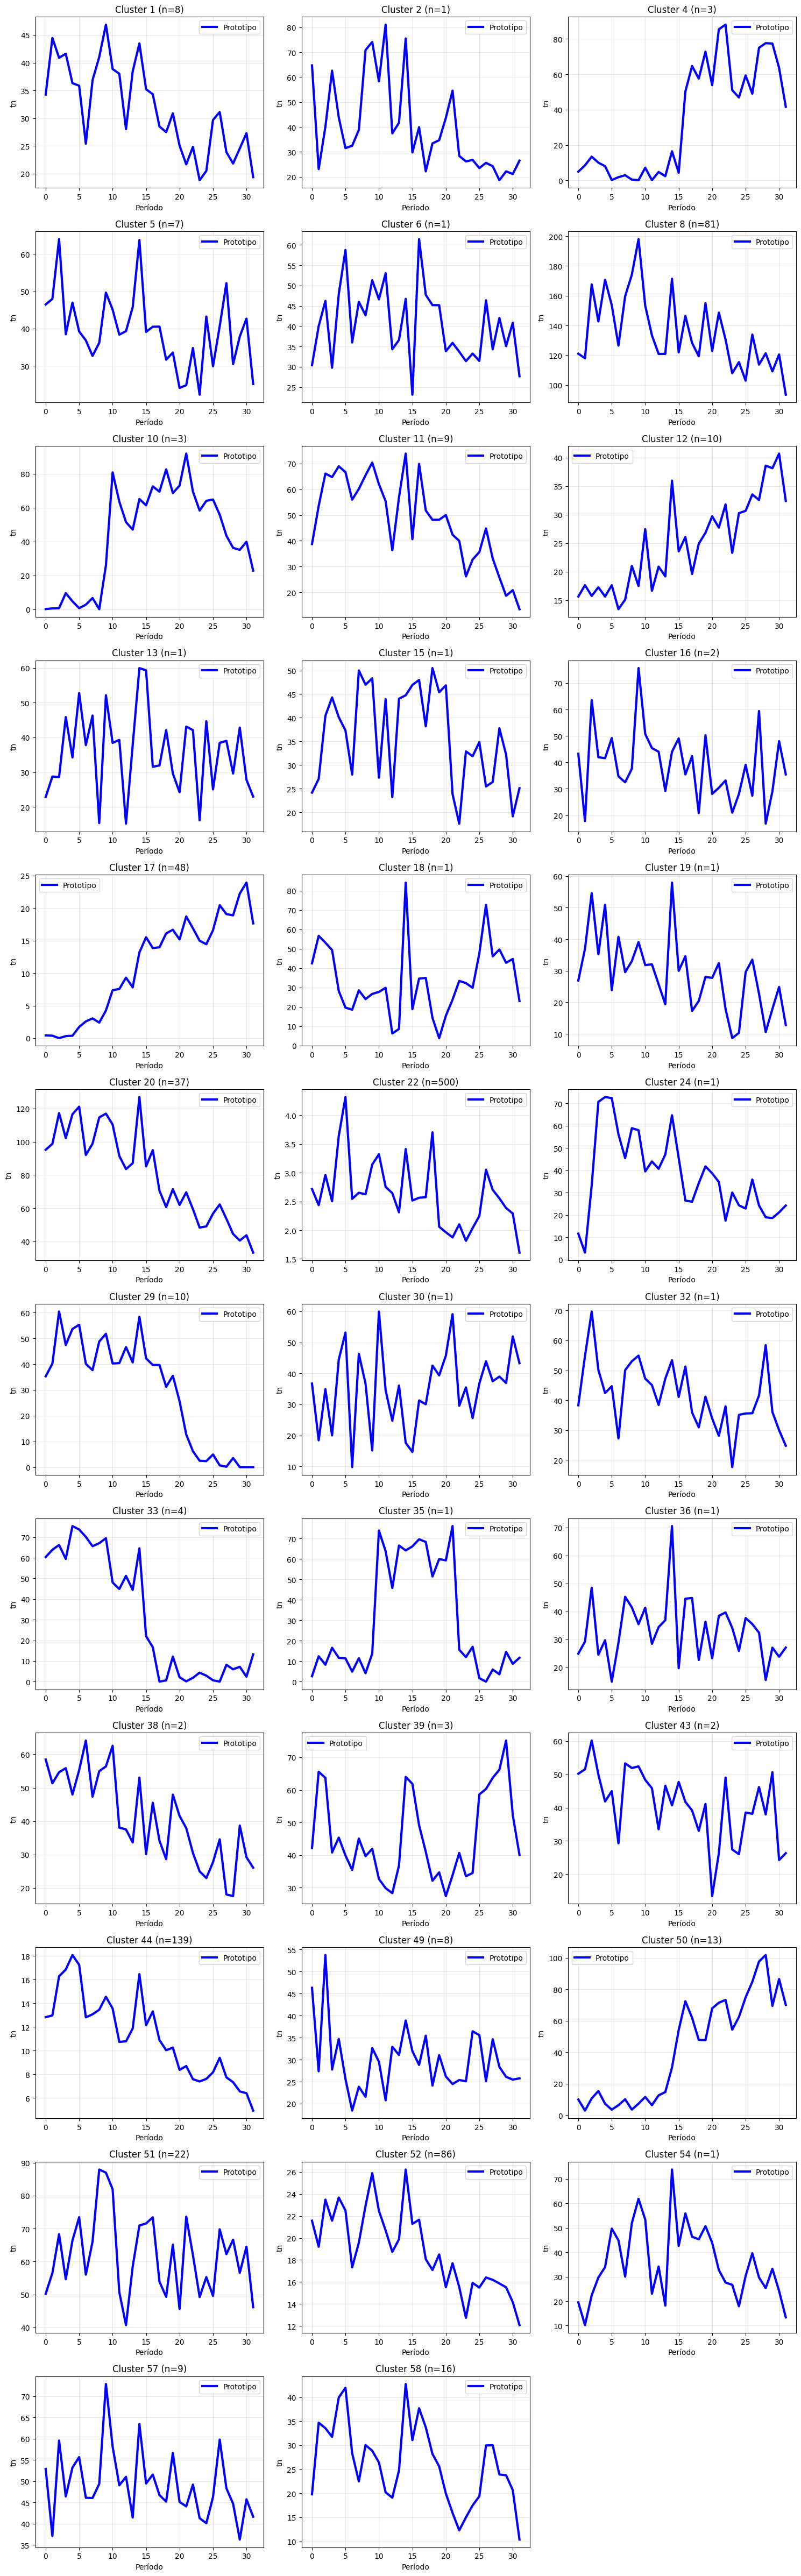

In [16]:
trainer, best_model, results_df_e, cluster_stats = train_timeseries_vq(df_agg)

In [17]:
results_df_e.to_csv("clusters/qv_euc_agosto19.csv", index=False)

In [10]:
# Ver estadísticas por cluster
for stats in cluster_stats:
    print(f"\nCluster {stats['cluster']}:")
    print(f"  Productos: {stats['size']}")
    print(f"  Volumen promedio total: {stats['avg_total']:.1f}")
    print(f"  Volatilidad promedio: {stats['avg_volatility']:.2f}")
    print(f"  Ejemplos: {stats['products'][:3]}")

# Ver asignaciones específicas
#product_clusters = dict(zip(results_df['product_id'], results_df['cluster']))


Cluster 1:
  Productos: 4
  Volumen promedio total: 1792.5
  Volatilidad promedio: 16.93
  Ejemplos: [20145, 20158, 20161]

Cluster 3:
  Productos: 14
  Volumen promedio total: 652.0
  Volatilidad promedio: 14.60
  Ejemplos: [20293, 20304, 20325]

Cluster 4:
  Productos: 9
  Volumen promedio total: 2732.1
  Volatilidad promedio: 78.25
  Ejemplos: [20098, 20104, 20110]

Cluster 5:
  Productos: 7
  Volumen promedio total: 973.3
  Volatilidad promedio: 13.40
  Ejemplos: [20162, 20196, 20202]

Cluster 12:
  Productos: 7
  Volumen promedio total: 1000.3
  Volatilidad promedio: 23.58
  Ejemplos: [20221, 20243, 20245]

Cluster 13:
  Productos: 10
  Volumen promedio total: 969.8
  Volatilidad promedio: 9.71
  Ejemplos: [20219, 20220, 20222]

Cluster 14:
  Productos: 77
  Volumen promedio total: 640.4
  Volatilidad promedio: 6.32
  Ejemplos: [20225, 20230, 20239]

Cluster 19:
  Productos: 85
  Volumen promedio total: 9225.4
  Volatilidad promedio: 92.07
  Ejemplos: [20001, 20002, 20003]

Clust

# DTW Revisar

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dtaidistance import dtw
from dtaidistance import dtw_ndim
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class DTWVectorQuantizer:
    """Vector Quantizer usando distancia DTW para series temporales"""
    
    def __init__(self, num_embeddings, window=None, use_c=True):
        """
        num_embeddings: número de prototipos
        window: ventana DTW (None = sin restricción)
        use_c: usar implementación en C (más rápida)
        """
        self.num_embeddings = num_embeddings
        self.window = window
        self.use_c = use_c
        self.embeddings = None
        self.fitted = False
        
    def _calculate_dtw_distance(self, series1, series2):
        """Calcula distancia DTW entre dos series"""
        try:
            if self.use_c:
                distance = dtw.distance(series1, series2, window=self.window)
            else:
                distance = dtw.distance_fast(series1, series2, window=self.window)
            return distance
        except:
            # Fallback a distancia euclidiana si DTW falla
            return np.sqrt(np.sum((series1 - series2) ** 2))
    
    def _calculate_dtw_distances_batch(self, series, prototypes):
        """Calcula distancias DTW de una serie a todos los prototipos"""
        distances = []
        for prototype in prototypes:
            dist = self._calculate_dtw_distance(series, prototype)
            distances.append(dist)
        return np.array(distances)
    
    def fit(self, X, max_iter=100, init_method='kmeans', verbose=True):
        """
        Entrena el VQ usando DTW
        
        X: array (n_samples, n_timesteps) - series temporales
        max_iter: máximo número de iteraciones
        init_method: 'kmeans', 'random', 'kmeans++'
        """
        
        n_samples, n_timesteps = X.shape
        
        if verbose:
            print(f"Entrenando DTW-VQ con {self.num_embeddings} prototipos...")
            print(f"Datos: {n_samples} series de {n_timesteps} puntos")
        
        # Inicialización de prototipos
        if init_method == 'kmeans':
            # Usar K-means con distancia euclidiana para inicializar
            kmeans = KMeans(n_clusters=self.num_embeddings, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X)
            self.embeddings = kmeans.cluster_centers_.copy()
        elif init_method == 'random':
            # Seleccionar muestras aleatorias
            random_indices = np.random.choice(n_samples, self.num_embeddings, replace=False)
            self.embeddings = X[random_indices].copy()
        elif init_method == 'kmeans++':
            # K-means++ initialization adaptado para DTW
            self.embeddings = self._kmeans_plus_plus_dtw(X)
        
        # Algoritmo Lloyd con DTW
        for iteration in range(max_iter):
            old_embeddings = self.embeddings.copy()
            
            # E-step: Asignar cada serie al prototipo más cercano (DTW)
            labels = self._assign_to_closest_prototype(X, verbose and iteration % 10 == 0)
            
            # M-step: Actualizar prototipos usando DTW Barycenter Averaging (DBA)
            self._update_prototypes_dba(X, labels)
            
            # Verificar convergencia
            if self._has_converged(old_embeddings, self.embeddings):
                if verbose:
                    print(f"Convergencia alcanzada en iteración {iteration + 1}")
                break
        
        self.fitted = True
        
        if verbose:
            print("✅ Entrenamiento completado!")
            self._print_cluster_utilization(labels)
        
        return self
    
    def _kmeans_plus_plus_dtw(self, X):
        """Inicialización K-means++ usando distancia DTW"""
        n_samples = len(X)
        centroids = []
        
        # Primer centroide aleatorio
        centroids.append(X[np.random.randint(n_samples)])
        
        for _ in range(1, self.num_embeddings):
            # Calcular distancia de cada punto al centroide más cercano
            distances = []
            for point in X:
                min_dist = float('inf')
                for centroid in centroids:
                    dist = self._calculate_dtw_distance(point, centroid)
                    min_dist = min(min_dist, dist)
                distances.append(min_dist)
            
            # Seleccionar siguiente centroide con probabilidad proporcional a distancia²
            distances = np.array(distances)
            probabilities = distances ** 2
            probabilities /= probabilities.sum()
            
            next_centroid_idx = np.random.choice(n_samples, p=probabilities)
            centroids.append(X[next_centroid_idx])
        
        return np.array(centroids)
    
    def _assign_to_closest_prototype(self, X, verbose=False):
        """Asigna cada serie al prototipo más cercano usando DTW"""
        labels = np.zeros(len(X), dtype=int)
        
        iterator = tqdm(enumerate(X), total=len(X), desc="Asignando series") if verbose else enumerate(X)
        
        for i, series in iterator:
            distances = self._calculate_dtw_distances_batch(series, self.embeddings)
            labels[i] = np.argmin(distances)
        
        return labels
    
    def _update_prototypes_dba(self, X, labels):
        """Actualiza prototipos usando DBA (DTW Barycenter Averaging)"""
        for k in range(self.num_embeddings):
            cluster_series = X[labels == k]
            
            if len(cluster_series) == 0:
                continue
            
            if len(cluster_series) == 1:
                self.embeddings[k] = cluster_series[0]
            else:
                # DBA: algoritmo iterativo para encontrar el baricentro DTW
                self.embeddings[k] = self._dtw_barycenter_averaging(cluster_series)
    
    def _dtw_barycenter_averaging(self, series_list, max_iter=10):
        """
        DTW Barycenter Averaging (DBA) - encuentra la serie "promedio" usando DTW
        Implementación simplificada
        """
        if len(series_list) == 1:
            return series_list[0]
        
        # Inicializar con el promedio aritmético
        barycenter = np.mean(series_list, axis=0)
        
        for _ in range(max_iter):
            # Para cada posición en el baricentro, encontrar valores alineados
            aligned_values = [[] for _ in range(len(barycenter))]
            
            for series in series_list:
                # Calcular alineamiento DTW entre baricentro y serie
                try:
                    path = dtw.warping_path(barycenter, series, window=self.window)
                    
                    # Agrupar valores por posición en el baricentro
                    for i, j in path:
                        aligned_values[i].append(series[j])
                except:
                    # Fallback: alineamiento lineal
                    for i, val in enumerate(series):
                        if i < len(aligned_values):
                            aligned_values[i].append(val)
            
            # Actualizar baricentro con promedio de valores alineados
            old_barycenter = barycenter.copy()
            for i, values in enumerate(aligned_values):
                if values:
                    barycenter[i] = np.mean(values)
            
            # Verificar convergencia
            if np.allclose(old_barycenter, barycenter, rtol=1e-4):
                break
        
        return barycenter
    
    def _has_converged(self, old_embeddings, new_embeddings, tolerance=1e-4):
        """Verifica si el algoritmo ha convergido"""
        total_change = 0
        for old, new in zip(old_embeddings, new_embeddings):
            total_change += np.sum((old - new) ** 2)
        return total_change < tolerance
    
    def _print_cluster_utilization(self, labels):
        """Imprime estadísticas de utilización de clusters"""
        unique_labels = np.unique(labels)
        utilization = len(unique_labels) / self.num_embeddings
        
        print(f"Clusters utilizados: {len(unique_labels)}/{self.num_embeddings} ({utilization:.1%})")
        
        for label in unique_labels:
            count = np.sum(labels == label)
            print(f"  Cluster {label}: {count} series")
    
    def predict(self, X):
        """Predice asignaciones de cluster para nuevas series"""
        if not self.fitted:
            raise ValueError("El modelo debe ser entrenado primero")
        
        labels = self._assign_to_closest_prototype(X)
        return labels
    
    def transform(self, X):
        """Transforma series a su prototipo más cercano"""
        labels = self.predict(X)
        return self.embeddings[labels]
    
    def get_cluster_distances(self, X):
        """Obtiene matriz de distancias de cada serie a cada prototipo"""
        distances = np.zeros((len(X), self.num_embeddings))
        
        for i, series in enumerate(tqdm(X, desc="Calculando distancias")):
            distances[i] = self._calculate_dtw_distances_batch(series, self.embeddings)
        
        return distances

class DTWTimeSeriesAnalyzer:
    """Analizador completo para series temporales con DTW-VQ"""
    
    def __init__(self, df, min_periods=6, scaler=None):
        """
        df: DataFrame con columnas ['periodo', 'product_id', 'tn']
        """
        self.prepare_data(df, min_periods, scaler)
        
    def prepare_data(self, df, min_periods, scaler):
        """Prepara datos para análisis DTW"""
        print("Preparando datos para análisis DTW...")
        
        # Crear matriz pivot
        pivot_df = df.pivot(index='periodo', columns='product_id', values='tn')
        
        # Filtrar productos con suficientes datos
        valid_products = pivot_df.columns[pivot_df.count() >= min_periods]
        clean_data = pivot_df[valid_products].fillna(0)
        
        print(f"Productos válidos: {len(valid_products)} de {len(pivot_df.columns)}")
        print(f"Períodos: {len(clean_data)}")
        
        # Transponer: productos x períodos
        self.series_matrix = clean_data.T
        self.product_ids = valid_products.values
        
        # Normalización opcional
        if scaler is None:
            self.scaler = StandardScaler()
            self.series_normalized = self.scaler.fit_transform(self.series_matrix)
        else:
            self.scaler = scaler
            self.series_normalized = scaler.transform(self.series_matrix)
        
        print(f"Forma de datos: {self.series_normalized.shape}")
    
    def find_optimal_clusters_dtw(self, k_range=range(3, 16), window=None, 
                                 max_iter=50, init_method='kmeans'):
        """Encuentra número óptimo de clusters usando DTW"""
        
        print("Optimizando número de clusters con DTW...")
        results = []
        
        for k in tqdm(k_range, desc="Probando diferentes k"):
            # Entrenar modelo DTW-VQ
            vq = DTWVectorQuantizer(num_embeddings=k, window=window)
            vq.fit(self.series_normalized, max_iter=max_iter, 
                  init_method=init_method, verbose=False)
            
            # Calcular métricas
            labels = vq.predict(self.series_normalized)
            
            # Inertia DTW (suma de distancias DTW al centroide)
            dtw_inertia = self._calculate_dtw_inertia(self.series_normalized, labels, vq.embeddings)
            
            # Silhouette score adaptado para DTW
            silhouette_dtw = self._calculate_dtw_silhouette(self.series_normalized, labels, vq.embeddings)
            
            # Utilización de clusters
            utilization = len(np.unique(labels)) / k
            
            results.append({
                'k': k,
                'dtw_inertia': dtw_inertia,
                'silhouette_dtw': silhouette_dtw,
                'utilization': utilization,
                'model': vq
            })
        
        self.optimization_results = results
        self.plot_dtw_optimization()
        
        return results
    
    def _calculate_dtw_inertia(self, X, labels, centroids):
        """Calcula inercia usando distancia DTW"""
        total_inertia = 0
        for i, series in enumerate(X):
            centroid_idx = labels[i]
            distance = dtw.distance(series, centroids[centroid_idx])
            total_inertia += distance ** 2
        return total_inertia
    
    def _calculate_dtw_silhouette(self, X, labels, centroids):
        """Calcula silhouette score usando distancia DTW (simplificado)"""
        if len(np.unique(labels)) < 2:
            return 0
        
        silhouette_scores = []
        
        # Muestrear para hacer el cálculo más rápido
        sample_size = min(100, len(X))
        sample_indices = np.random.choice(len(X), sample_size, replace=False)
        
        for idx in sample_indices:
            series = X[idx]
            cluster = labels[idx]
            
            # a: distancia promedio dentro del cluster
            same_cluster = X[labels == cluster]
            if len(same_cluster) > 1:
                a = np.mean([dtw.distance(series, other) for other in same_cluster if not np.array_equal(series, other)])
            else:
                a = 0
            
            # b: distancia promedio al cluster más cercano
            other_clusters = [c for c in np.unique(labels) if c != cluster]
            if other_clusters:
                b_scores = []
                for other_cluster in other_clusters:
                    other_series = X[labels == other_cluster]
                    b_cluster = np.mean([dtw.distance(series, other) for other in other_series])
                    b_scores.append(b_cluster)
                b = min(b_scores)
            else:
                b = a
            
            # Silhouette score
            if max(a, b) > 0:
                silhouette_scores.append((b - a) / max(a, b))
            else:
                silhouette_scores.append(0)
        
        return np.mean(silhouette_scores)
    
    def plot_dtw_optimization(self):
        """Visualiza resultados de optimización DTW"""
        results_df = pd.DataFrame(self.optimization_results)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Inercia DTW
        axes[0].plot(results_df['k'], results_df['dtw_inertia'], 'bo-', linewidth=2, markersize=8)
        axes[0].set_title('Inercia DTW (Método del Codo)')
        axes[0].set_xlabel('Número de Clusters (k)')
        axes[0].set_ylabel('DTW Inertia')
        axes[0].grid(True, alpha=0.3)
        
        # 2. Silhouette DTW
        axes[1].plot(results_df['k'], results_df['silhouette_dtw'], 'ro-', linewidth=2, markersize=8)
        axes[1].set_title('Silhouette Score DTW')
        axes[1].set_xlabel('Número de Clusters (k)')
        axes[1].set_ylabel('DTW Silhouette')
        axes[1].grid(True, alpha=0.3)
        
        # Marcar máximo
        max_idx = results_df['silhouette_dtw'].idxmax()
        max_k = results_df.loc[max_idx, 'k']
        max_score = results_df.loc[max_idx, 'silhouette_dtw']
        axes[1].scatter(max_k, max_score, color='red', s=100, zorder=5)
        axes[1].annotate(f'Max: k={max_k}', xy=(max_k, max_score))
        
        # 3. Utilización
        axes[2].plot(results_df['k'], results_df['utilization'], 'go-', linewidth=2, markersize=8)
        axes[2].set_title('Utilización de Clusters')
        axes[2].set_xlabel('Número de Clusters (k)')
        axes[2].set_ylabel('% Clusters Utilizados')
        axes[2].set_ylim(0, 1.1)
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Recomendaciones
        best_silhouette_idx = results_df['silhouette_dtw'].idxmax()
        best_k = results_df.loc[best_silhouette_idx, 'k']
        
        print(f"\n🎯 RECOMENDACIÓN DTW: k = {best_k}")
        print(f"   DTW Silhouette: {results_df.loc[best_silhouette_idx, 'silhouette_dtw']:.3f}")
        print(f"   Utilización: {results_df.loc[best_silhouette_idx, 'utilization']:.1%}")
    
    def get_best_dtw_model(self):
        """Obtiene el mejor modelo DTW"""
        if not hasattr(self, 'optimization_results'):
            raise ValueError("Primero ejecuta find_optimal_clusters_dtw()")
        
        results_df = pd.DataFrame(self.optimization_results)
        best_idx = results_df['silhouette_dtw'].idxmax()
        return results_df.iloc[best_idx]['model'], results_df.iloc[best_idx]
    
    def plot_dtw_prototypes(self, model=None, max_clusters=12):
        """Visualiza prototipos DTW"""
        if model is None:
            model, _ = self.get_best_dtw_model()
        
        # Des-normalizar prototipos
        prototypes = self.scaler.inverse_transform(model.embeddings)
        
        # Obtener clusters utilizados
        labels = model.predict(self.series_normalized)
        used_clusters = sorted(np.unique(labels))[:max_clusters]
        
        n_clusters = len(used_clusters)
        cols = min(3, n_clusters)
        rows = (n_clusters + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
        
        if n_clusters == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes.flatten()
        else:
            axes = axes.flatten()
        
        for i, cluster_id in enumerate(used_clusters):
            ax = axes[i]
            
            # Plotear prototipo
            periods = range(len(prototypes[cluster_id]))
            ax.plot(periods, prototypes[cluster_id], 'b-', linewidth=3, label='Prototipo DTW')
            
            # Agregar ejemplos del cluster
            cluster_mask = labels == cluster_id
            cluster_count = cluster_mask.sum()
            
            # Mostrar algunas series del cluster
            cluster_series_normalized = self.series_normalized[cluster_mask]
            cluster_series = self.scaler.inverse_transform(cluster_series_normalized)
            
            for j, series in enumerate(cluster_series[:5]):  # Máximo 5 ejemplos
                ax.plot(periods, series, 'gray', alpha=0.4, linewidth=1)
            
            ax.set_title(f'Cluster DTW {cluster_id} (n={cluster_count})')
            ax.set_xlabel('Período')
            ax.set_ylabel('tn')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        # Ocultar ejes no usados
        for i in range(n_clusters, len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()

# FUNCIÓN PRINCIPAL
def analyze_timeseries_with_dtw(df, min_periods=6, k_range=range(3, 16), 
                              window=None, max_iter=50):
    """
    Análisis completo de series temporales usando DTW
    
    Parameters:
    - df: DataFrame con columnas ['periodo', 'product_id', 'tn']
    - window: ventana DTW (None = sin restricción)
    """
    
    # Crear analizador
    analyzer = DTWTimeSeriesAnalyzer(df, min_periods=min_periods)
    
    # Buscar número óptimo
    results = analyzer.find_optimal_clusters_dtw(
        k_range=k_range, 
        window=window, 
        max_iter=max_iter
    )
    
    # Obtener mejor modelo
    best_model, best_result = analyzer.get_best_dtw_model()
    
    print(f"\n🏆 MEJOR MODELO DTW:")
    print(f"   k = {best_result['k']}")
    print(f"   DTW Silhouette: {best_result['silhouette_dtw']:.3f}")
    print(f"   Utilización: {best_result['utilization']:.1%}")
    
    # Visualizar prototipos
    analyzer.plot_dtw_prototypes(best_model)
    
    # Obtener resultados
    labels = best_model.predict(analyzer.series_normalized)
    results_df = pd.DataFrame({
        'product_id': analyzer.product_ids,
        'cluster_dtw': labels
    })
    
    return analyzer, best_model, results_df, results

# EJEMPLO DE USO:
# analyzer, best_model, results_df, optimization_results = analyze_timeseries_with_dtw(df_agg)

Preparando datos para análisis DTW...
Productos válidos: 1128 de 1233
Períodos: 36
Forma de datos: (1128, 36)
Optimizando número de clusters con DTW...


Probando diferentes k: 100%|██████████| 13/13 [2:46:05<00:00, 766.55s/it] 


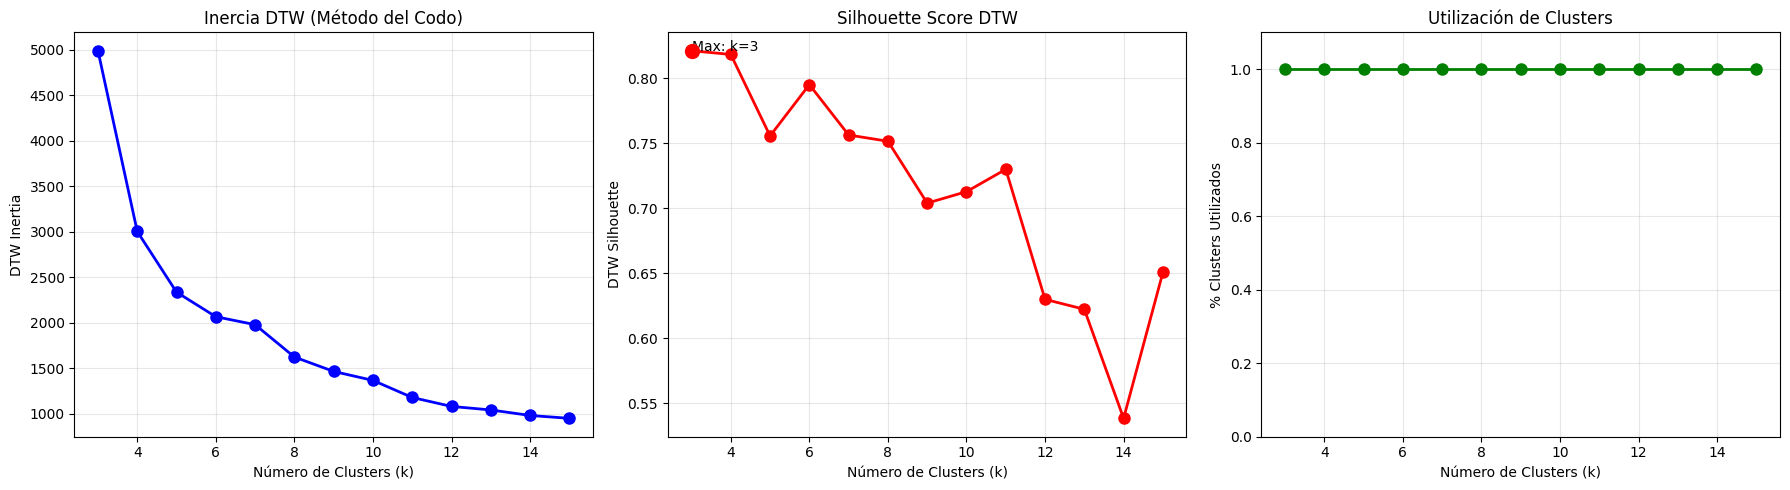


🎯 RECOMENDACIÓN DTW: k = 3
   DTW Silhouette: 0.821
   Utilización: 100.0%

🏆 MEJOR MODELO DTW:
   k = 3
   DTW Silhouette: 0.821
   Utilización: 100.0%


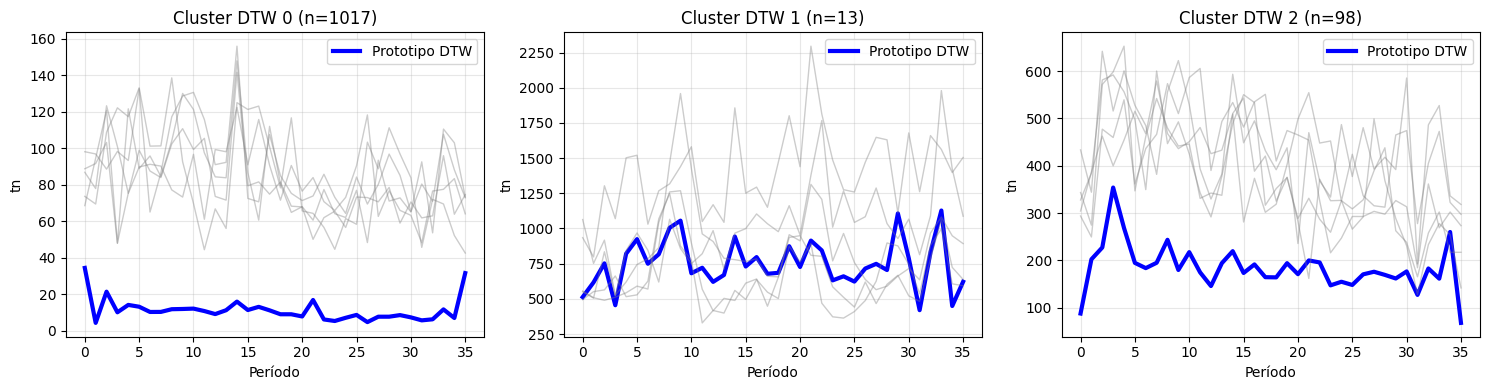

In [24]:
analyzer, best_model, results_df, optimization_results = analyze_timeseries_with_dtw(
    df=df_agg,
    min_periods=6,
    k_range=range(3, 16),
    window=None,  # Sin restricción de ventana
    max_iter=50
)

In [30]:
results_df.to_csv("qv_dtw_resultados.csv", index=False)

In [26]:
# Ver estadísticas por cluster DTW
for cluster_id in np.unique(results_df['cluster_dtw']):
    cluster_products = results_df[results_df['cluster_dtw'] == cluster_id]['product_id']
    print(f"\nCluster DTW {cluster_id}:")
    print(f"  Productos: {len(cluster_products)}")
    print(f"  Ejemplos: {list(cluster_products[:5])}")

# Comparar series dentro de un cluster
def plot_cluster_comparison(analyzer, best_model, cluster_id, max_series=5):
    labels = best_model.predict(analyzer.series_normalized)
    cluster_mask = labels == cluster_id
    cluster_series = analyzer.scaler.inverse_transform(
        analyzer.series_normalized[cluster_mask]
    )
    
    plt.figure(figsize=(12, 6))
    for i, series in enumerate(cluster_series[:max_series]):
        plt.plot(series, alpha=0.7, label=f'Serie {i+1}')
    
    # Plotear prototipo
    prototype = analyzer.scaler.inverse_transform(
        best_model.embeddings[cluster_id].reshape(1, -1)
    )[0]
    plt.plot(prototype, 'k-', linewidth=3, label='Prototipo DTW')
    
    plt.title(f'Cluster DTW {cluster_id} - Series Similares')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# plot_cluster_comparison(analyzer, best_model, cluster_id=0)


Cluster DTW 0:
  Productos: 1017
  Ejemplos: [20086, 20093, 20101, 20103, 20106]

Cluster DTW 1:
  Productos: 13
  Ejemplos: [20001, 20002, 20003, 20004, 20005]

Cluster DTW 2:
  Productos: 98
  Ejemplos: [20013, 20015, 20016, 20017, 20018]


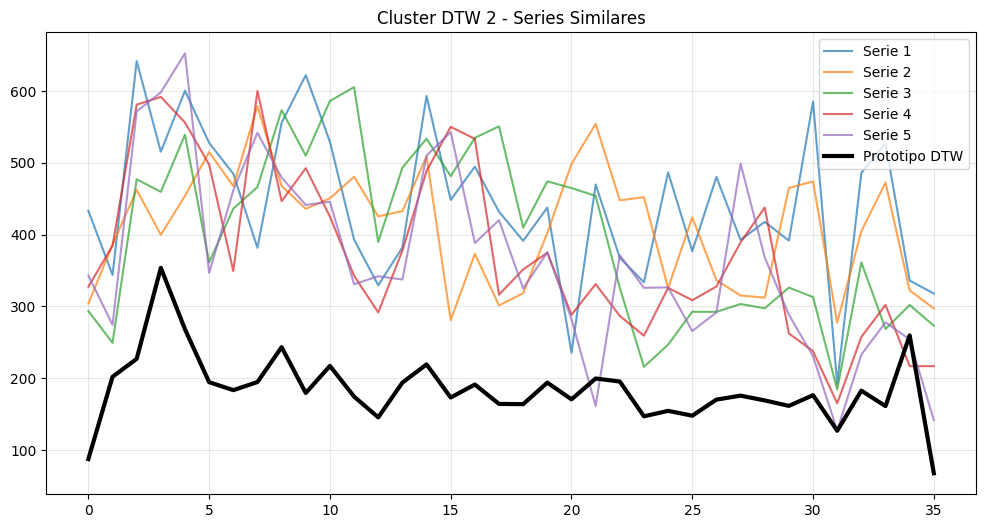

In [29]:
plot_cluster_comparison(analyzer, best_model, cluster_id=2)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

class DTW_VectorQuantizer:
    """Vector Quantizer usando matriz DTW precomputada"""
    
    def __init__(self, distance_matrix, product_ids):
        self.distance_matrix = distance_matrix
        self.product_ids = product_ids
        self.n_products = len(product_ids)
        
    def fit(self, num_codebooks, method='kmeans', max_iter=100):
        """
        Entrena VQ usando matriz DTW
        
        num_codebooks: número de prototipos/códigos
        method: 'kmeans', 'random', 'farthest_first'
        """
        
        if method == 'kmeans':
            # Usar MDS para embeddings + K-means
            embeddings = self._get_mds_embeddings(n_components=10)
            kmeans = KMeans(n_clusters=num_codebooks, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(embeddings)
            
        elif method == 'random':
            # Selección aleatoria de prototipos
            prototype_indices = np.random.choice(self.n_products, num_codebooks, replace=False)
            cluster_labels = self._assign_to_prototypes(prototype_indices)
            
        elif method == 'farthest_first':
            # Algoritmo farthest-first usando matriz DTW
            prototype_indices = self._farthest_first_selection(num_codebooks)
            cluster_labels = self._assign_to_prototypes(prototype_indices)
        
        elif method == 'lloyd_dtw':
            # Lloyd's algorithm adaptado para DTW
            cluster_labels = self._lloyd_dtw(num_codebooks, max_iter)
        
        self.cluster_labels = cluster_labels
        self.num_codebooks = num_codebooks
        self.method = method
        
        # Calcular prototipos (índices de productos más representativos)
        self.prototype_indices = self._find_medoids(cluster_labels)
        
        return self
    
    def _get_mds_embeddings(self, n_components=10):
        """Obtiene embeddings usando MDS en matriz DTW"""
        from sklearn.manifold import MDS
        
        print(f"Calculando MDS con {n_components} componentes...")
        mds = MDS(n_components=n_components, dissimilarity='precomputed', 
                  random_state=42, n_init=1)
        embeddings = mds.fit_transform(self.distance_matrix)
        
        return embeddings
    
    def _farthest_first_selection(self, num_codebooks):
        """Selección farthest-first usando matriz DTW"""
        prototype_indices = []
        
        # Primer prototipo aleatorio
        prototype_indices.append(np.random.randint(self.n_products))
        
        for _ in range(1, num_codebooks):
            # Encontrar punto más lejano a prototipos actuales
            min_distances = np.full(self.n_products, np.inf)
            
            for proto_idx in prototype_indices:
                distances_to_proto = self.distance_matrix[proto_idx]
                min_distances = np.minimum(min_distances, distances_to_proto)
            
            # Seleccionar el más lejano
            farthest_idx = np.argmax(min_distances)
            prototype_indices.append(farthest_idx)
        
        # Asignar cada punto al prototipo más cercano
        cluster_labels = self._assign_to_prototypes(prototype_indices)
        
        return cluster_labels
    
    def _assign_to_prototypes(self, prototype_indices):
        """Asigna cada producto al prototipo más cercano"""
        cluster_labels = np.zeros(self.n_products, dtype=int)
        
        for i in range(self.n_products):
            distances_to_protos = [self.distance_matrix[i, proto_idx] 
                                 for proto_idx in prototype_indices]
            cluster_labels[i] = np.argmin(distances_to_protos)
        
        return cluster_labels
    
    def _lloyd_dtw(self, num_codebooks, max_iter):
        """Algoritmo Lloyd adaptado para DTW"""
        print(f"Lloyd's DTW con {num_codebooks} códigos...")
        
        # Inicialización aleatoria
        cluster_labels = np.random.randint(0, num_codebooks, self.n_products)
        
        for iteration in range(max_iter):
            old_labels = cluster_labels.copy()
            
            # M-step: Encontrar medoids (prototipos) para cada cluster
            prototype_indices = self._find_medoids(cluster_labels)
            
            # E-step: Reasignar puntos a prototipos más cercanos
            cluster_labels = self._assign_to_prototypes(prototype_indices)
            
            # Verificar convergencia
            if np.array_equal(old_labels, cluster_labels):
                print(f"Convergencia en iteración {iteration + 1}")
                break
        
        return cluster_labels
    
    def _find_medoids(self, cluster_labels):
        """Encuentra medoids (puntos más centrales) para cada cluster"""
        medoids = []
        
        for cluster_id in range(self.num_codebooks):
            cluster_mask = cluster_labels == cluster_id
            cluster_indices = np.where(cluster_mask)[0]
            
            if len(cluster_indices) == 0:
                # Cluster vacío - asignar punto aleatorio
                medoids.append(np.random.randint(self.n_products))
            elif len(cluster_indices) == 1:
                # Solo un punto
                medoids.append(cluster_indices[0])
            else:
                # Encontrar punto con menor distancia promedio intra-cluster
                min_avg_distance = np.inf
                best_medoid = cluster_indices[0]
                
                for candidate in cluster_indices:
                    avg_distance = np.mean(self.distance_matrix[candidate, cluster_indices])
                    if avg_distance < min_avg_distance:
                        min_avg_distance = avg_distance
                        best_medoid = candidate
                
                medoids.append(best_medoid)
        
        return medoids
    
    def evaluate(self):
        """Evalúa la calidad del VQ"""
        
        # Distorsión promedio (distancia promedio al prototipo más cercano)
        total_distortion = 0
        for i in range(self.n_products):
            cluster_id = self.cluster_labels[i]
            prototype_idx = self.prototype_indices[cluster_id]
            distortion = self.distance_matrix[i, prototype_idx]
            total_distortion += distortion
        
        avg_distortion = total_distortion / self.n_products
        
        # Silhouette score
        try:
            silhouette = silhouette_score(self.distance_matrix, self.cluster_labels, 
                                        metric='precomputed')
        except:
            silhouette = 0
        
        # Utilización de códigos
        used_codes = len(np.unique(self.cluster_labels))
        utilization = used_codes / self.num_codebooks
        
        results = {
            'avg_distortion': avg_distortion,
            'silhouette': silhouette,
            'utilization': utilization,
            'used_codes': used_codes
        }
        
        return results
    
    def get_results_dataframe(self):
        """Obtiene DataFrame con resultados"""
        return pd.DataFrame({
            'product_id': self.product_ids,
            'vq_cluster': self.cluster_labels,
            'prototype_product': [self.product_ids[self.prototype_indices[label]] 
                                for label in self.cluster_labels]
        })

def compare_vq_methods(distance_matrix, product_ids, num_codebooks=50):
    """Compara diferentes métodos de VQ"""
    
    methods = ['kmeans', 'farthest_first', 'lloyd_dtw']
    results = {}
    
    print(f"Comparando métodos VQ con {num_codebooks} códigos...\n")
    
    for method in methods:
        print(f"--- Método: {method} ---")
        
        vq = DTW_VectorQuantizer(distance_matrix, product_ids)
        vq.fit(num_codebooks, method=method)
        
        metrics = vq.evaluate()
        results_df = vq.get_results_dataframe()
        
        results[method] = {
            'vq_model': vq,
            'metrics': metrics,
            'results_df': results_df
        }
        
        print(f"  Distorsión promedio: {metrics['avg_distortion']:.3f}")
        print(f"  Silhouette: {metrics['silhouette']:.3f}")
        print(f"  Utilización: {metrics['utilization']:.1%}")
        print(f"  Códigos usados: {metrics['used_codes']}/{num_codebooks}\n")
    
    # Mejor método
    best_method = max(results.keys(), 
                     key=lambda m: results[m]['metrics']['silhouette'])
    
    print(f"🏆 MEJOR MÉTODO: {best_method}")
    print(f"   Silhouette: {results[best_method]['metrics']['silhouette']:.3f}")
    
    return results, best_method

def optimize_num_codebooks_vq(distance_matrix, product_ids, 
                             codebook_range=[20, 30, 40, 50, 60, 70], 
                             method='farthest_first'):
    """Optimiza número de códigos para VQ"""
    
    optimization_results = []
    
    for num_codes in codebook_range:
        print(f"Probando {num_codes} códigos...")
        
        vq = DTW_VectorQuantizer(distance_matrix, product_ids)
        vq.fit(num_codes, method=method)
        
        metrics = vq.evaluate()
        metrics['num_codebooks'] = num_codes
        
        optimization_results.append(metrics)
    
    # Plotear resultados
    results_df = pd.DataFrame(optimization_results)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Distorsión
    axes[0].plot(results_df['num_codebooks'], results_df['avg_distortion'], 'bo-')
    axes[0].set_title('Distorsión Promedio')
    axes[0].set_xlabel('Número de Códigos')
    axes[0].grid(True)
    
    # Silhouette
    axes[1].plot(results_df['num_codebooks'], results_df['silhouette'], 'ro-')
    axes[1].set_title('Silhouette Score')
    axes[1].set_xlabel('Número de Códigos')
    axes[1].grid(True)
    
    # Utilización
    axes[2].plot(results_df['num_codebooks'], results_df['utilization'], 'go-')
    axes[2].set_title('Utilización de Códigos')
    axes[2].set_xlabel('Número de Códigos')
    axes[2].set_ylim(0, 1.1)
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Mejor configuración
    best_idx = results_df['silhouette'].idxmax()
    best_config = results_df.iloc[best_idx]
    
    print(f"\n🎯 CONFIGURACIÓN ÓPTIMA:")
    print(f"   Códigos: {best_config['num_codebooks']}")
    print(f"   Silhouette: {best_config['silhouette']:.3f}")
    print(f"   Distorsión: {best_config['avg_distortion']:.3f}")
    
    return optimization_results, best_config

# USO CON TU MATRIZ DTW
"""
# 1. Comparar métodos VQ
vq_results, best_method = compare_vq_methods(
    tu_distance_matrix, 
    tu_product_ids, 
    num_codebooks=50
)

# 2. Optimizar número de códigos
optimization_results, best_config = optimize_num_codebooks_vq(
    tu_distance_matrix, 
    tu_product_ids,
    method=best_method
)

# 3. Obtener mejor modelo VQ
best_vq_model = vq_results[best_method]['vq_model']
vq_clusters_df = vq_results[best_method]['results_df']
"""